In [1]:
# Importing libraries/packages

# For data manipulation, exploration, cleaning, and plotting
import pandas as pd
import sweetviz as sv
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

# For model building and testing
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
### 1
### Using df_1_source

# Read in the source data
df_1_source = pd.read_csv('SCMS_Delivery_History_Dataset.csv')

                                             |    | [  0%]   00:00 -> (? left)


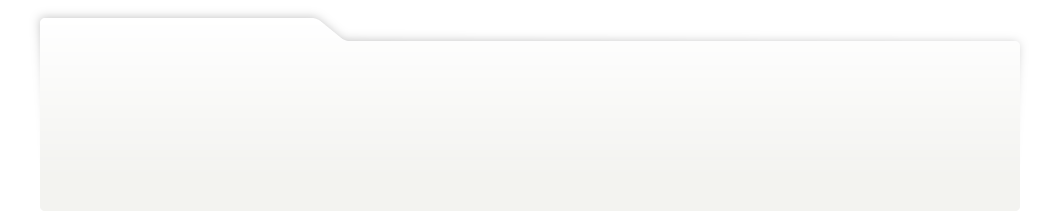
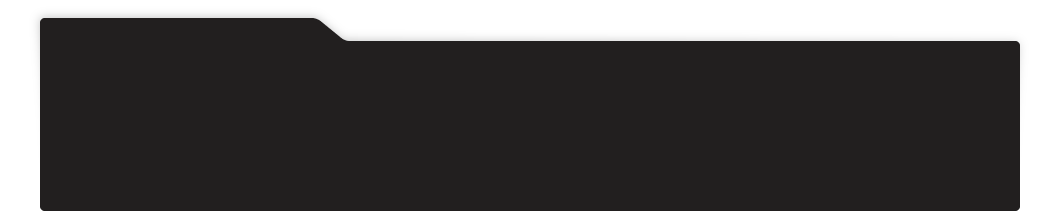
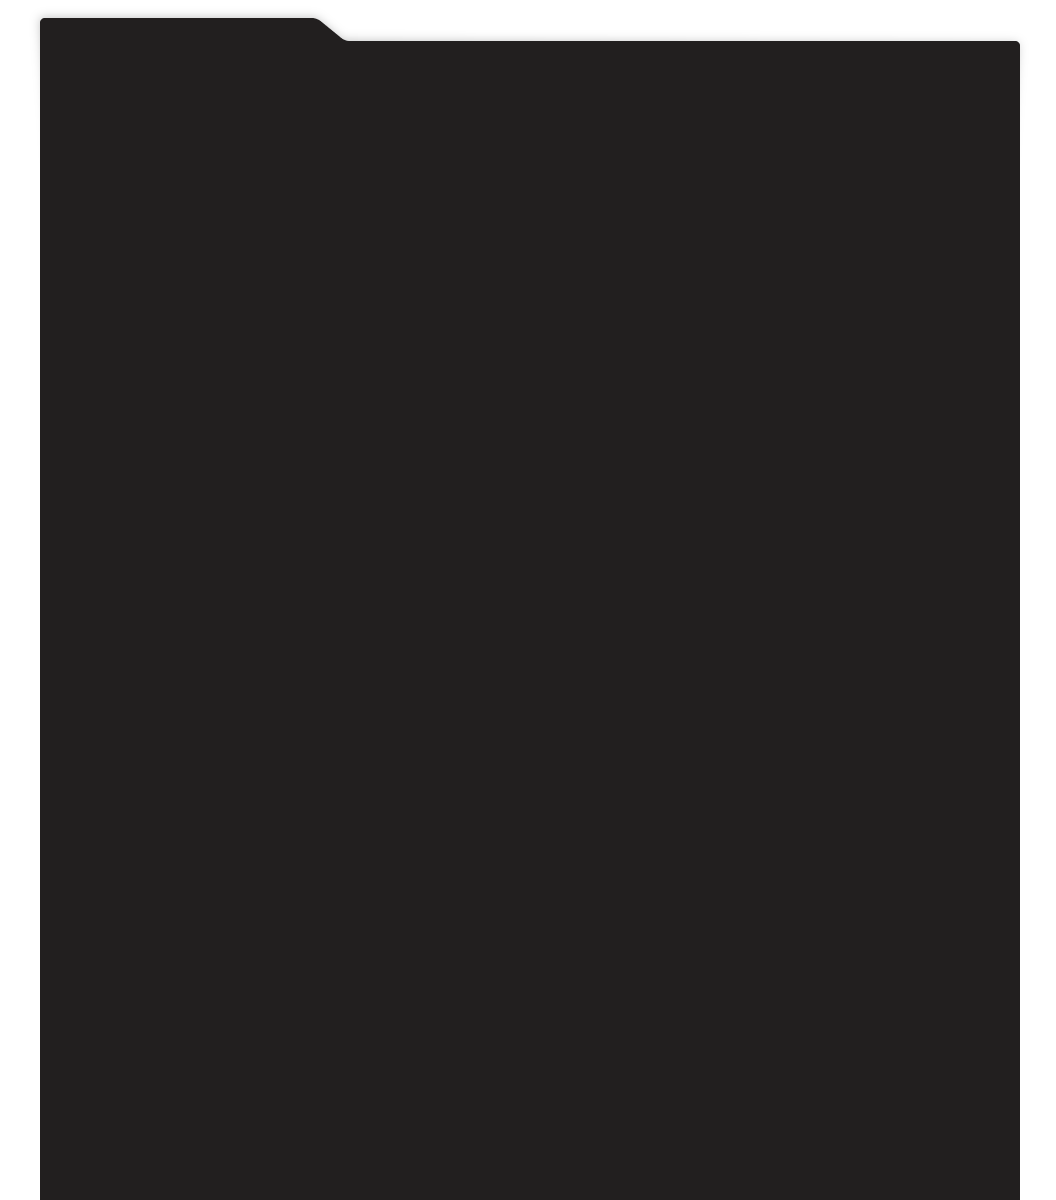
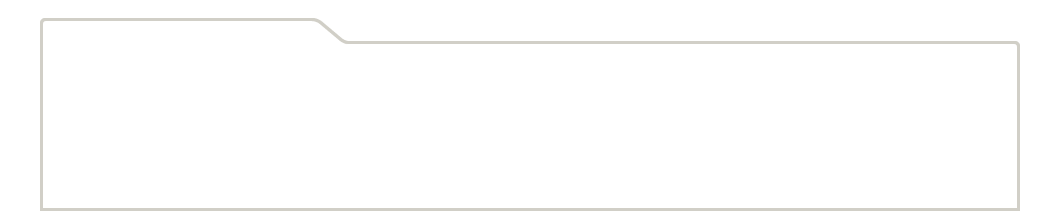
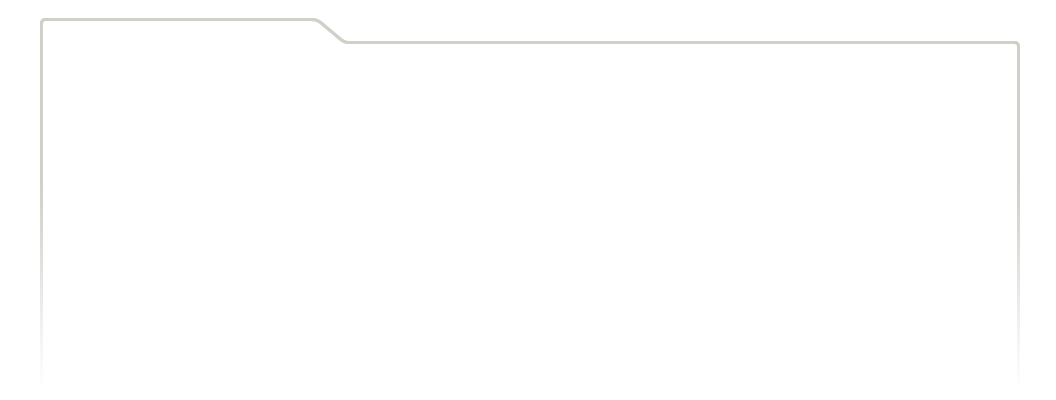
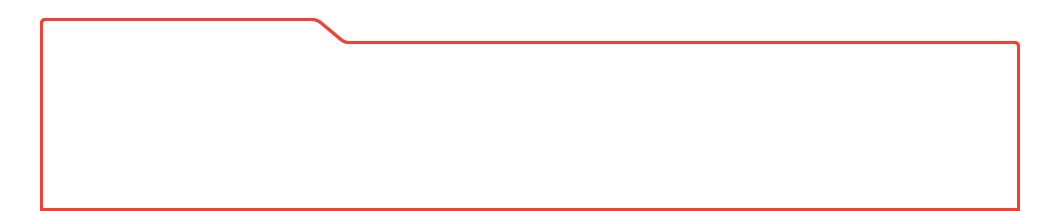
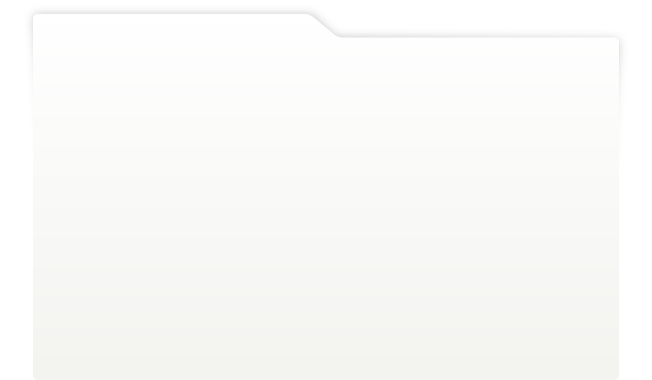
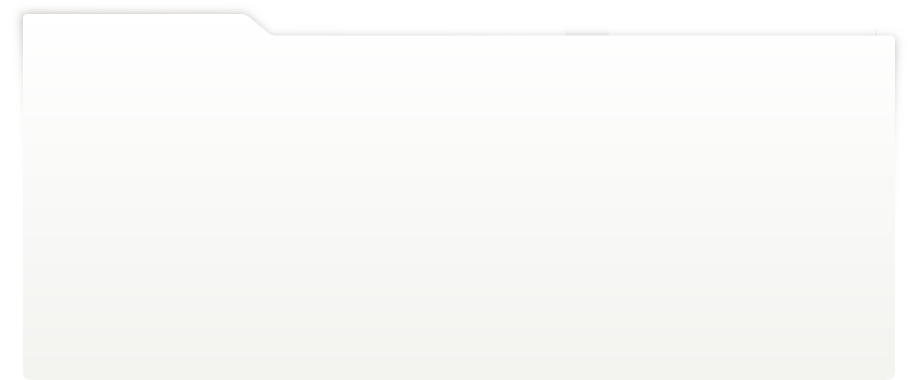
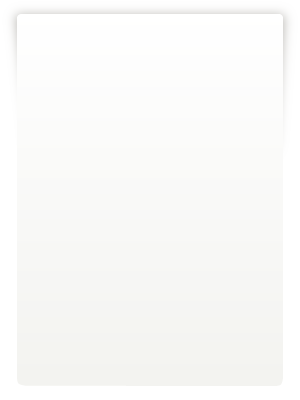
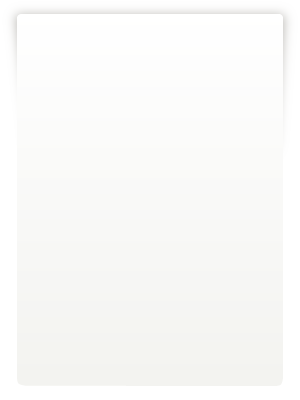
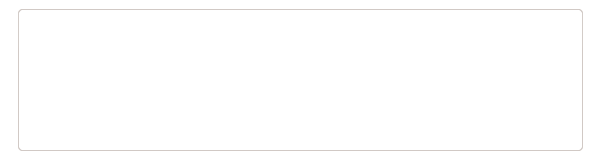
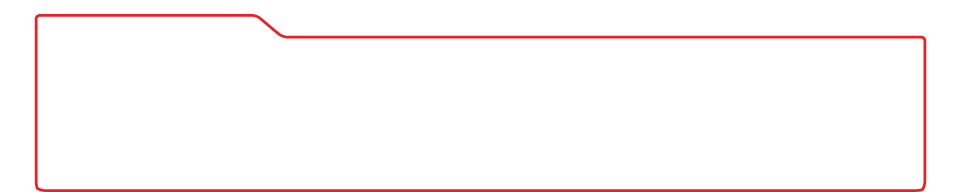
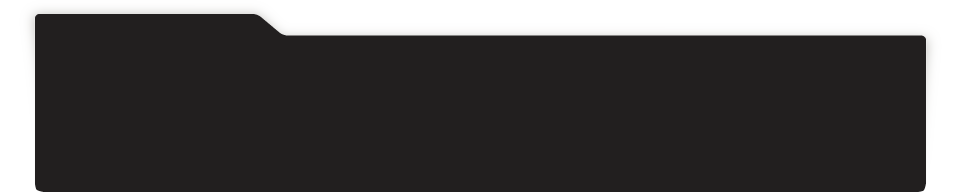
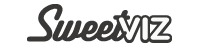
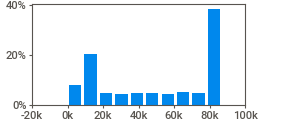
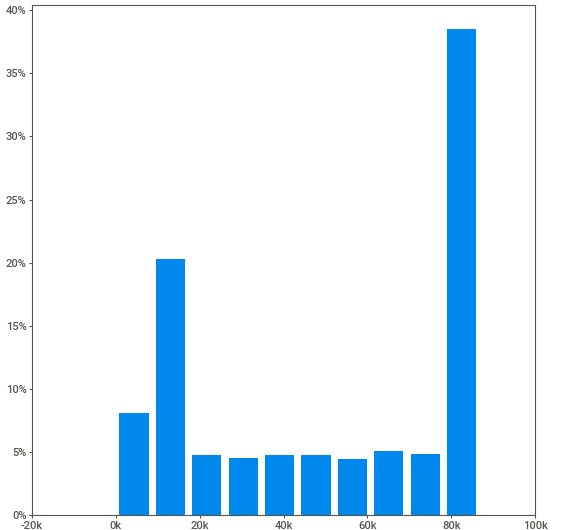
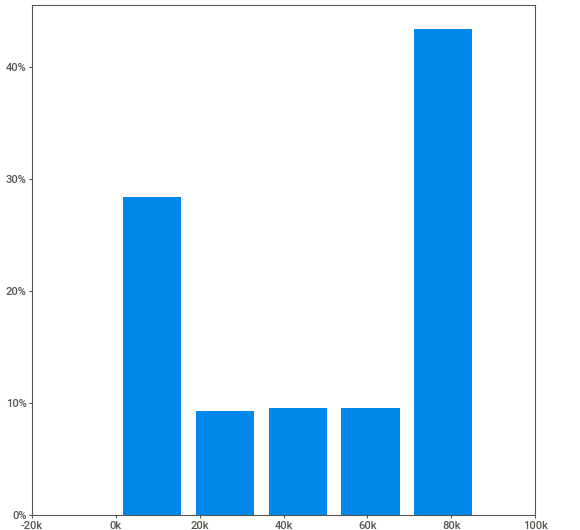
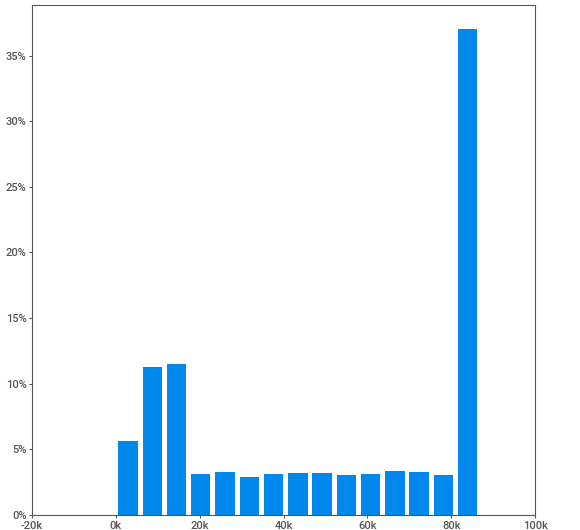
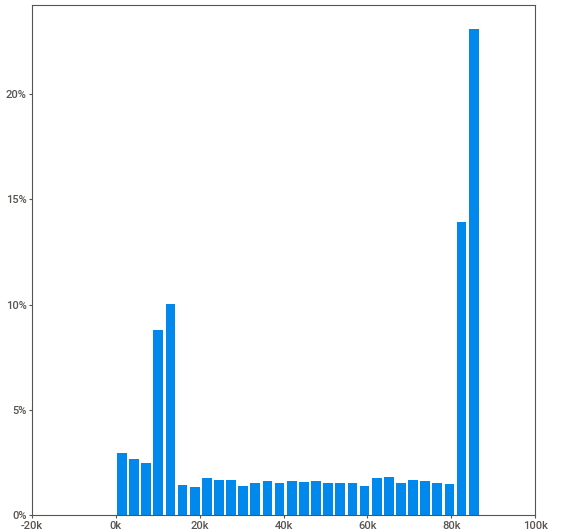
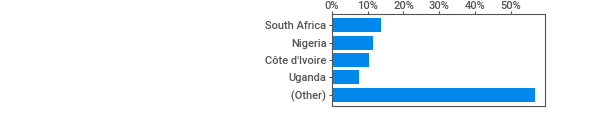
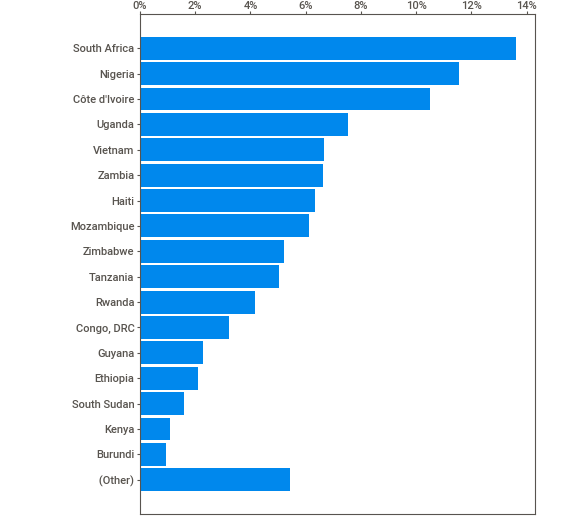
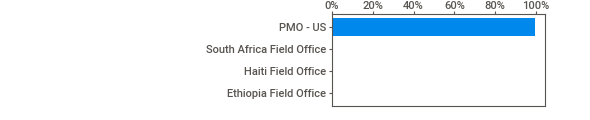
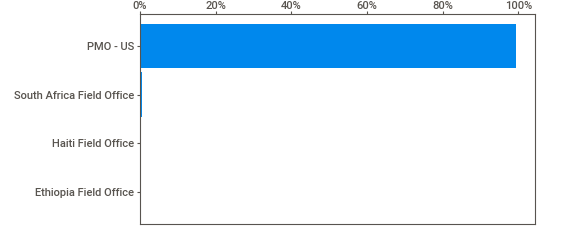
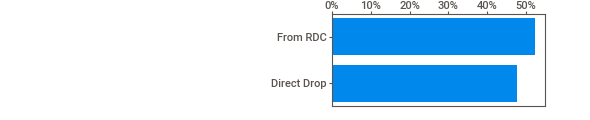
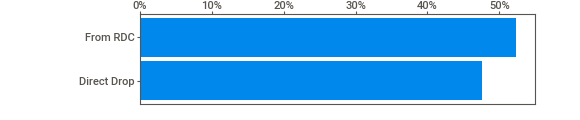
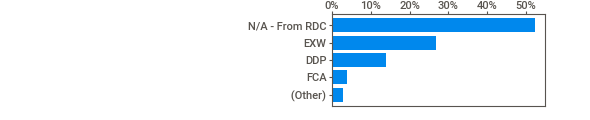
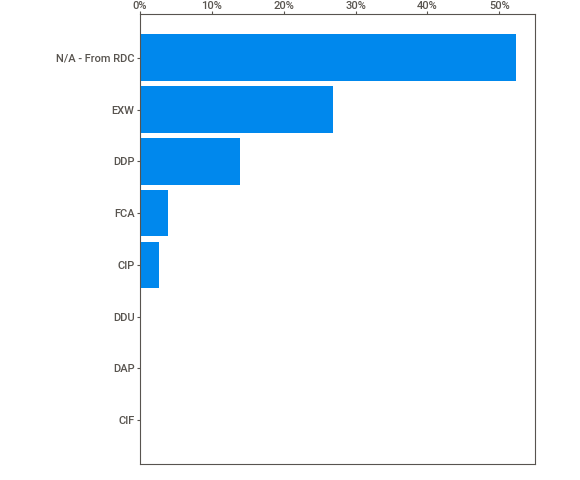
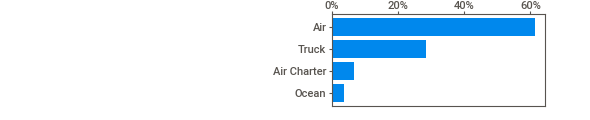
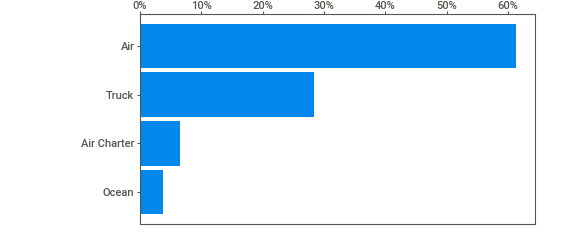
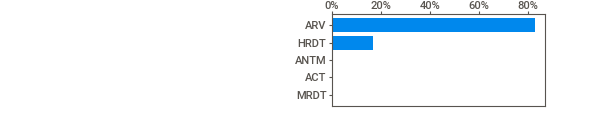
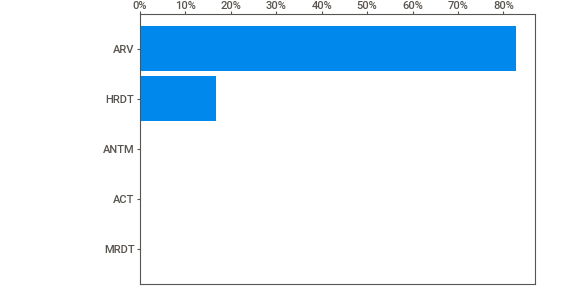
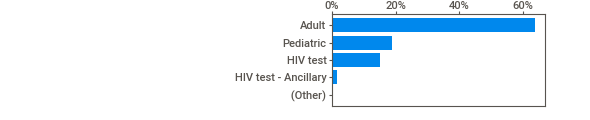
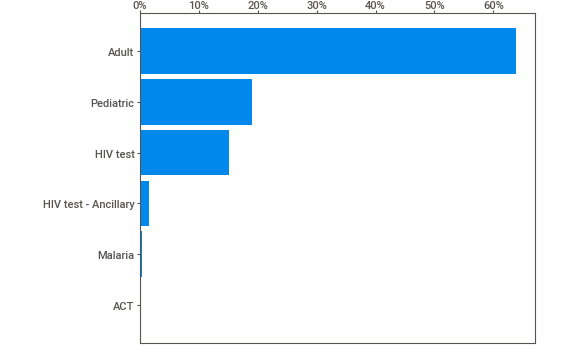
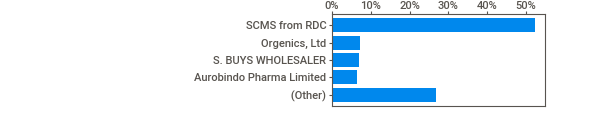
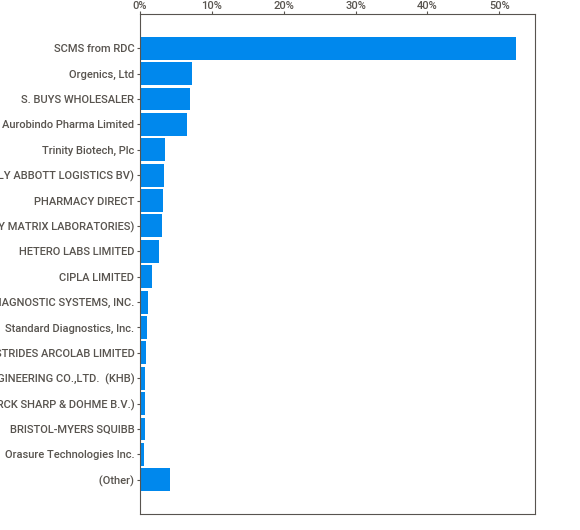
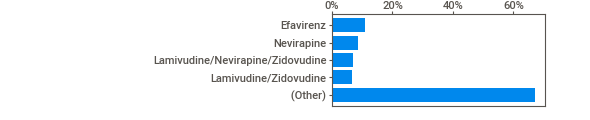
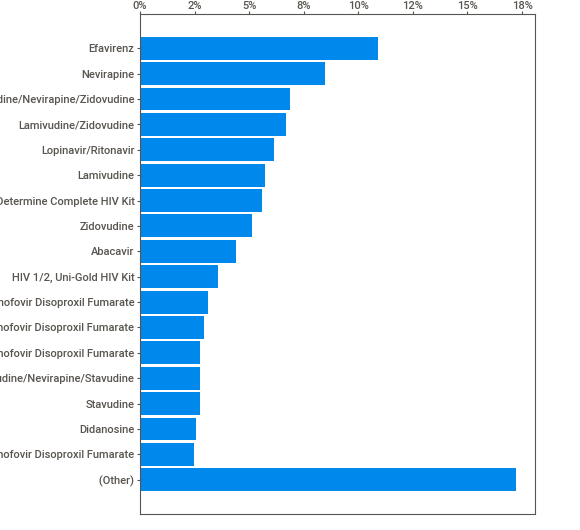
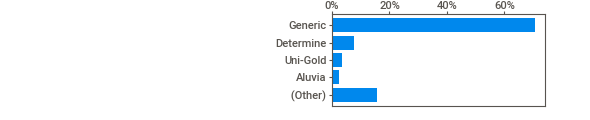
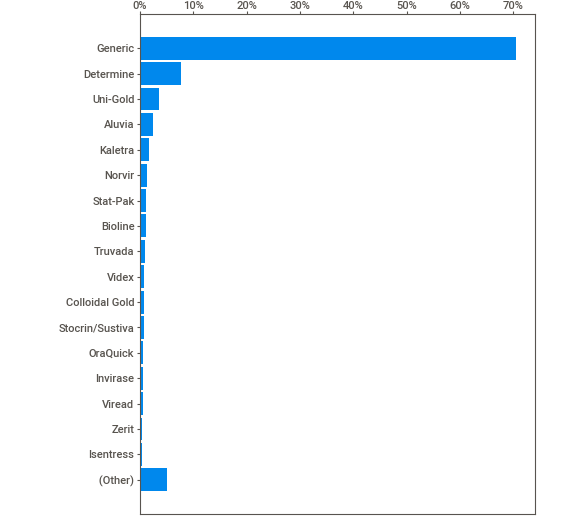
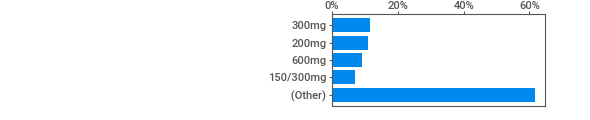
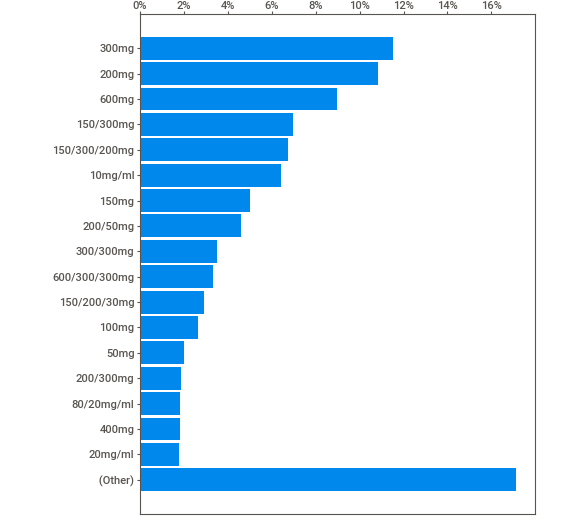
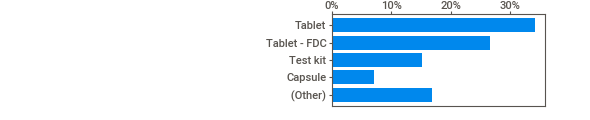
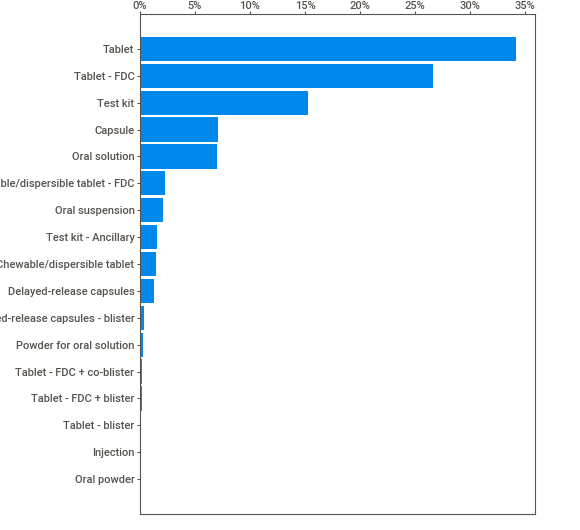
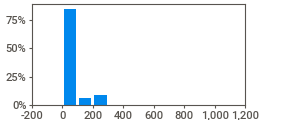
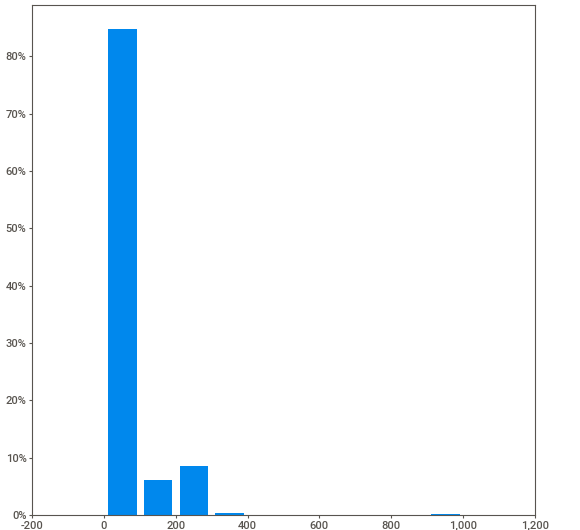
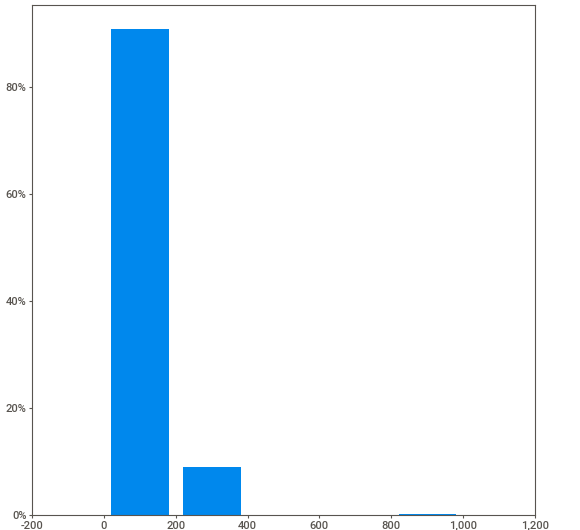
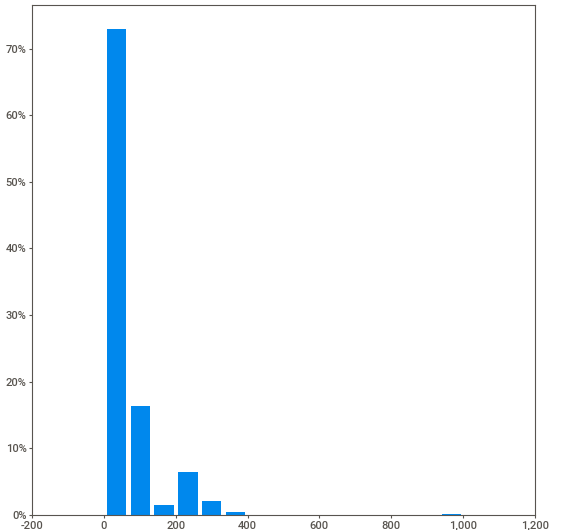
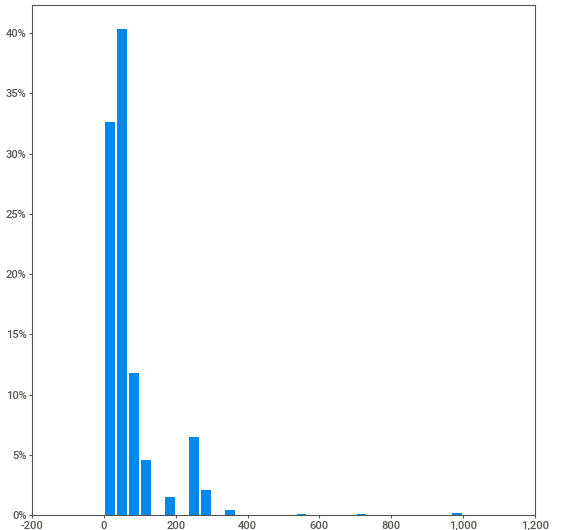
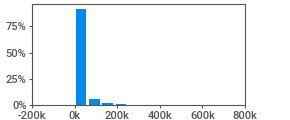
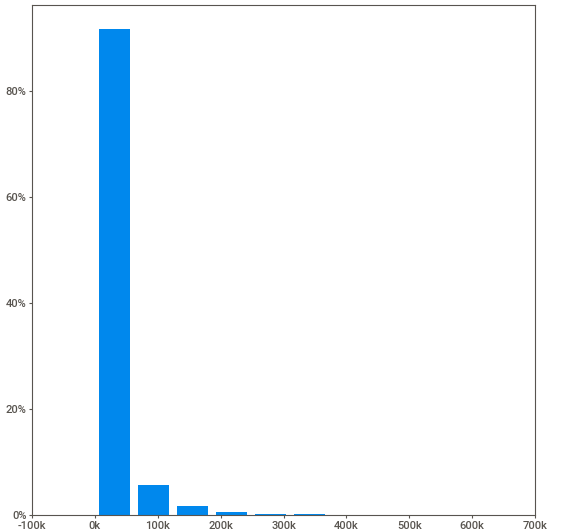
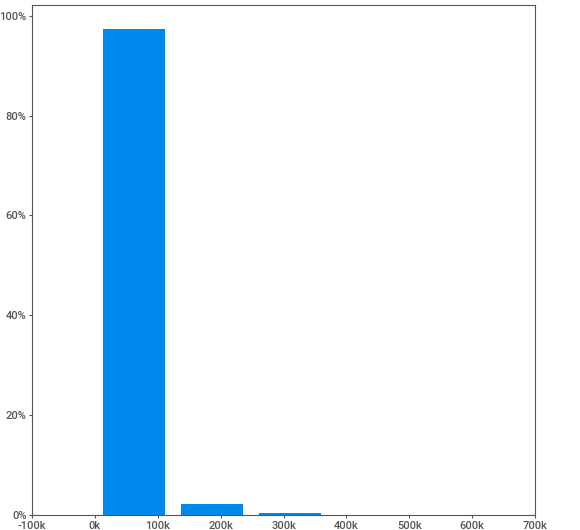
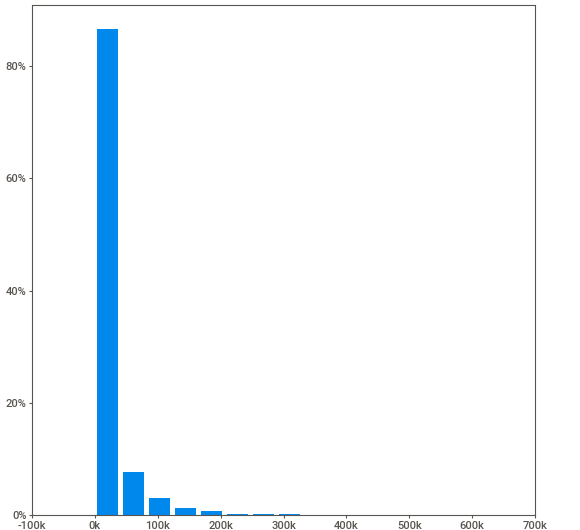
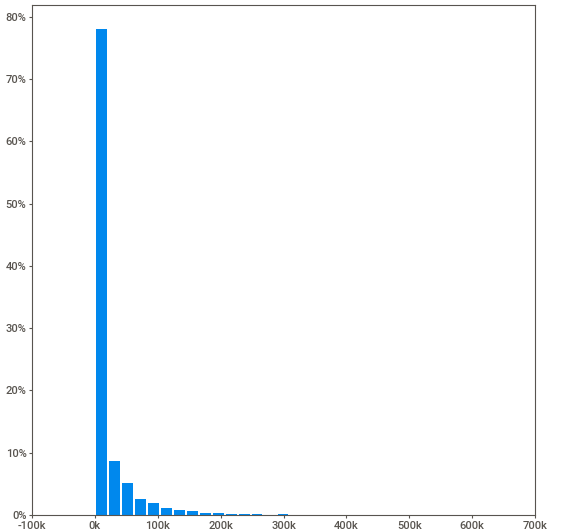
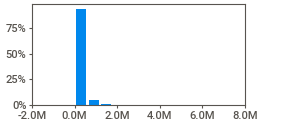
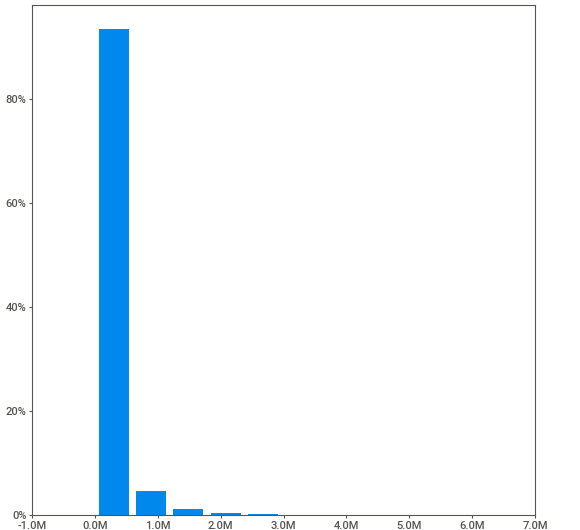
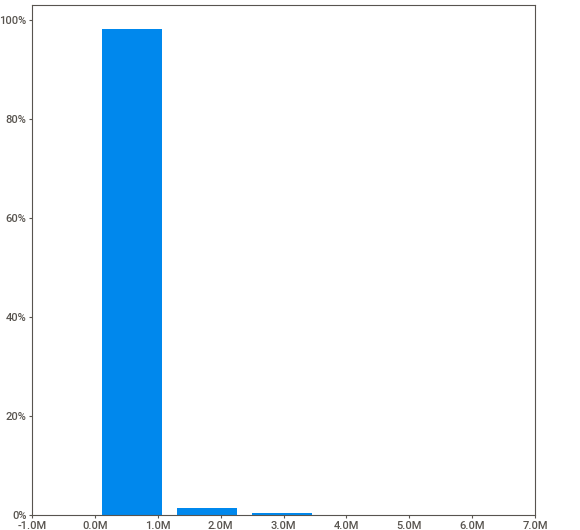
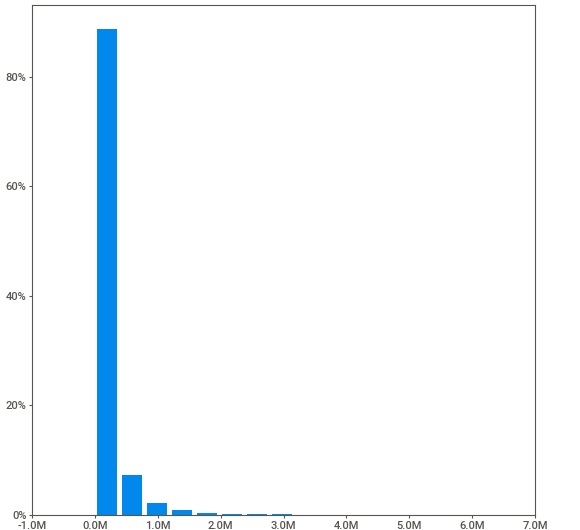
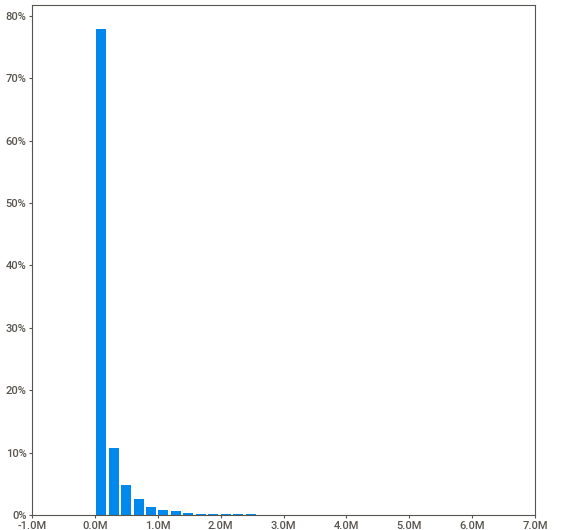
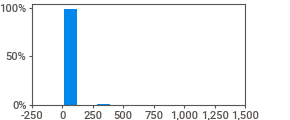
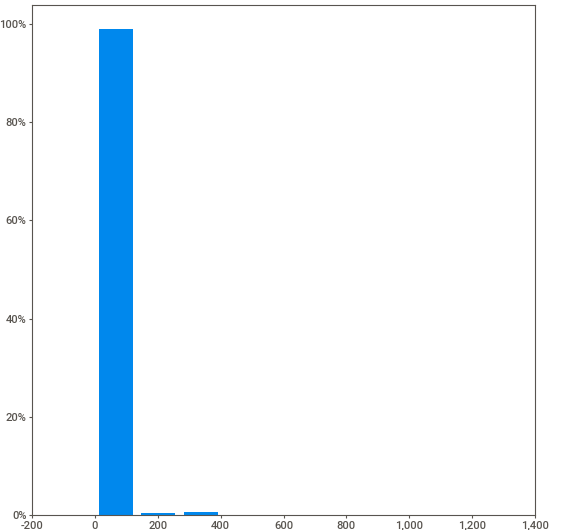
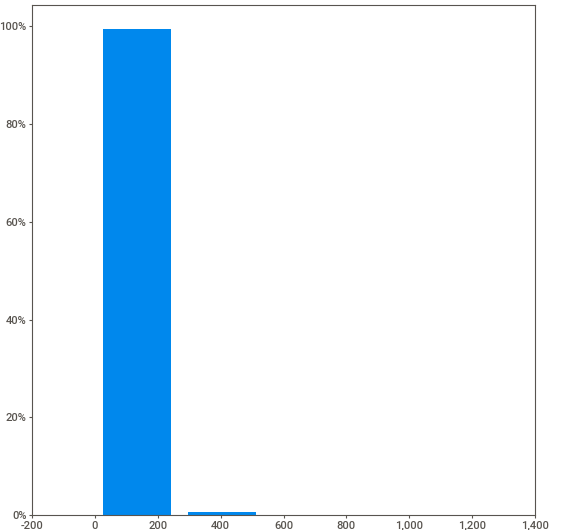
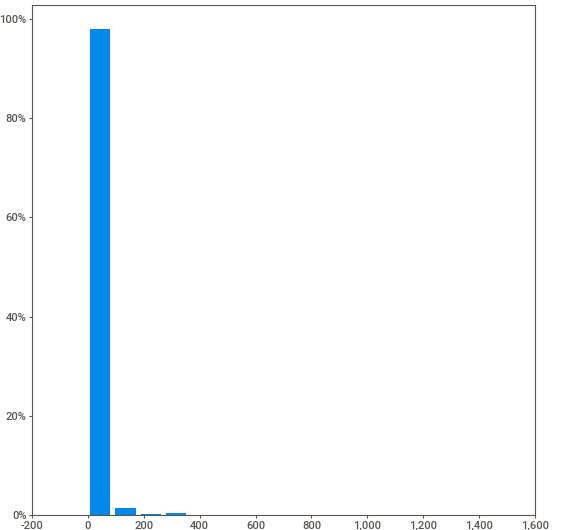
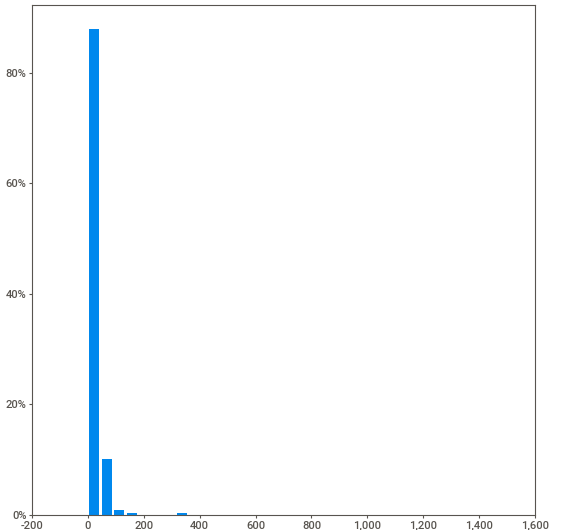
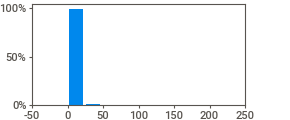
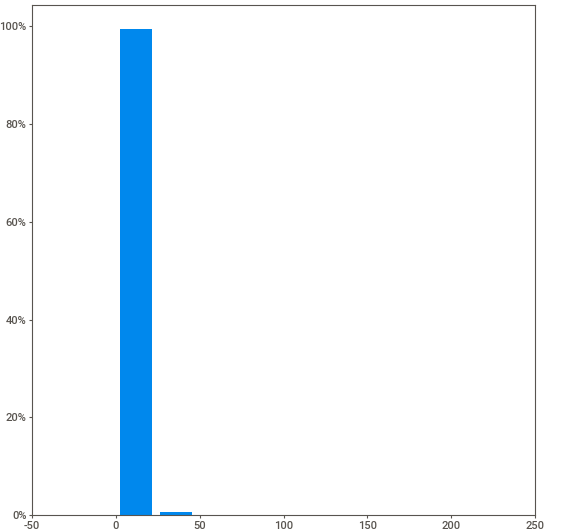
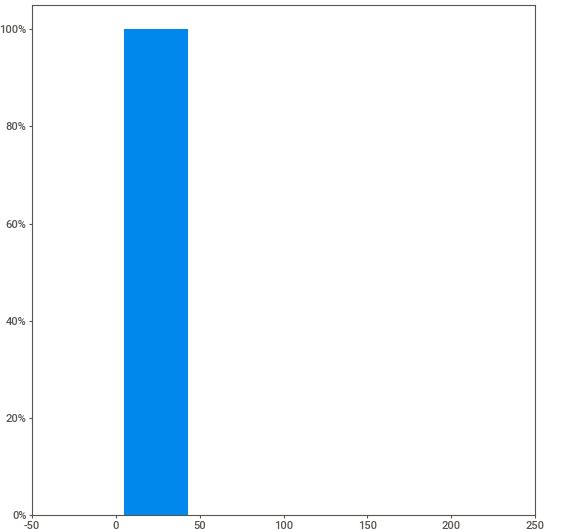
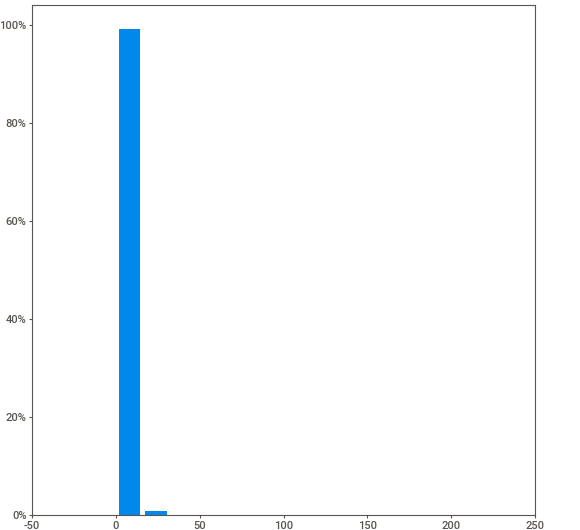
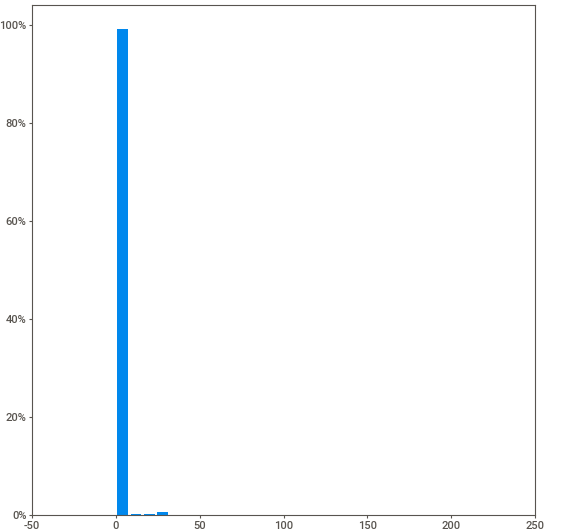
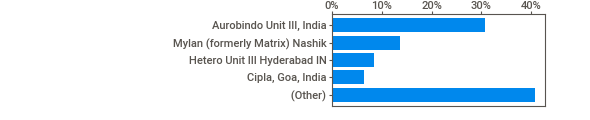
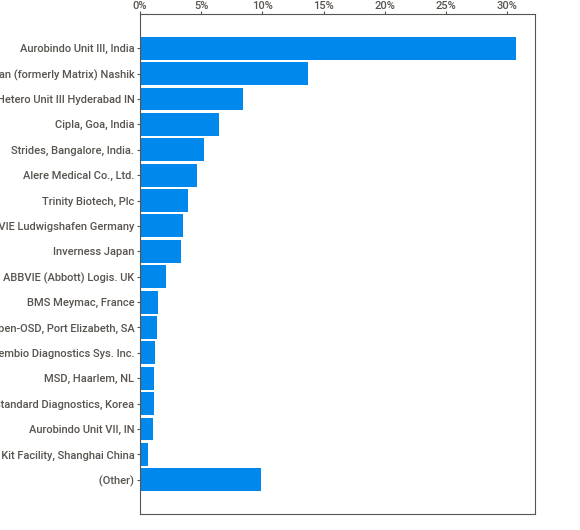
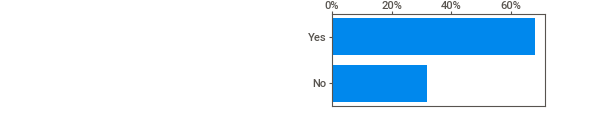
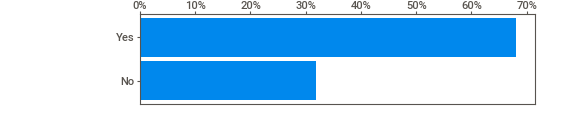
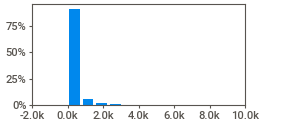
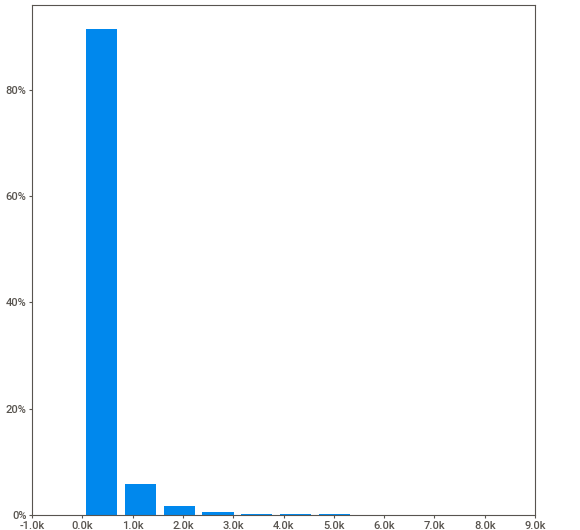
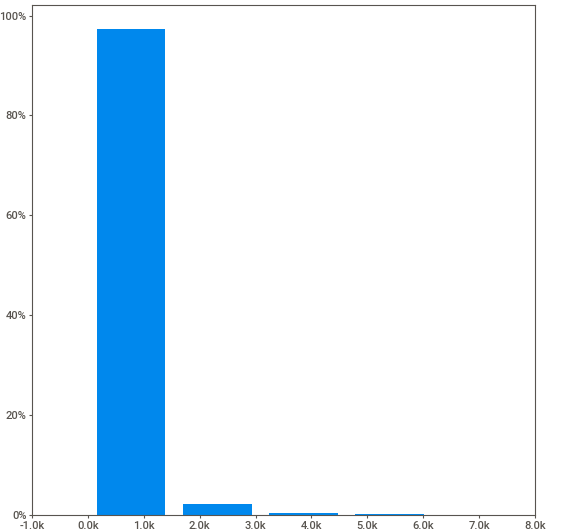
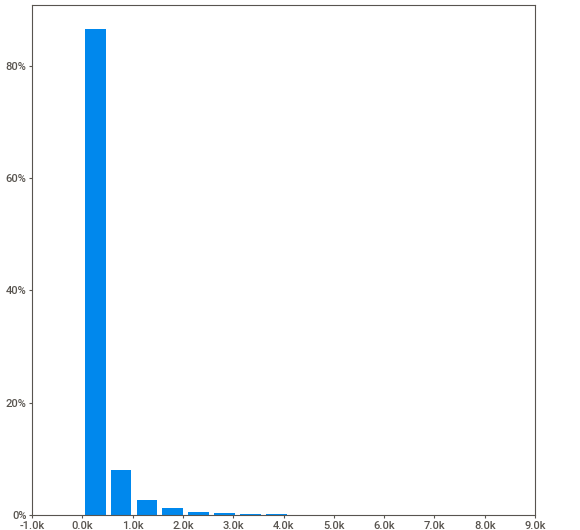
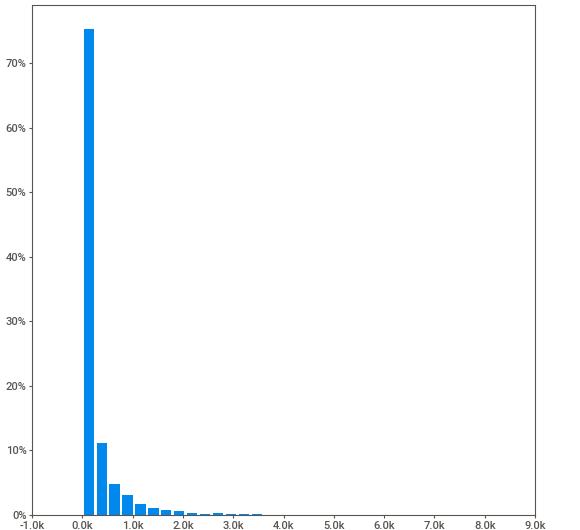
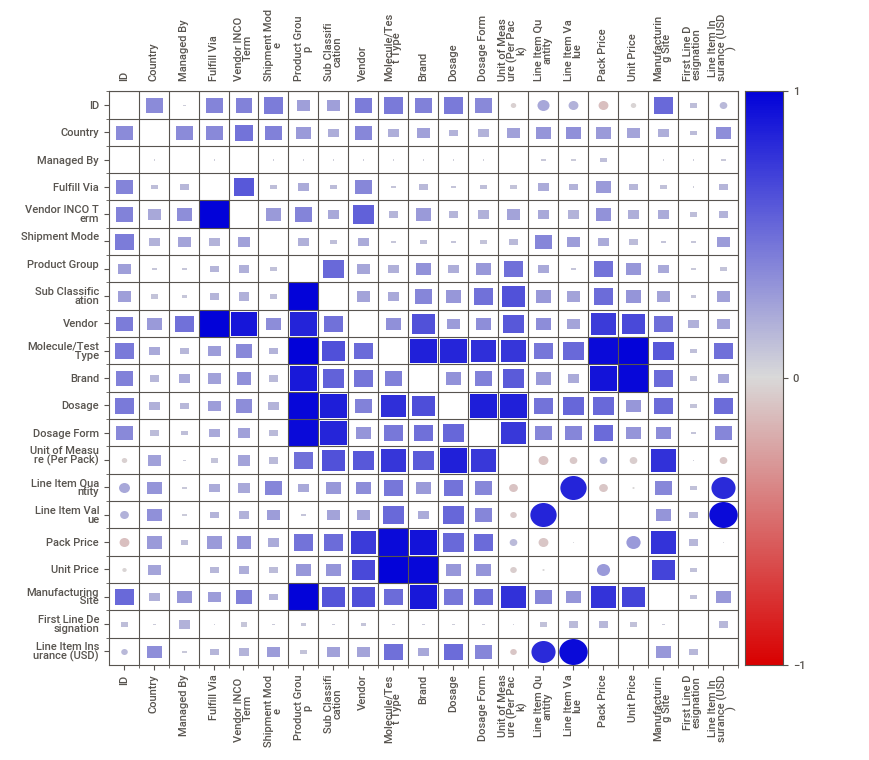
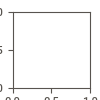

In [3]:
### 1
### Using df_1_source

# Taking an initial high-level look at the data using SweetViz
initial_report = sv.analyze(df_1_source)
initial_report.show_notebook()

In [4]:
### 1 -> 2
### Turns df_1_source into df_2_converted

# Based off of initial SweetViz report, the following features appear to have the following data types
    # 1 - 7 - Categorical
    # 8 - Categorical (Binary)
    # 9 - 10- Categorical
    # 11 - 15 - Categorical/Date
    # 16 - 23 - Categorical
    # 24 - 28 - Numeric
    # 29 - Categorical
    # 30 - Categorical/Binary
    # 31 - 33 - Numeric

# Many categorical columns either have too many distinct values to One-Hot Encode, or a non-useful distribution
    # Columns (index = 1) 1 - 5, 7, maybe 18, 19, 20, 21, 22, 23 
    
# Out of all the date columns, 11 and 12 have too many nulls and 13, 14 and 15 look highly similar
    # Column 14, the "Delivered to Client Date", can be used as our sole date

# All the date and some of the numeric columns are the wrong type, and we want objects to be turned into categorical type
    # Will perform data cleaning to force types, as data originally loads in as strings
    # Will also extract datetime elements (year, month, etc), but only from column 14
    
# Copy source dataframe over
df_2_converted = df_1_source.copy()

# Put columns to convert in lists
date_columns_to_convert = [
                           "PQ First Sent to Client Date", 
                           "PO Sent to Vendor Date",
                           "Scheduled Delivery Date",
                           "Delivered to Client Date",
                           "Delivery Recorded Date"
]

numeric_columns_to_convert = [
                              "Weight (Kilograms)",
                              "Freight Cost (USD)"
]

categorical_columns_to_convert = [
                                  "ID",
                                  "Project Code",
                                  "PQ #",
                                  "PO / SO #",
                                  "ASN/DN #",
                                  "Country",
                                  "Managed By",
                                  "Fulfill Via",
                                  "Vendor INCO Term",
                                  "Shipment Mode",
                                  "Product Group",
                                  "Sub Classification",
                                  "Vendor",
                                  "Item Description",
                                  "Molecule/Test Type",
                                  "Brand",
                                  "Dosage",
                                  "Dosage Form",
                                  "Manufacturing Site",
                                  "First Line Designation",
]

# Use lists and apply() to force datetime and numeric data types
df_2_converted[date_columns_to_convert] = df_2_converted[date_columns_to_convert].apply(
    pd.to_datetime, errors = "coerce"
)

df_2_converted[numeric_columns_to_convert] = df_2_converted[numeric_columns_to_convert].apply(
    pd.to_numeric, errors = "coerce"
)

df_2_converted[categorical_columns_to_convert] = df_2_converted[categorical_columns_to_convert].astype("category")

# Extract datetime componenets for the date columns
df_2_converted["Delivered to Client Date:year"] = df_2_converted["Delivered to Client Date"].dt.year.astype("category")
df_2_converted["Delivered to Client Date:month"] = df_2_converted["Delivered to Client Date"].dt.month.astype("category")

# Check that data types are now as expected
df_2_converted.dtypes

ID                                      category
Project Code                            category
PQ #                                    category
PO / SO #                               category
ASN/DN #                                category
Country                                 category
Managed By                              category
Fulfill Via                             category
Vendor INCO Term                        category
Shipment Mode                           category
PQ First Sent to Client Date      datetime64[ns]
PO Sent to Vendor Date            datetime64[ns]
Scheduled Delivery Date           datetime64[ns]
Delivered to Client Date          datetime64[ns]
Delivery Recorded Date            datetime64[ns]
Product Group                           category
Sub Classification                      category
Vendor                                  category
Item Description                        category
Molecule/Test Type                      category
Brand               

                                             |    | [  0%]   00:00 -> (? left)


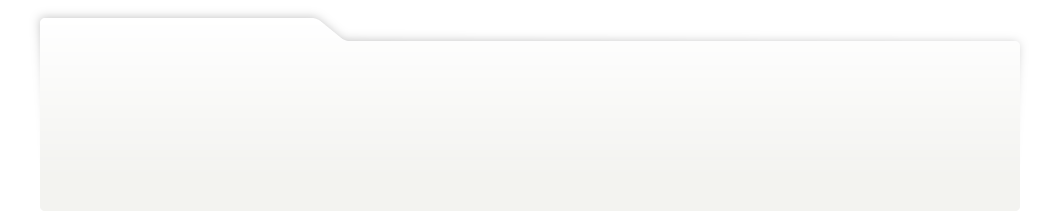
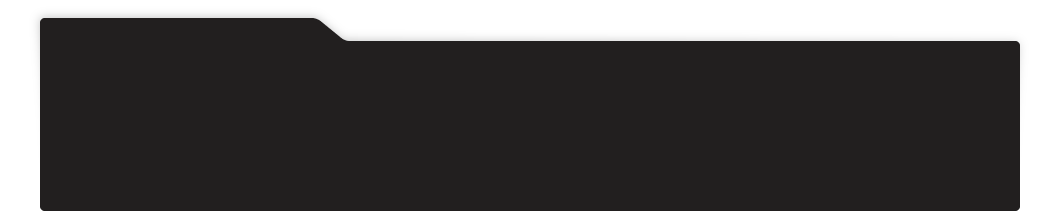
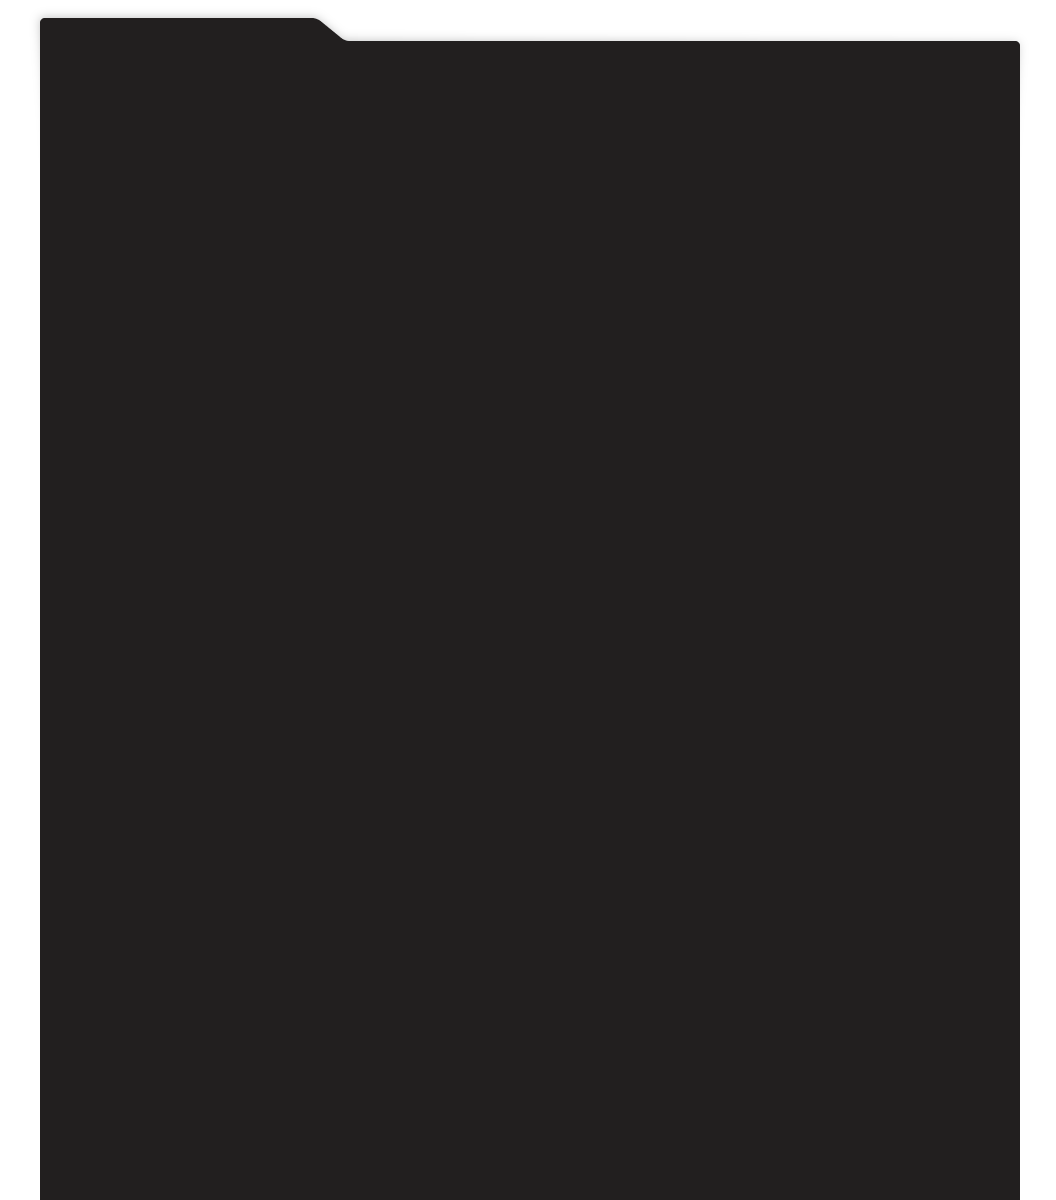
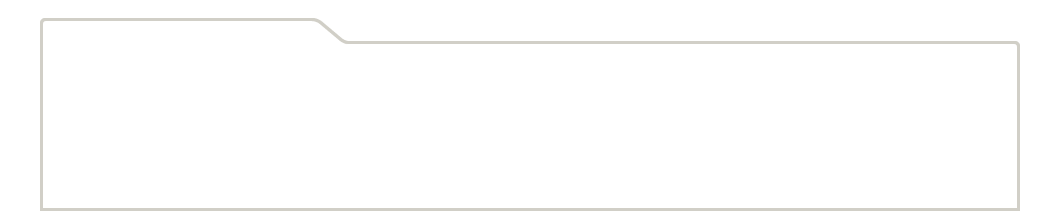
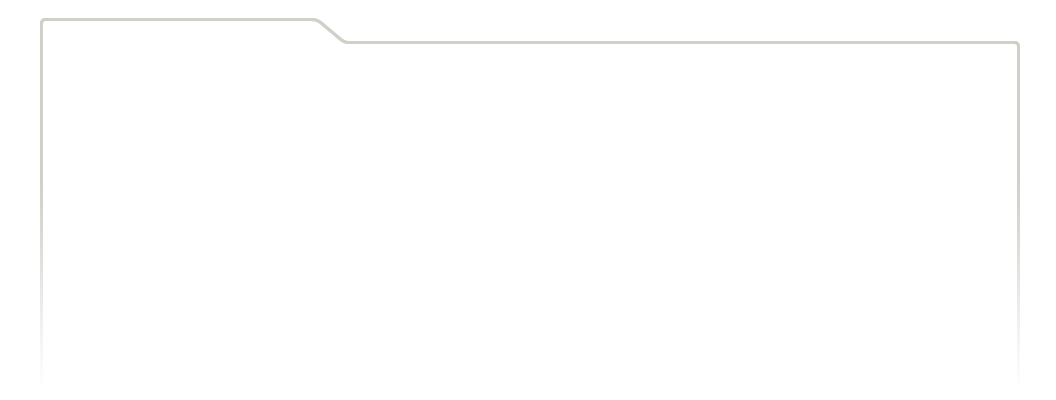
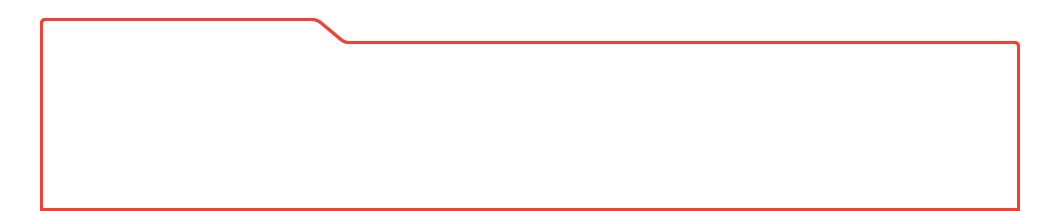
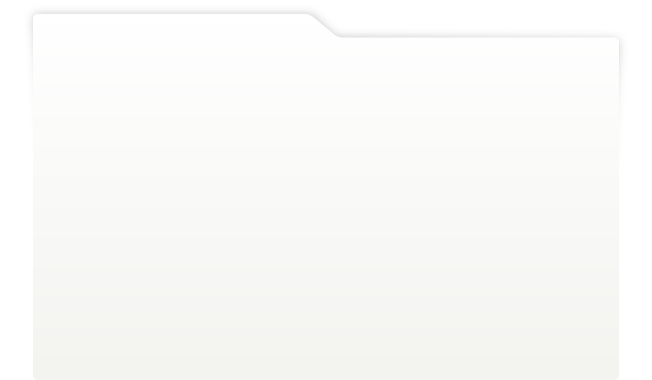
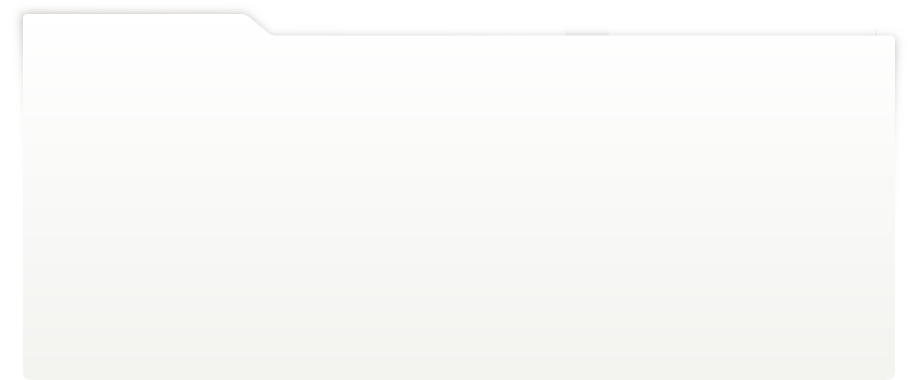
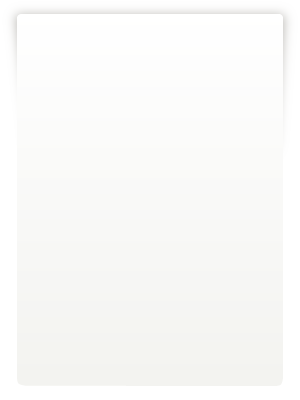
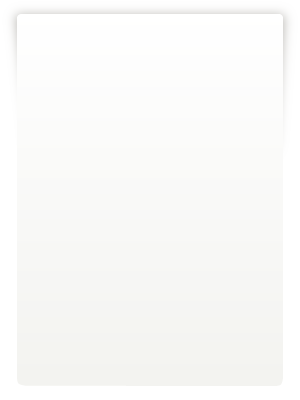
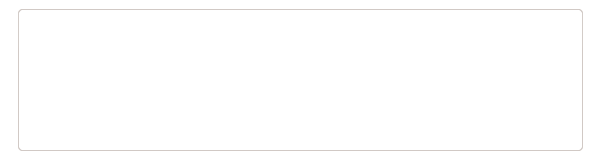
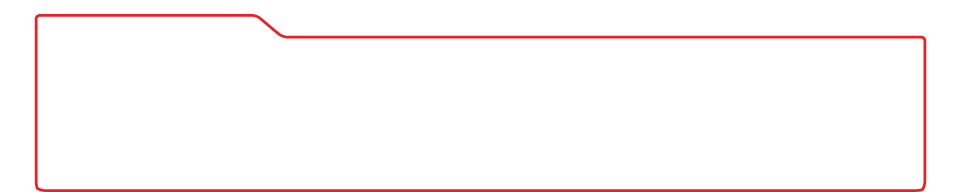
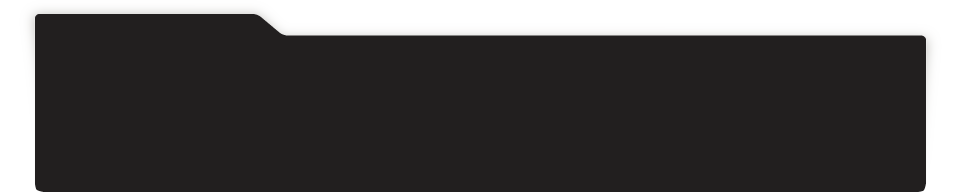
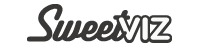
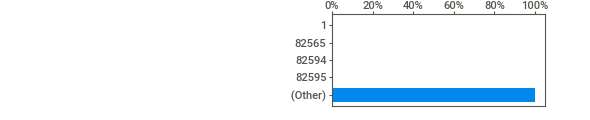
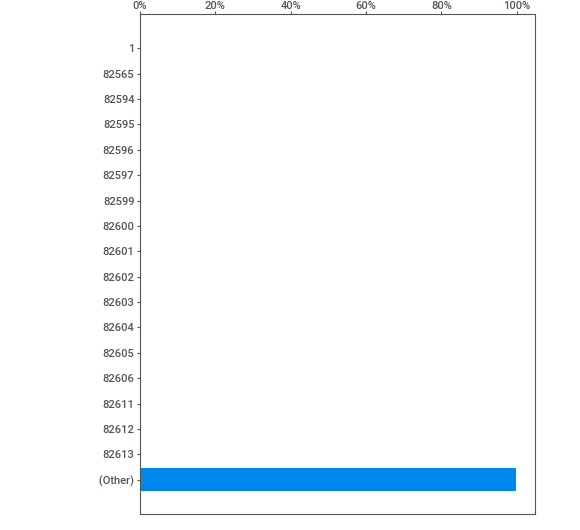
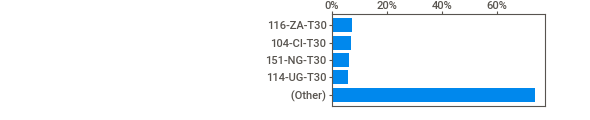
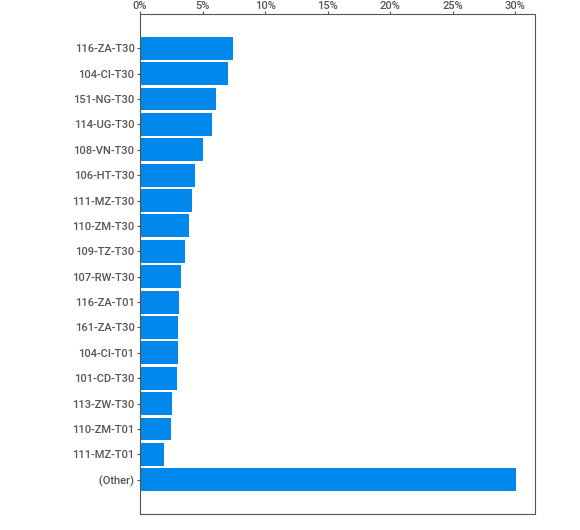
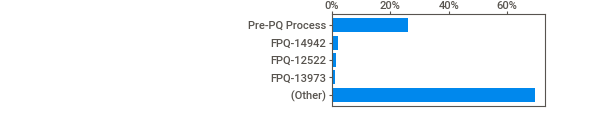
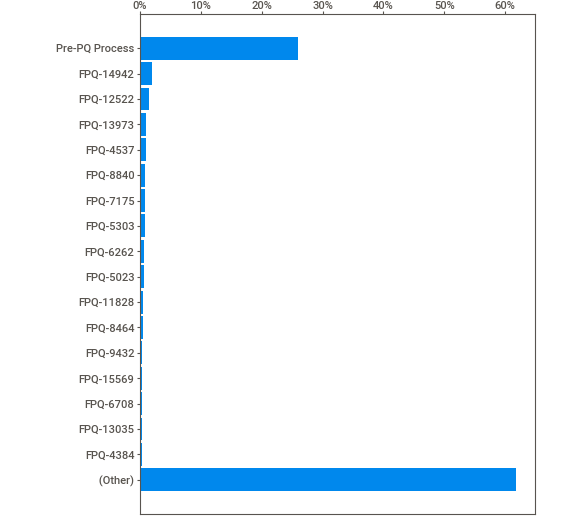
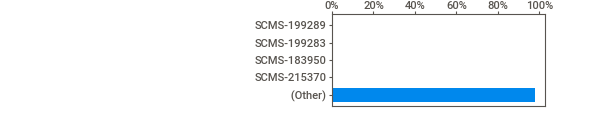
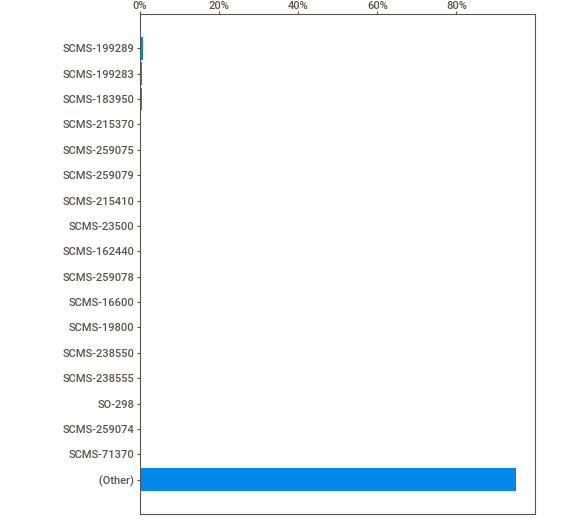
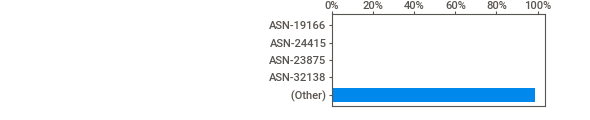
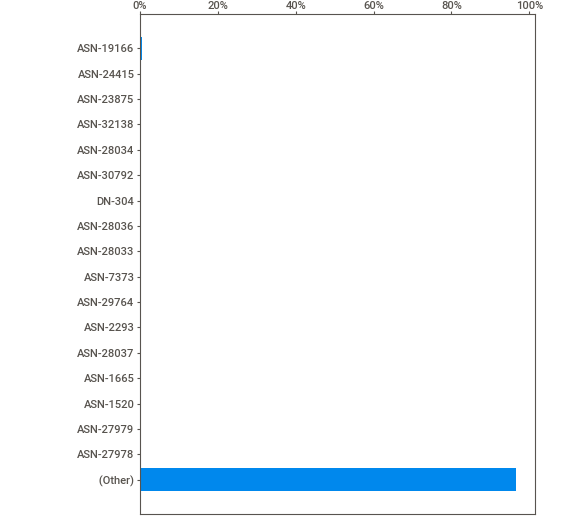
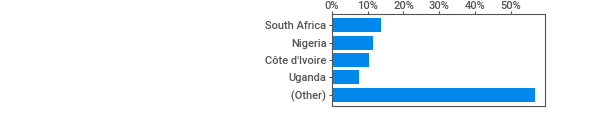
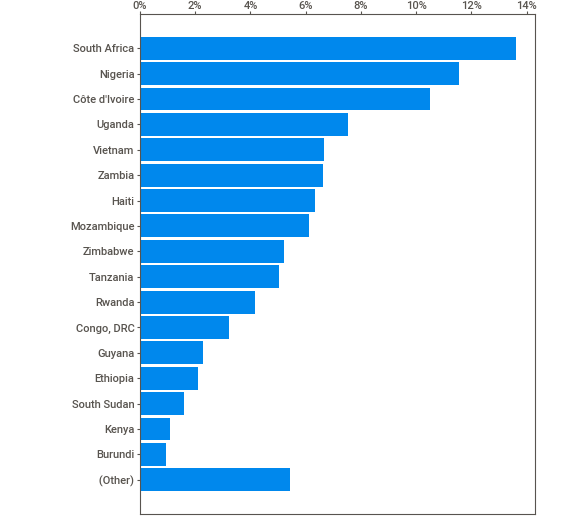
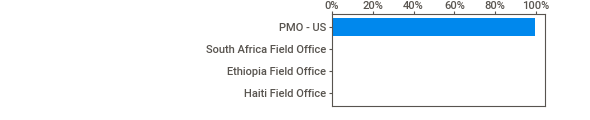
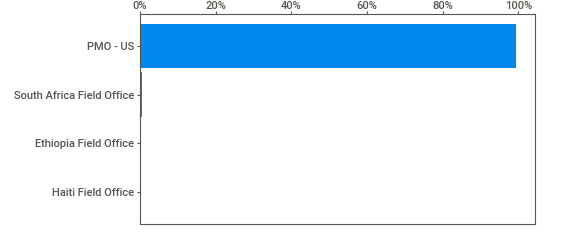
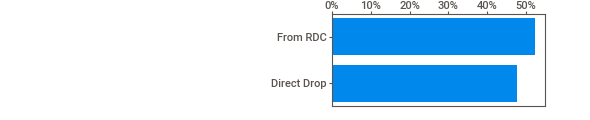
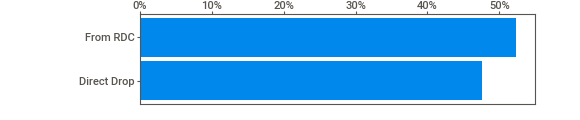
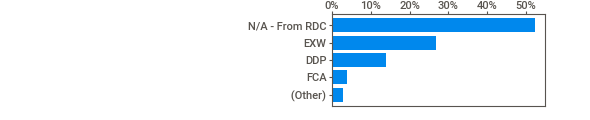
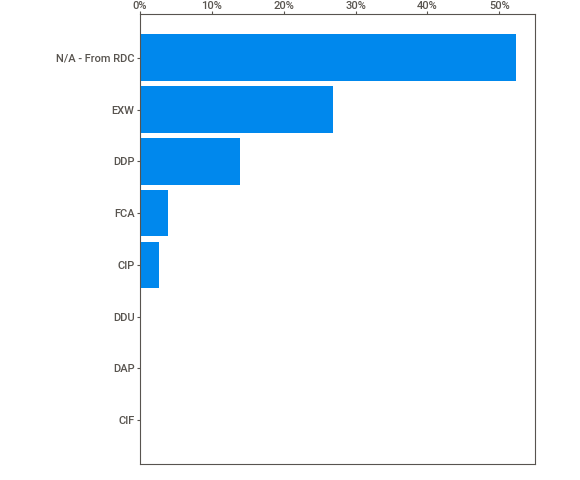
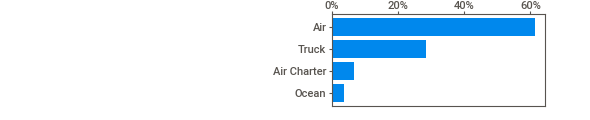
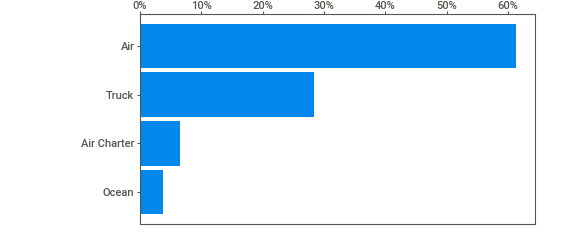
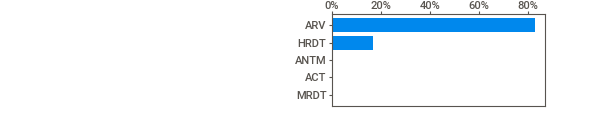
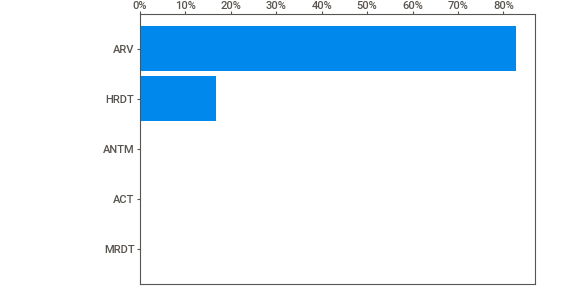
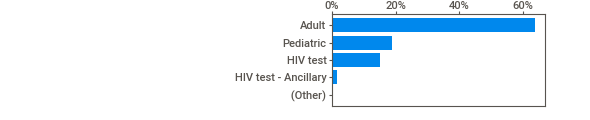
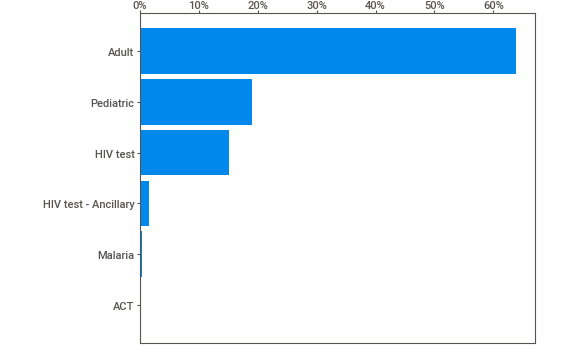
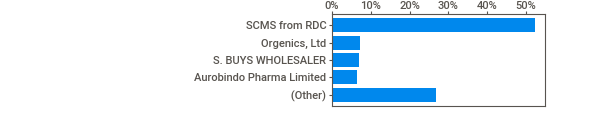
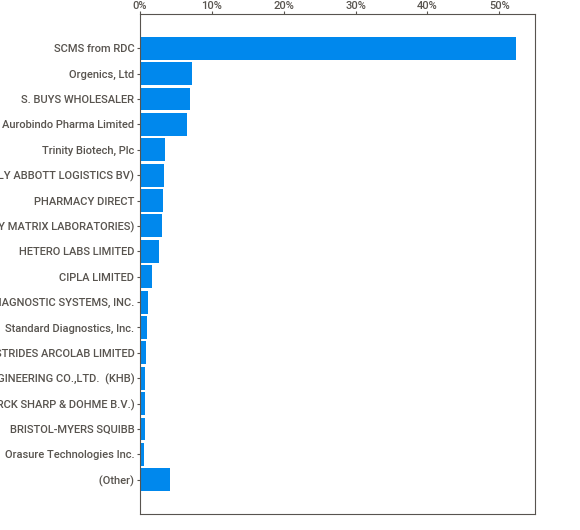
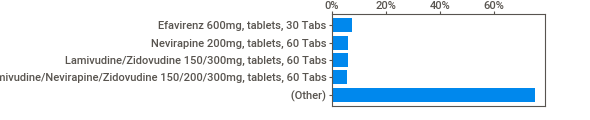
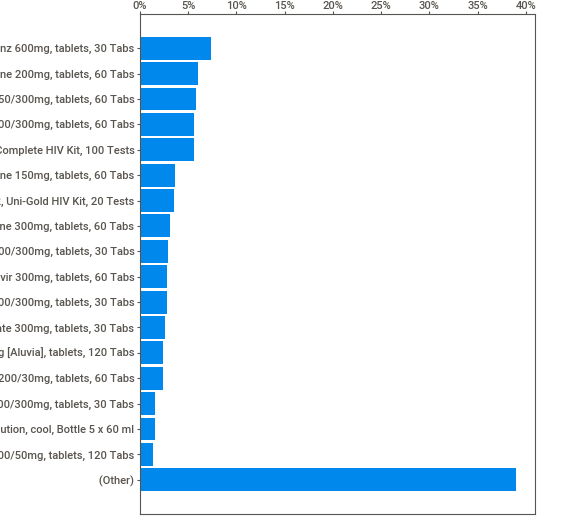
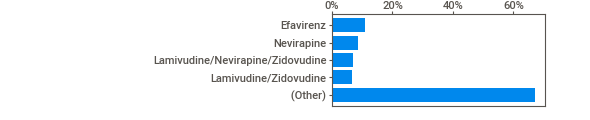
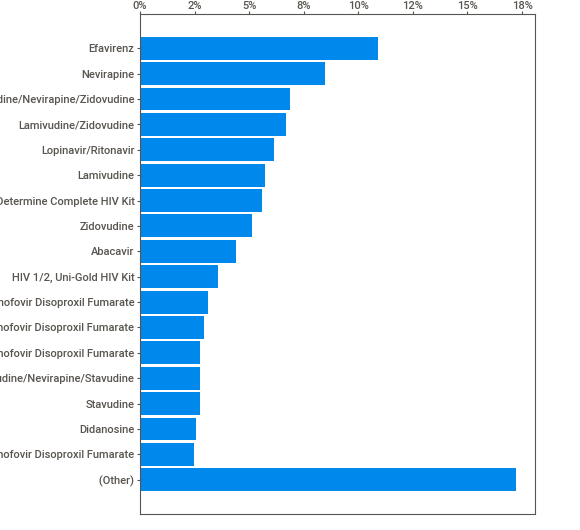
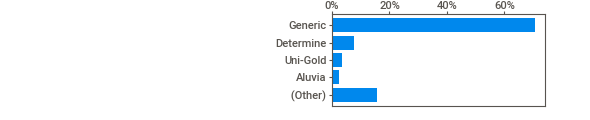
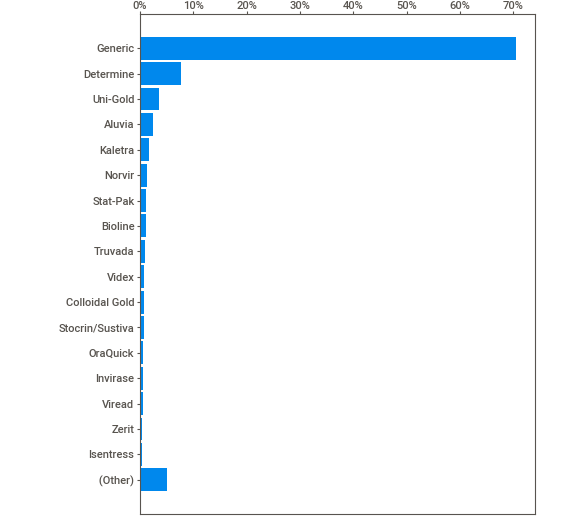
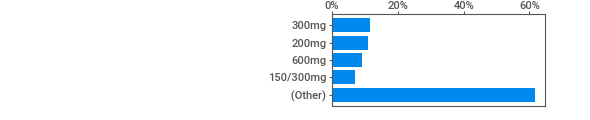
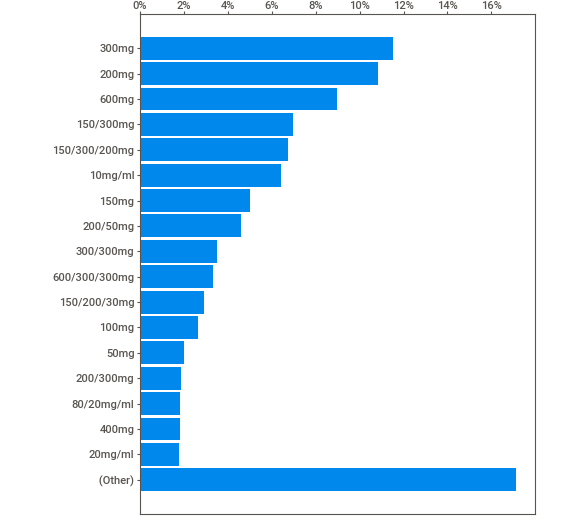
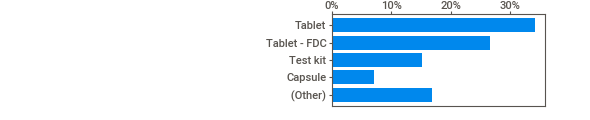
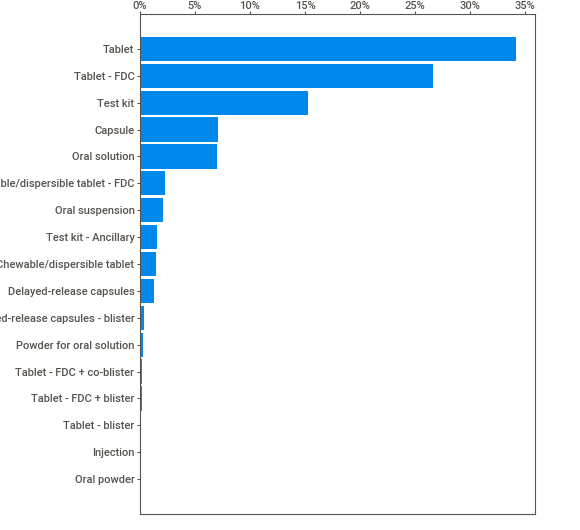
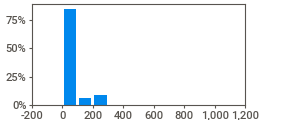
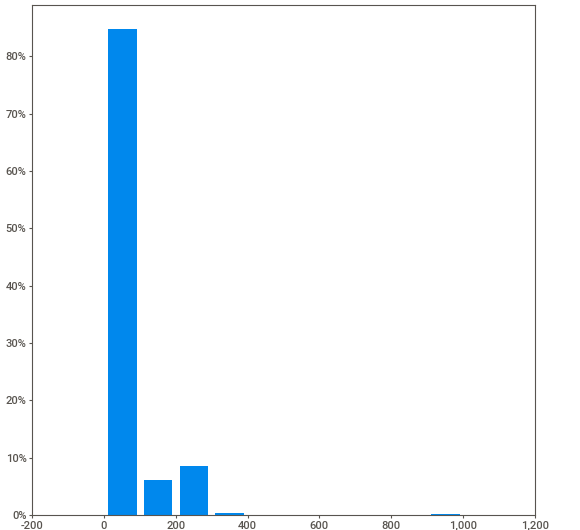
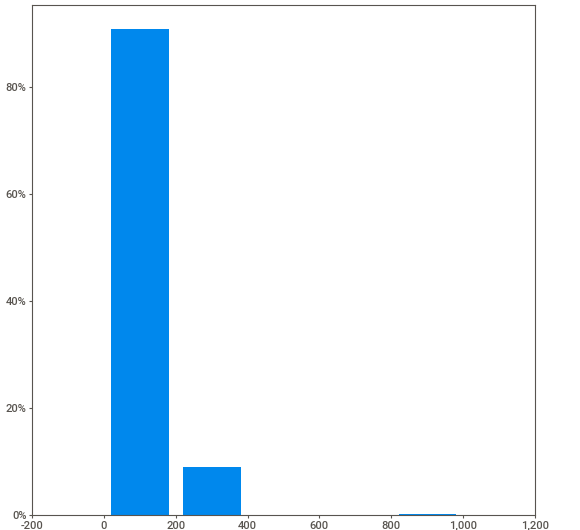
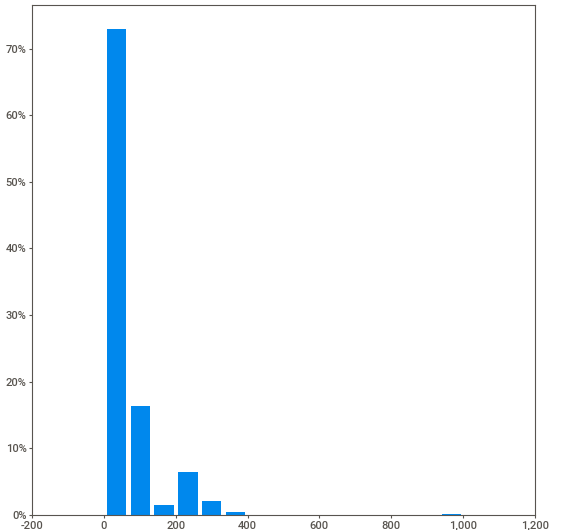
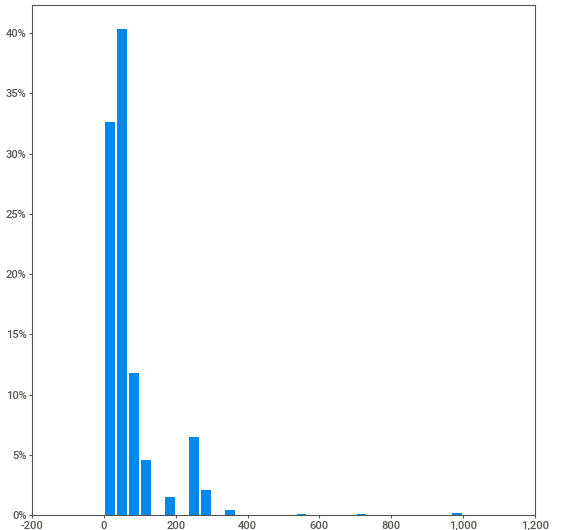
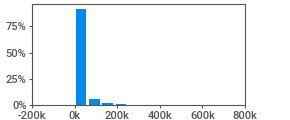
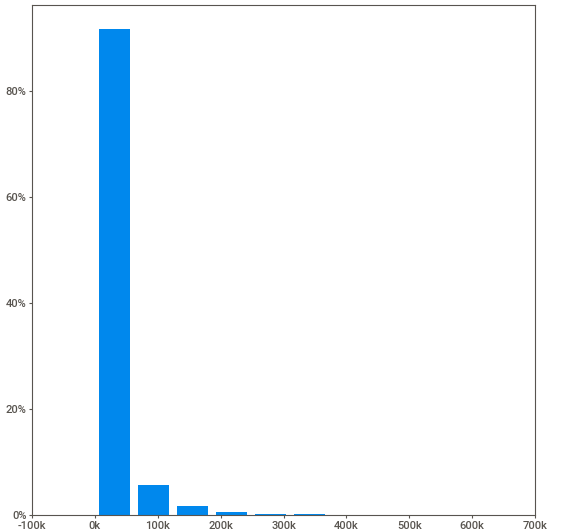
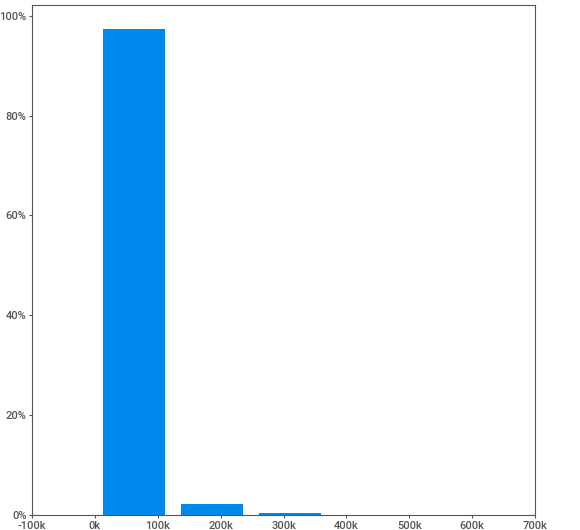
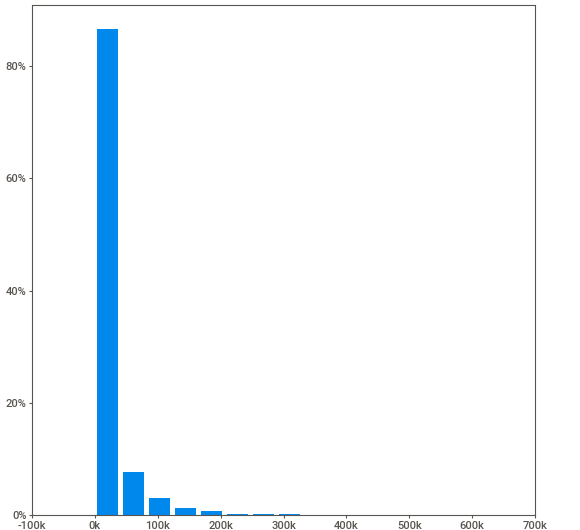
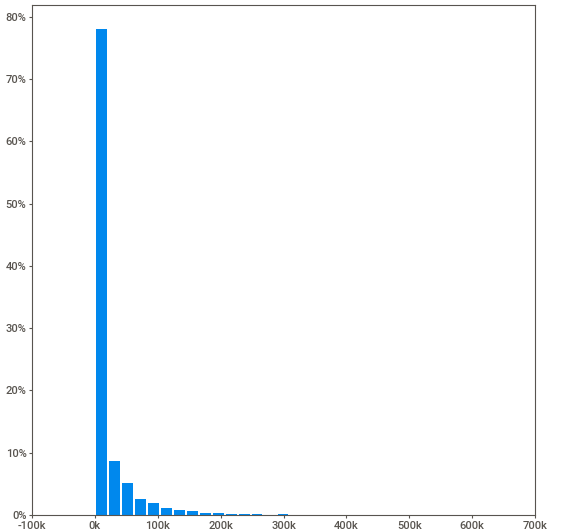
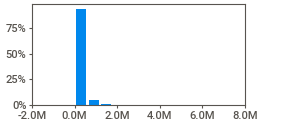
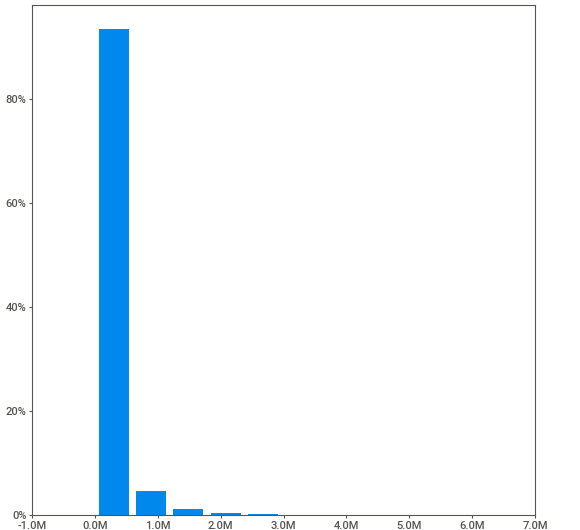
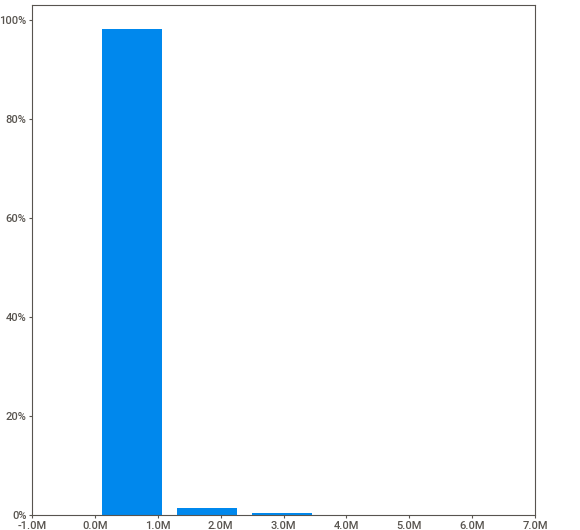
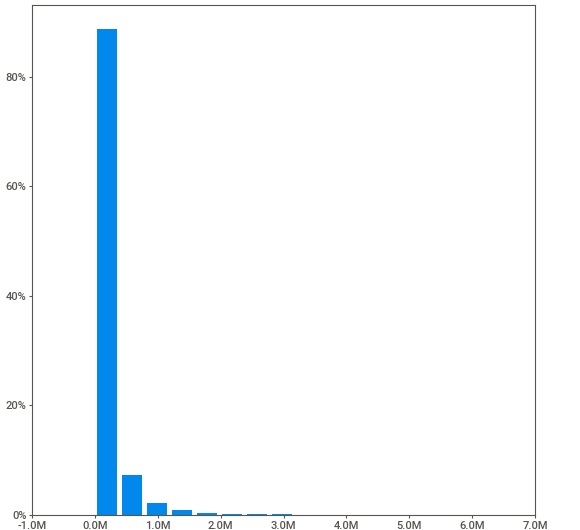
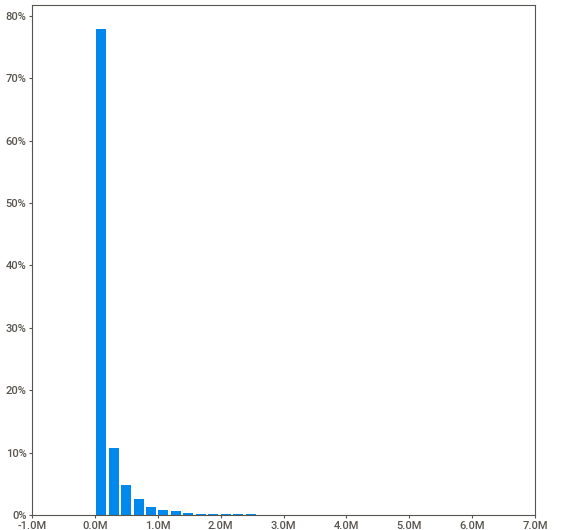
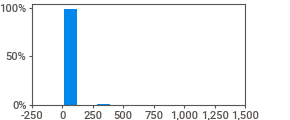
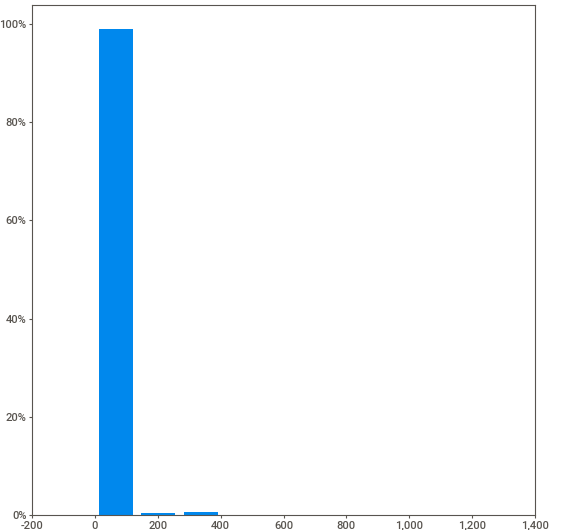
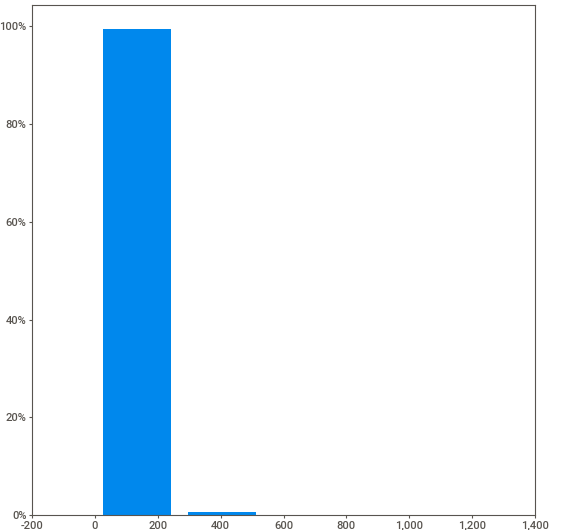
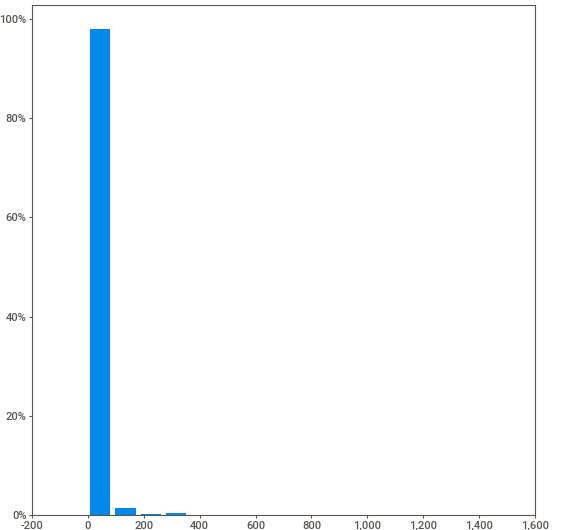
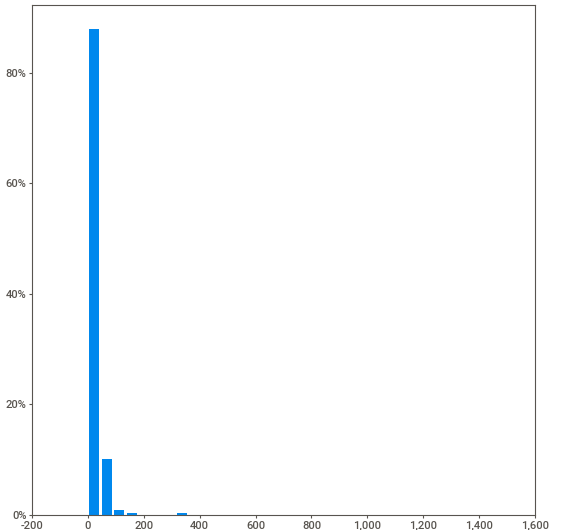
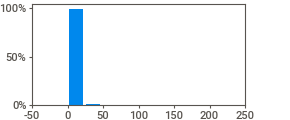
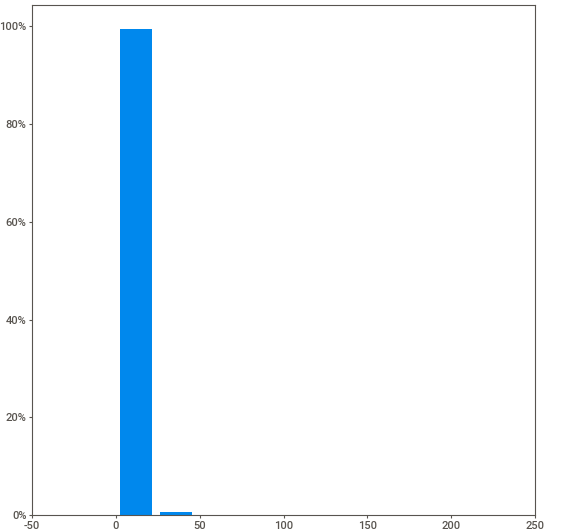
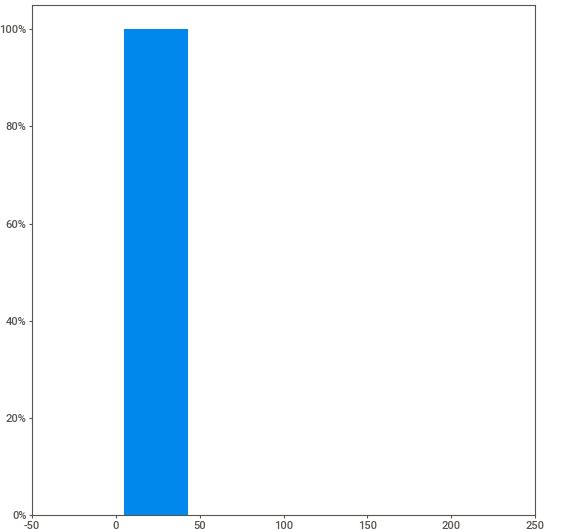
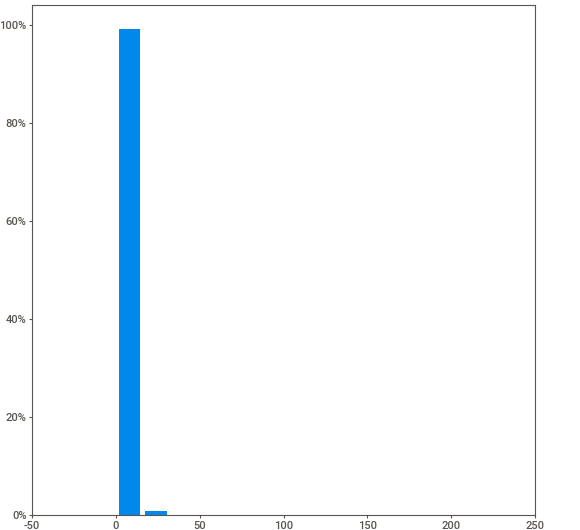
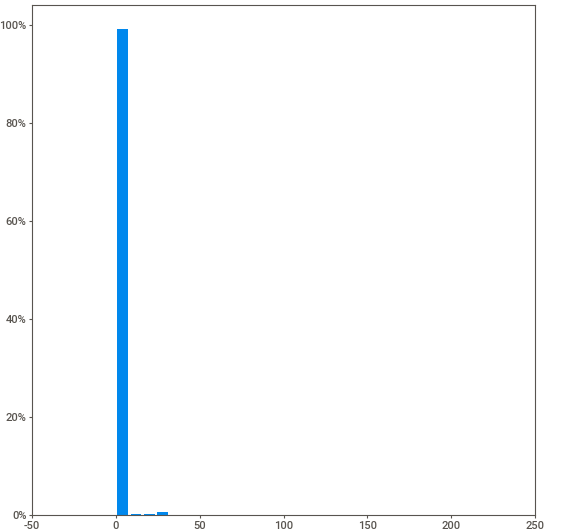
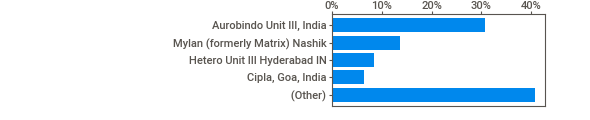
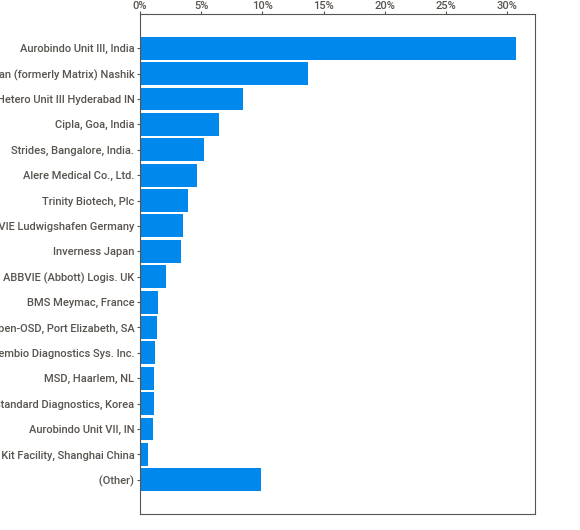
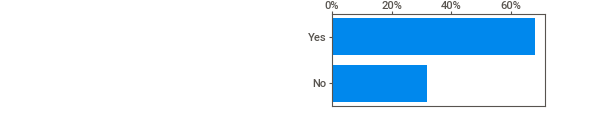
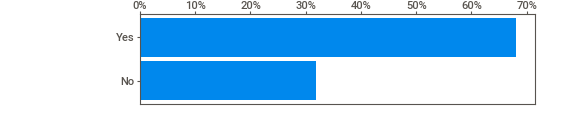
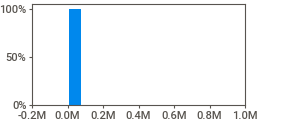
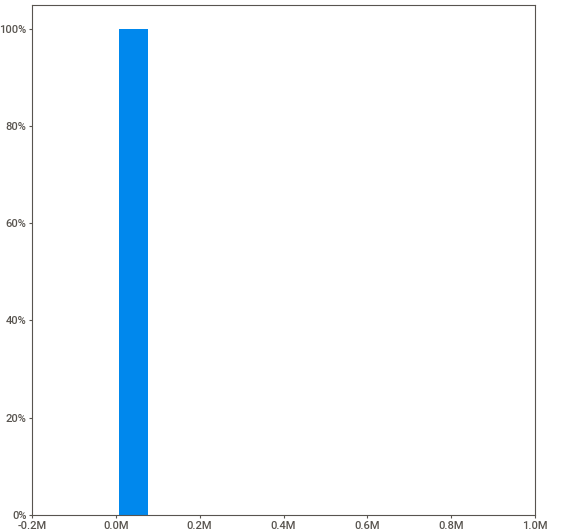
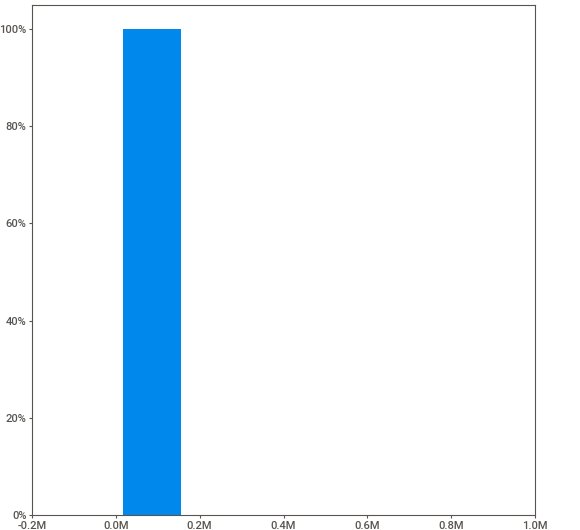
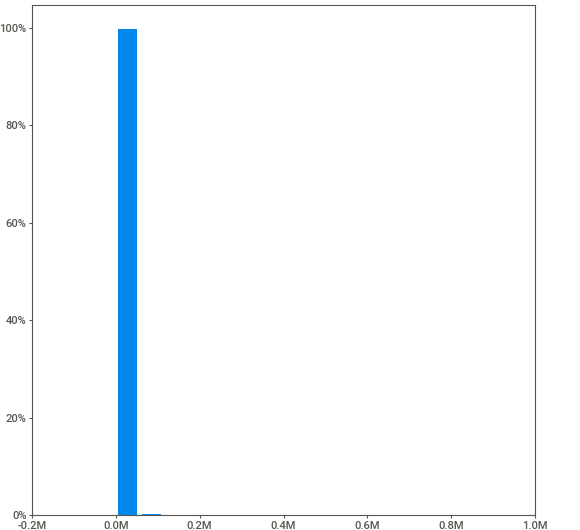
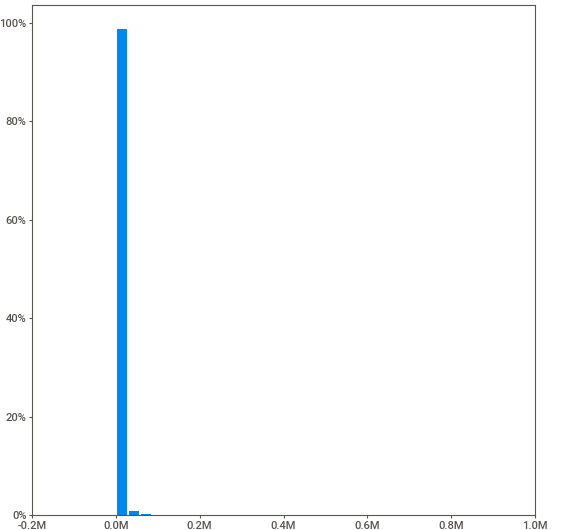
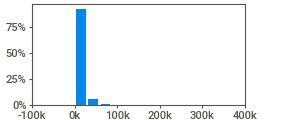
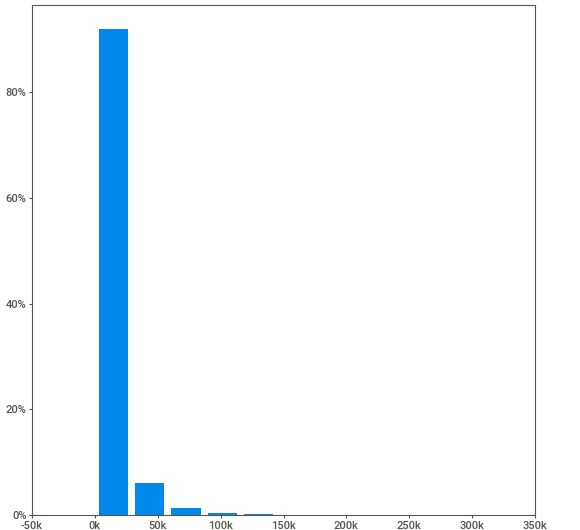
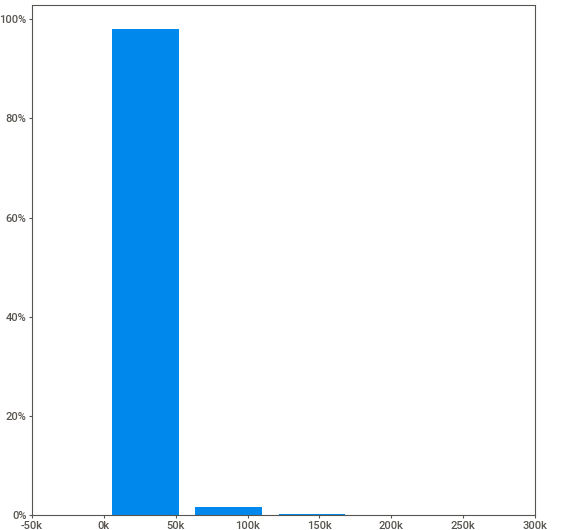
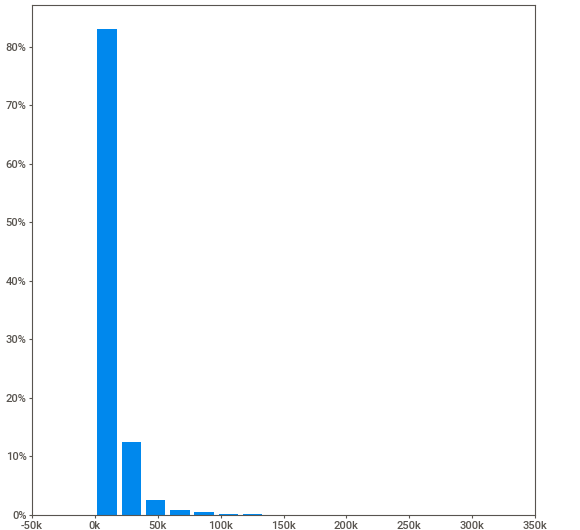
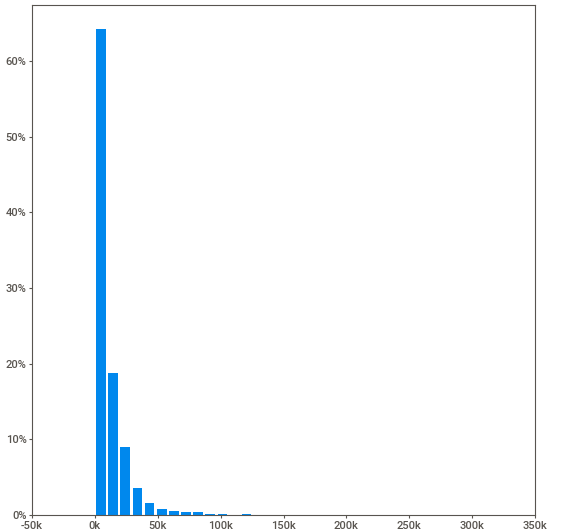
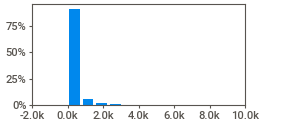
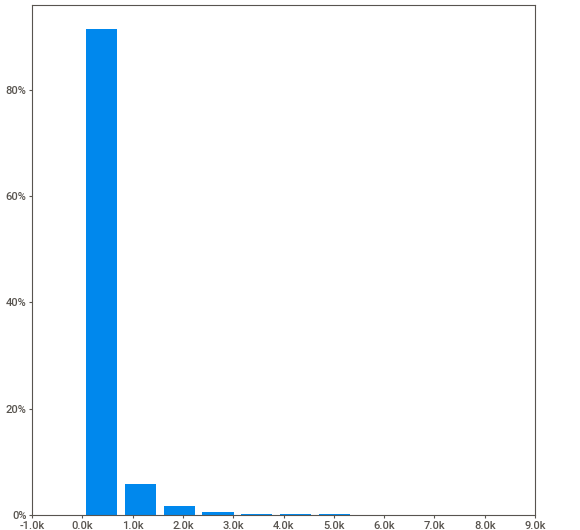
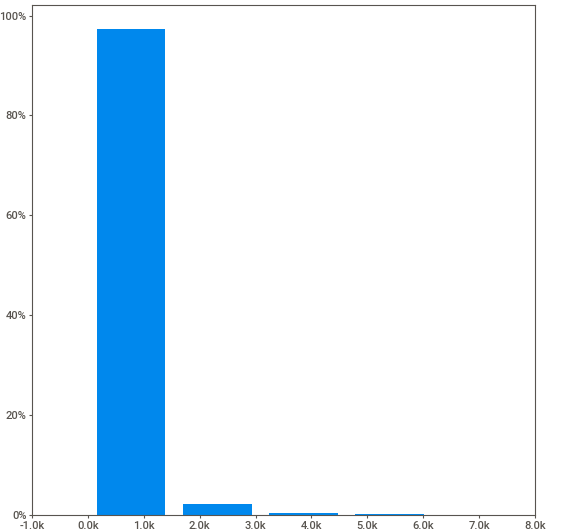
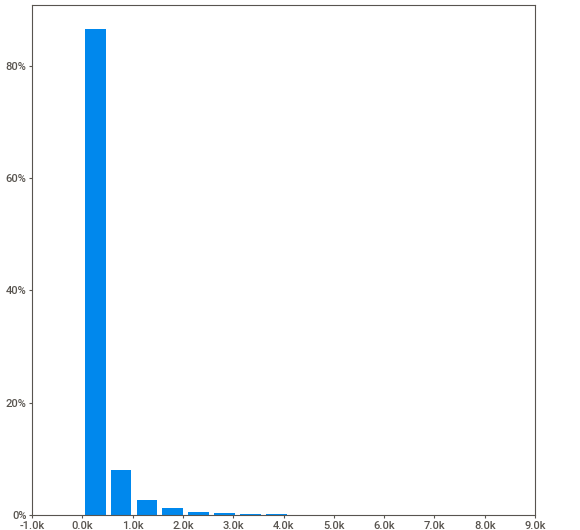
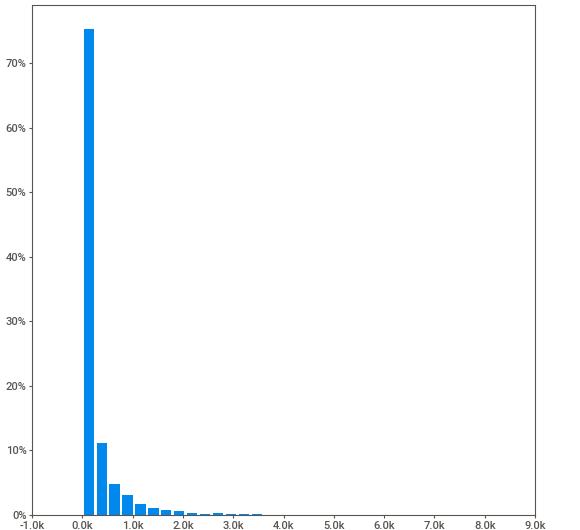
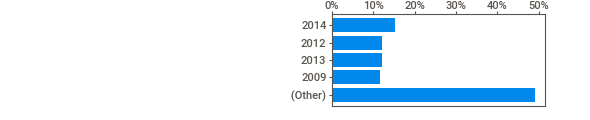
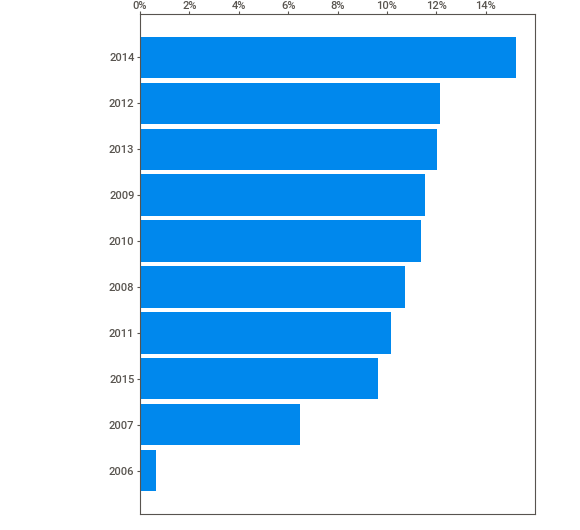
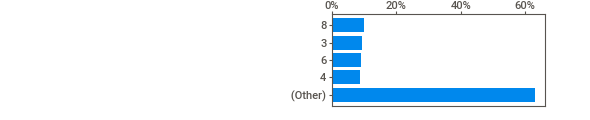
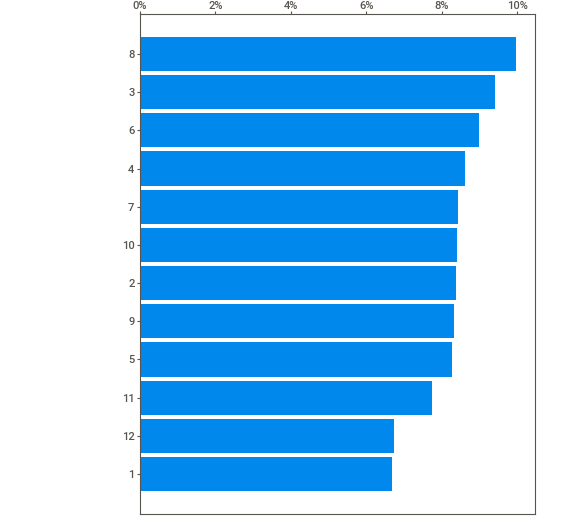
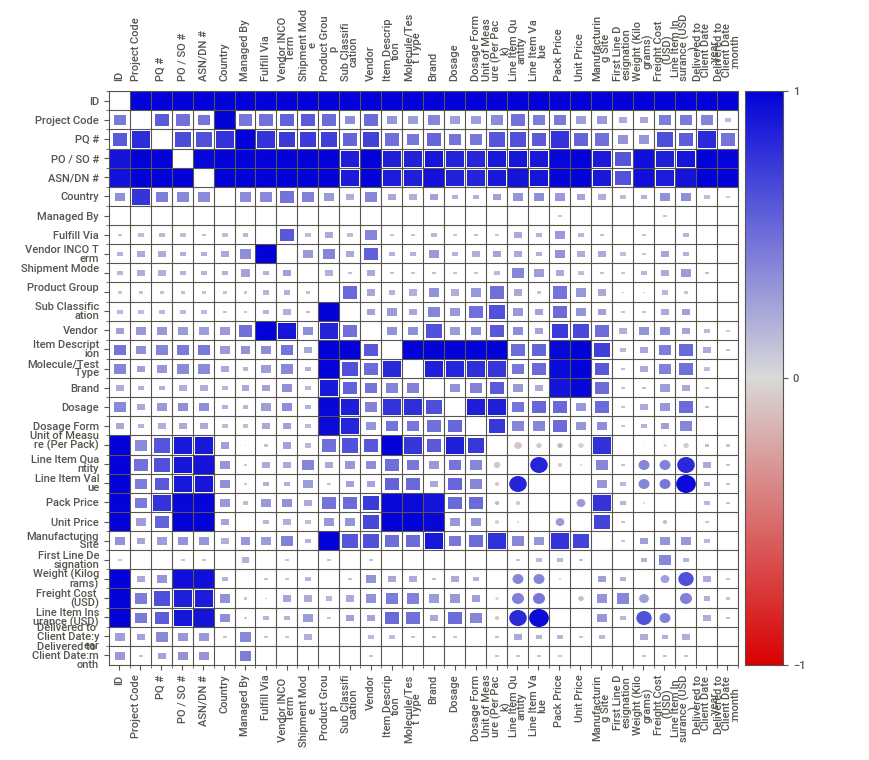
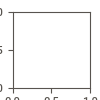

In [5]:
### 2
### Using df_2_converted

# We will run another SweetViz to both check columns, and also run feature selection 
converted_type_report = sv.analyze(df_2_converted)
converted_type_report.show_notebook()

In [6]:
### 2 -> 3
### Turns df_2_converted into df_3_grouped

# From SweetViz, we see some top associtions with feature 32, "Freight Cost (USD)"
    # Numerical Associations
        # 26 - Line Item Value
        # 25 - Line Item Quantity 
        # 33 - Line Item Insurance
        # 31 - Weight
        
        # All numerical values are pretty correlated with another, and also pretty correlated with Dosage and Molecule/Test Type
   
    # Categorical Associations
    # We ignore ID, ASN/DN #, PO / SO #, PQ #, and project Code because they are tied to individual shipments/unique values
        # 19 - Item Description               X Ignore, there are too many unique items and look like they can overfit the data
        # 20 - Molecule/Test Type             X Ignore, there are too many unique items and can overfit the data
        # 30 - First Line Designation         X Ignore, just flags multiline shipments
        # 18 - Vendor                         X Ignore, there are too many unique items and can overfit the data
        # 6 - Country                         Can experiment to see if it will overfit or not
        # 29 - Manufacturing Site             X Ignore, too many unique items that can overfit the data
        # 22 - Dosage                         X Ignore, is highly correlated with Molecule Test Type and Dosage Form, and has too many null values
        # 21 - Brand                          X Ignore, is highly correlated with Manufacturing Site and Molecule/Test Type
        # 23 - Dosage Form                    Although it's less correlated, it's highly correlated with Molecule/Test Type and Dosage, but less likely to overfit
        
        # Many Categorical values have too many unique values and are highly correlated to another, risking overfitting
            # I will experiment just with Country, and maybe Dosage Form should I need to
            # I will also include Shipment Mode despite it not having a high correlation based on a hunch that many higher correlations are overfitting

# We have way too many nulls in the data
    # This has to do with the Freight Costs where the shipping was free, or was a part of a multiline shipment
    # We'll group multiline shipments, and then drop null values
        
# Our features will take with us in our group by
group_by_features = [
                     "ASN/DN #",
                     "Weight (Kilograms)",
                     "Line Item Value",
                     "Line Item Insurance (USD)",
                     "Line Item Quantity",
                     "Country",
                     "Shipment Mode",
                     "Dosage Form",
                     "Freight Cost (USD)"
]

# We group by shipment number (ASN/DN #) to capture accurate sum of Freight Cost for multiline shipments
df_3_grouped = df_2_converted[group_by_features].copy()
df_3_grouped = df_3_grouped.groupby("ASN/DN #").agg({
    "Weight (Kilograms)": "sum",
    "Line Item Value" : "sum",
    "Line Item Insurance (USD)" : "sum",
    "Line Item Quantity" : "sum",
    "Country" : "first",
    "Shipment Mode" : "first",
    "Dosage Form" : "first",
    "Freight Cost (USD)" : "sum"
})
df_3_grouped



Weight (Kilograms)  Line Item Value  Line Item Insurance (USD)  \
ASN/DN #                                                                    
ASN-10006                94.0          1900.00                       3.14   
ASN-10007                43.0          3970.00                       6.55   
ASN-10011                 0.0        120240.00                     259.24   
ASN-10012                 0.0        400800.00                     864.12   
ASN-10062               453.0        195360.00                     322.34   
...                       ...              ...                        ...   
DN-995                   26.0          1450.00                       2.84   
DN-996                  501.0         50274.95                      98.54   
DN-997                 3720.0         21000.00                      41.16   
DN-998                  585.0         64690.60                     126.79   
DN-999                  671.0          3780.00                       7.41   

           Line Item Quantity       Country Shipment Mode  \
ASN/DN #                                                    
ASN-10006                 200         Haiti           Air   
ASN-10007                 460         Haiti           Air   
ASN-10011               12000  South Africa           Air   
ASN-10012               40000  South Africa           Air   
ASN-10062                2000         Haiti           Air   
...                       ...           ...           ...   
DN-995                    500        Uganda           Air   
DN-996                   5377        Uganda           Air   
DN-997                  10000         Haiti           Air   
DN-998                   7670        Uganda         Truck   
DN-999                   1800        Zambia           Air   

                           Dosage Form  Freight Cost (USD)  
ASN/DN #                                                    
ASN-10006  Chewable/dispersible tablet              757.42  
ASN-10007  Chewable/dispersible tablet             1082.89  
ASN-10011                Oral solution            12474.06  
ASN-10012                Oral solution            11770.87  
ASN-10062                     Test kit             7030.94  
...                                ...                 ...  
DN-995                          Tablet             1096.71  
DN-996                    Tablet - FDC             3266.38  
DN-997                   Oral solution            43704.80  
DN-998                          Tablet             5698.01  
DN-999                   Oral solution             5110.76  

[7030 rows x 8 columns]

In [7]:
### 3 -> 4
### Turns df_3_grouped into df_4_drop0

# We can now drop nulls and where Freight Cost (USD) = 0 in the data
df_4_drop0 = df_3_grouped.dropna()
df_4_drop0 = df_4_drop0[df_4_drop0["Freight Cost (USD)"] != 0]
df_4_drop0 = df_4_drop0[df_4_drop0["Weight (Kilograms)"] != 0]
df_4_drop0 = df_4_drop0[df_4_drop0["Line Item Value"] != 0]
df_4_drop0 = df_4_drop0[df_4_drop0["Line Item Quantity"] != 0]
df_4_drop0 = df_4_drop0[df_4_drop0["Line Item Insurance (USD)"] != 0]
df_4_drop0

Weight (Kilograms)  Line Item Value  Line Item Insurance (USD)  \
ASN/DN #                                                                    
ASN-10006                94.0          1900.00                       3.14   
ASN-10007                43.0          3970.00                       6.55   
ASN-10062               453.0        195360.00                     322.34   
ASN-10063                 8.0          3223.44                       5.32   
ASN-10064               205.0         41800.00                      68.97   
...                       ...              ...                        ...   
DN-995                   26.0          1450.00                       2.84   
DN-996                  501.0         50274.95                      98.54   
DN-997                 3720.0         21000.00                      41.16   
DN-998                  585.0         64690.60                     126.79   
DN-999                  671.0          3780.00                       7.41   

           Line Item Quantity Country Shipment Mode  \
ASN/DN #                                              
ASN-10006                 200   Haiti           Air   
ASN-10007                 460   Haiti           Air   
ASN-10062                2000   Haiti           Air   
ASN-10063                  33   Haiti           Air   
ASN-10064                 418  Guyana           Air   
...                       ...     ...           ...   
DN-995                    500  Uganda           Air   
DN-996                   5377  Uganda           Air   
DN-997                  10000   Haiti           Air   
DN-998                   7670  Uganda         Truck   
DN-999                   1800  Zambia           Air   

                           Dosage Form  Freight Cost (USD)  
ASN/DN #                                                    
ASN-10006  Chewable/dispersible tablet              757.42  
ASN-10007  Chewable/dispersible tablet             1082.89  
ASN-10062                     Test kit             7030.94  
ASN-10063                     Test kit             1011.60  
ASN-10064                     Test kit             6455.37  
...                                ...                 ...  
DN-995                          Tablet             1096.71  
DN-996                    Tablet - FDC             3266.38  
DN-997                   Oral solution            43704.80  
DN-998                          Tablet             5698.01  
DN-999                   Oral solution             5110.76  

[5836 rows x 8 columns]

                                             |    | [  0%]   00:00 -> (? left)


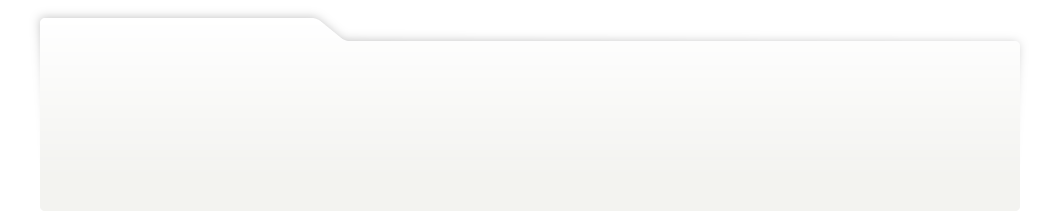
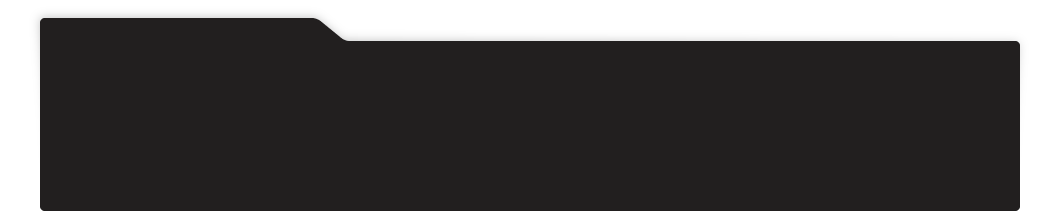
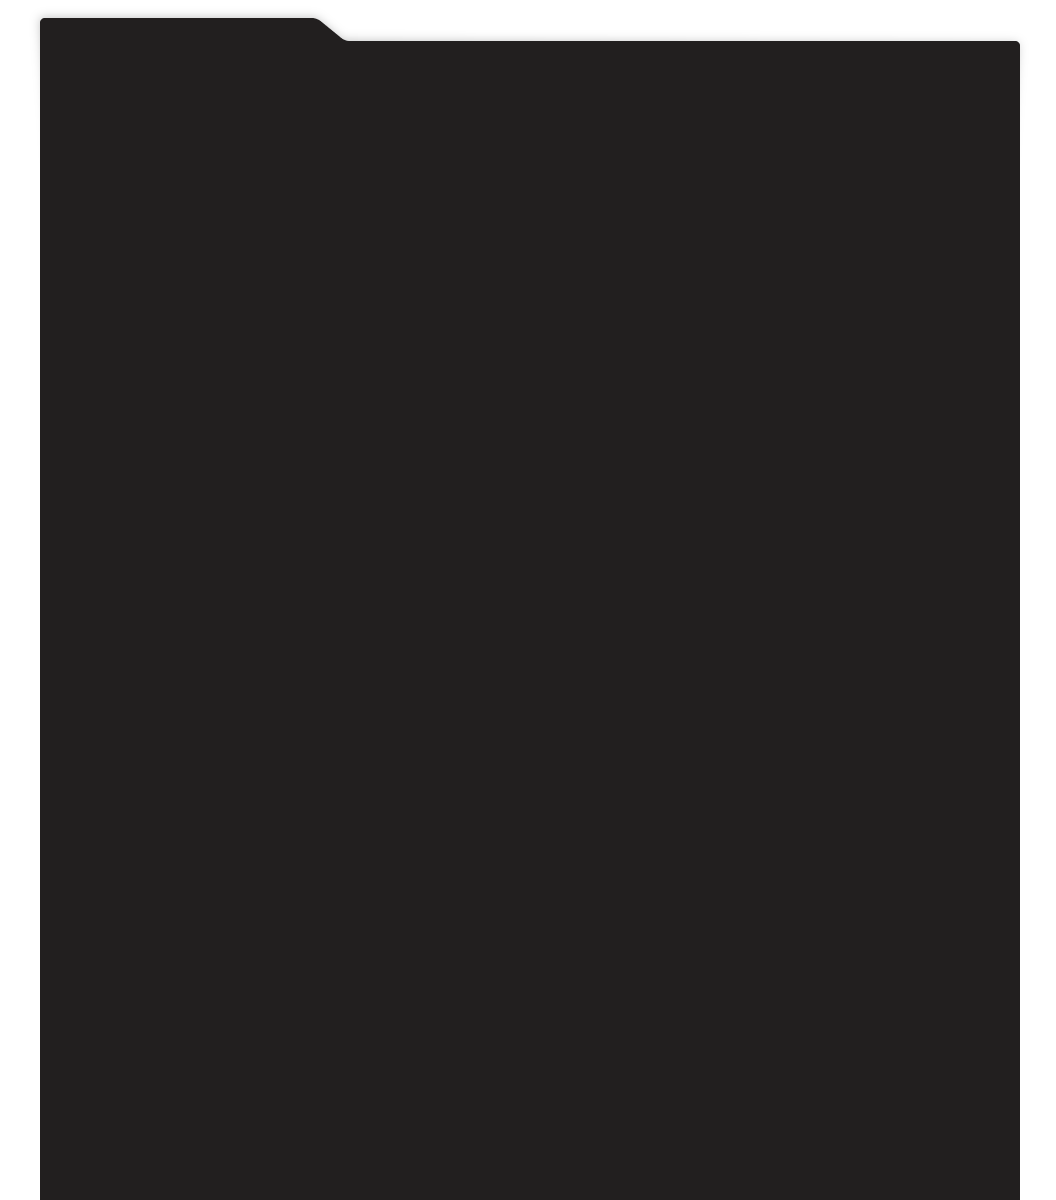
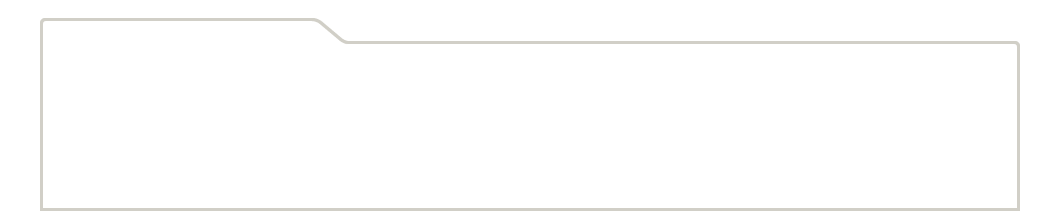
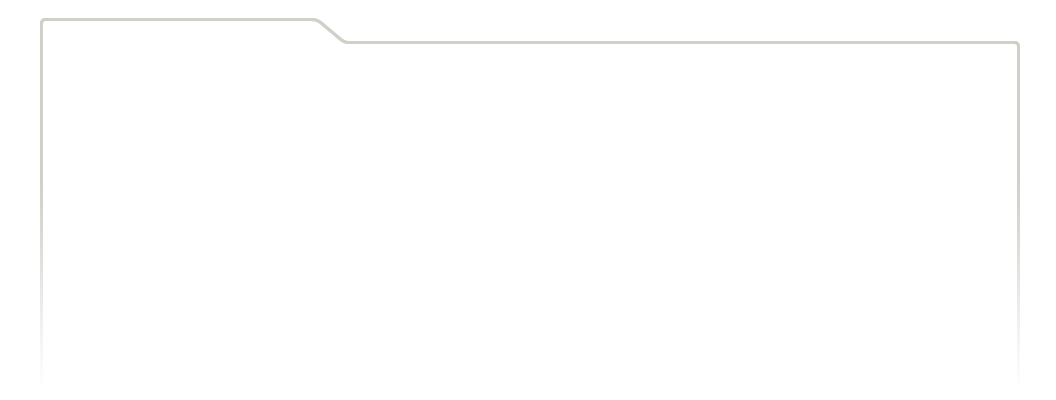
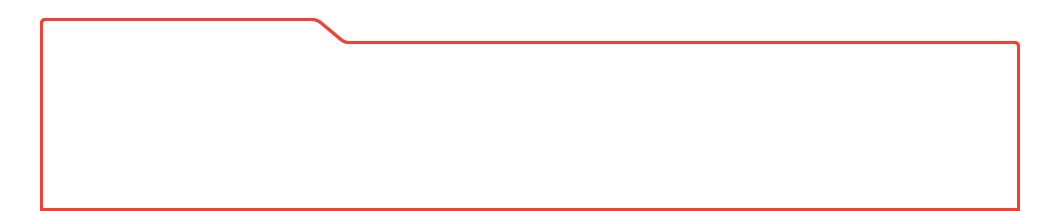
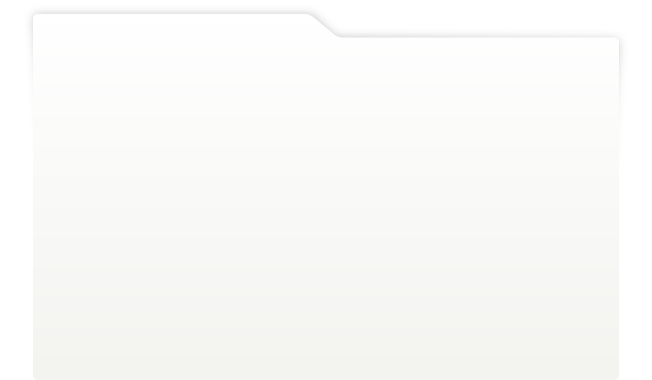
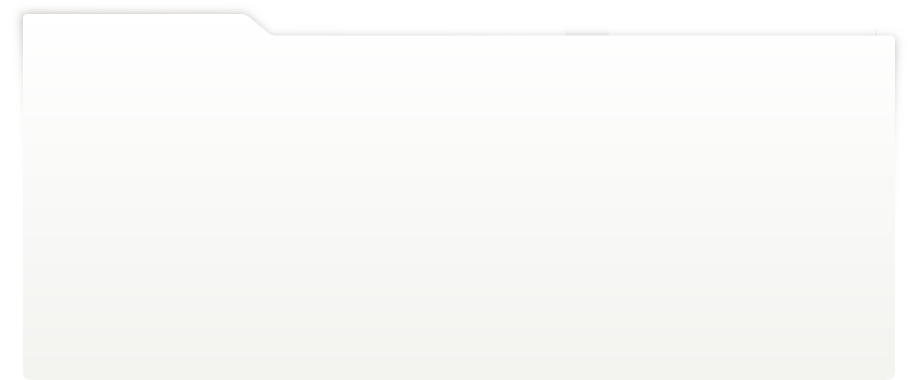
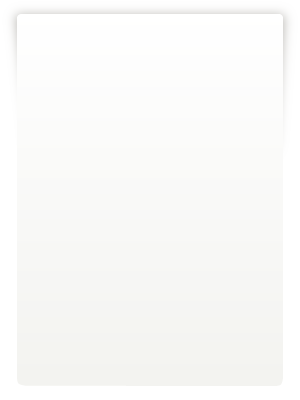
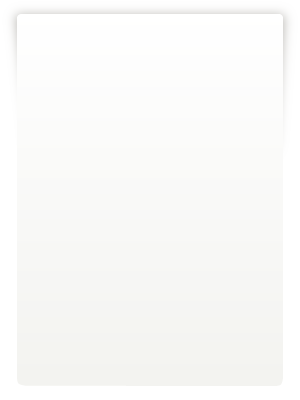
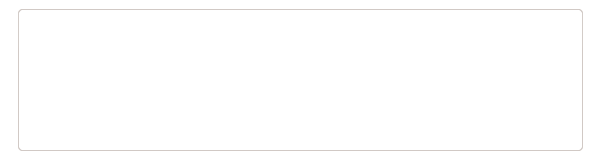
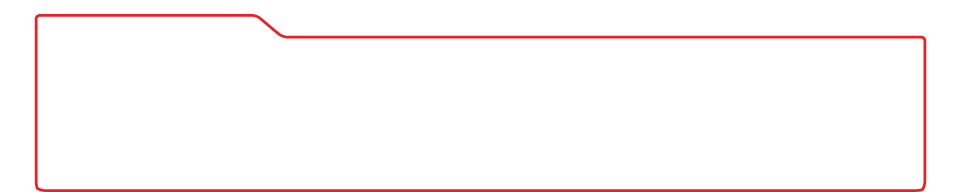
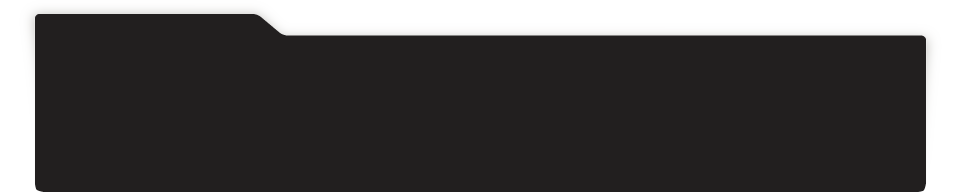
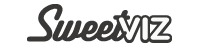
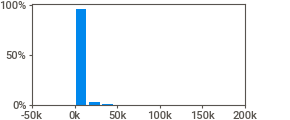
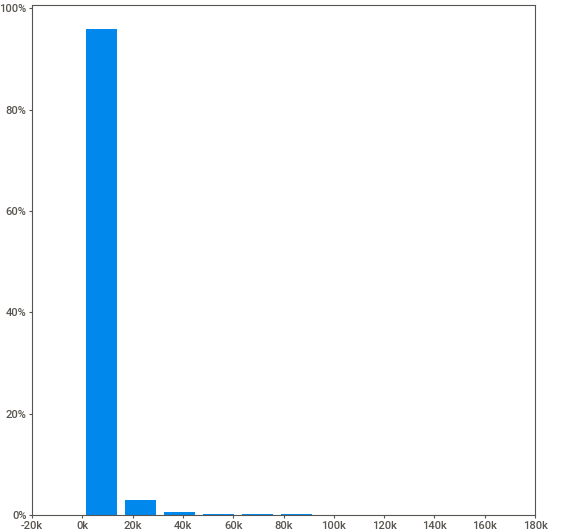
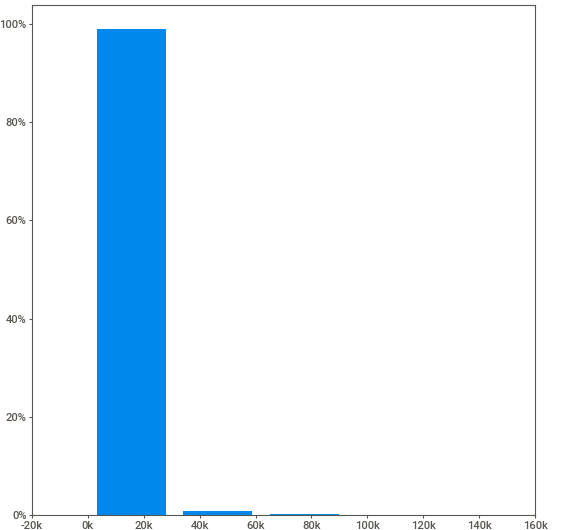
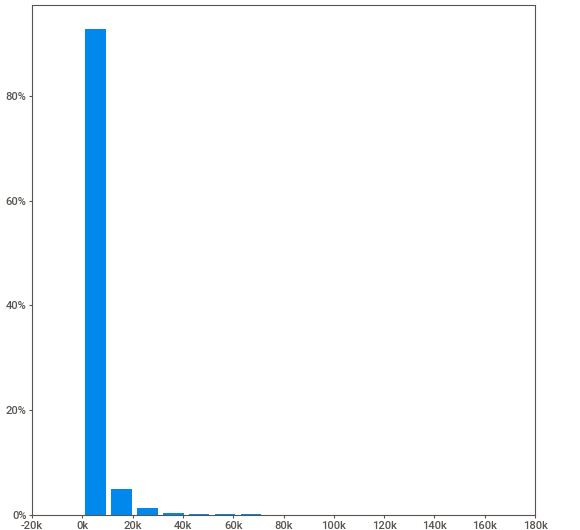
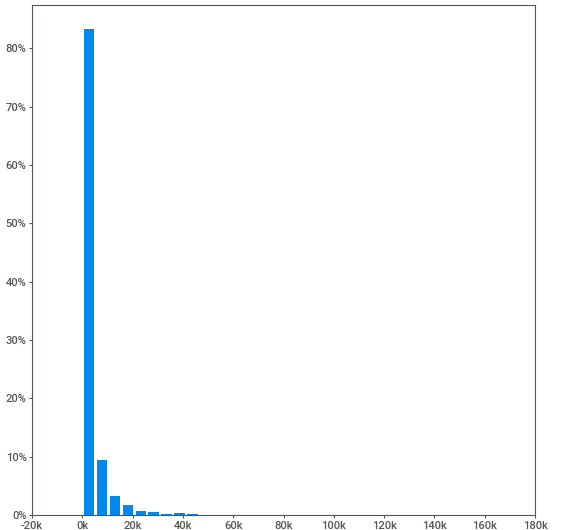
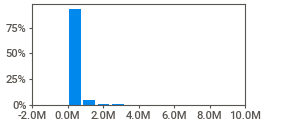
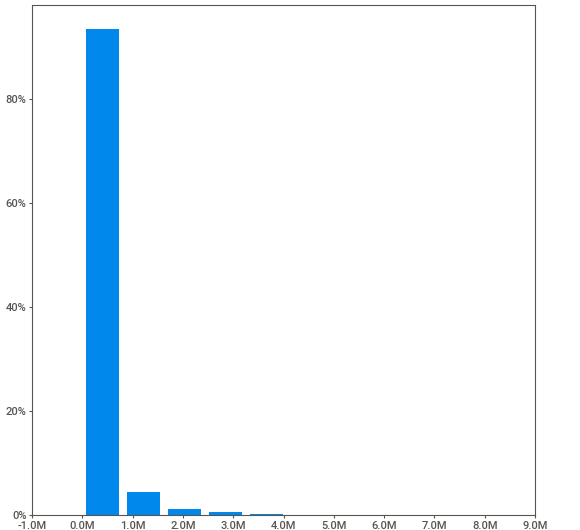
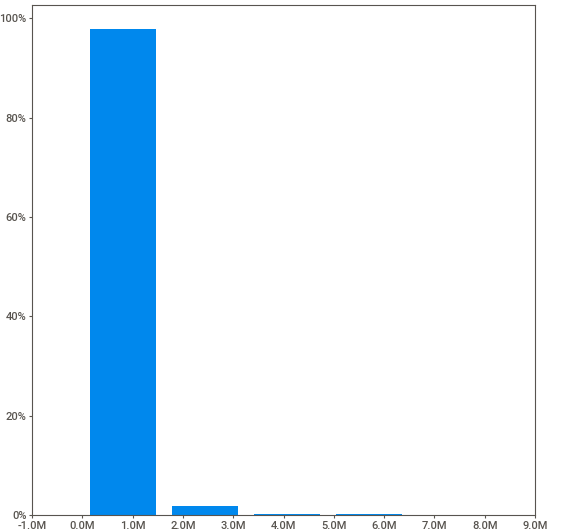
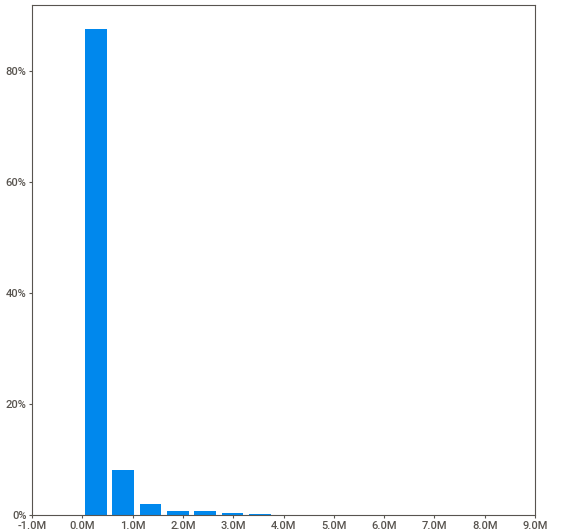
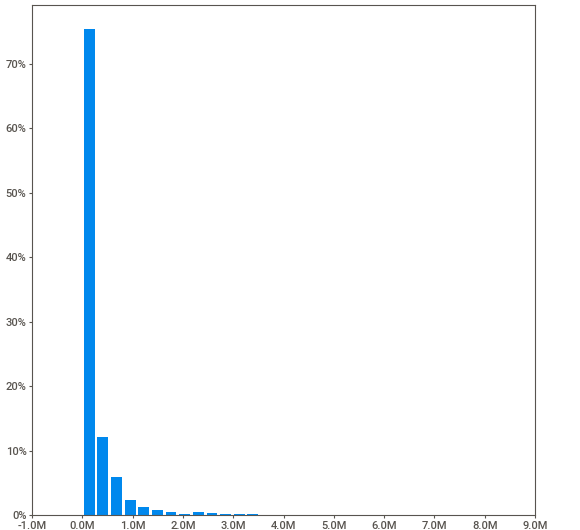
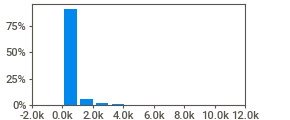
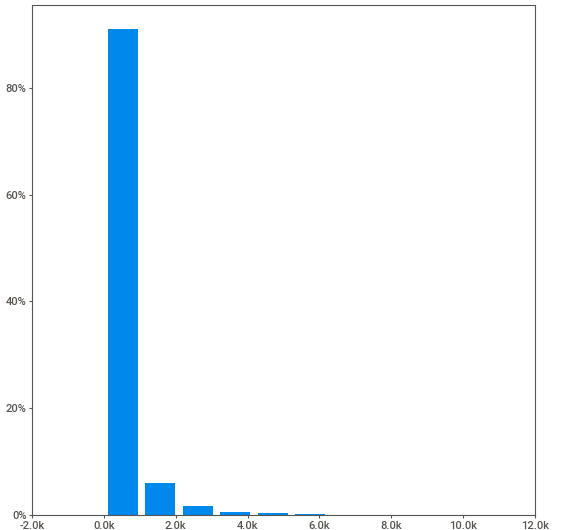
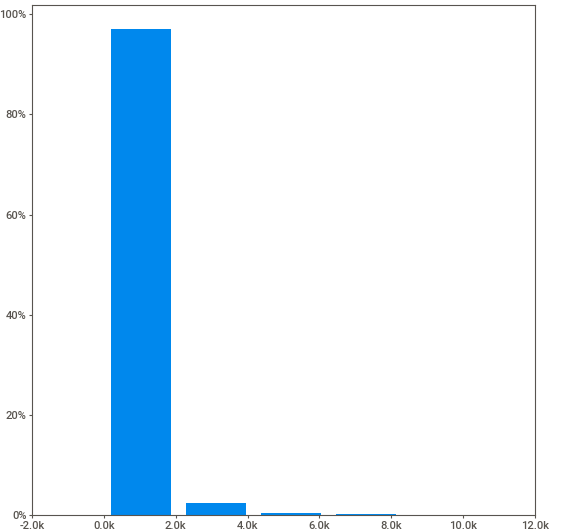
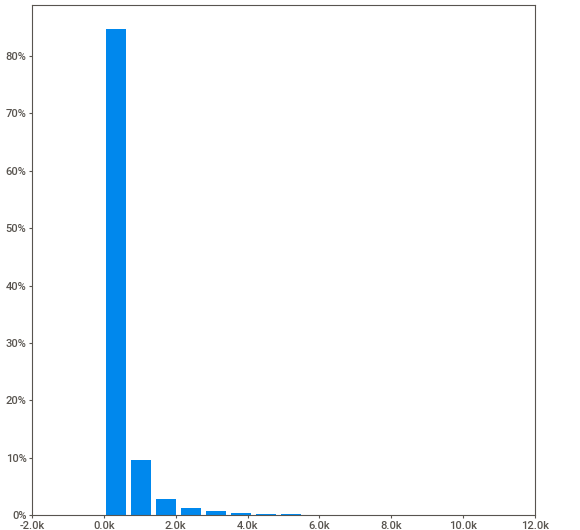
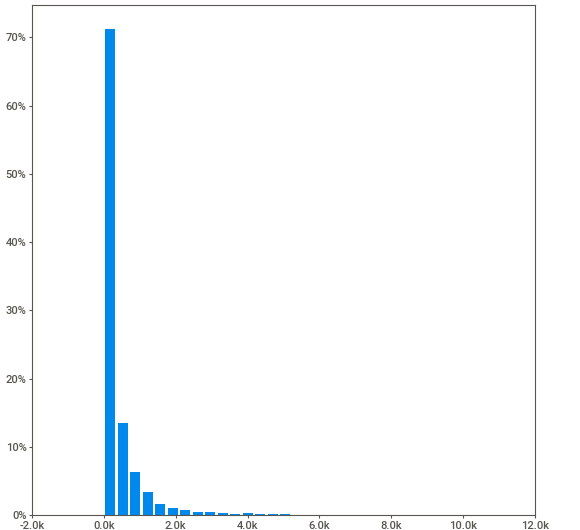
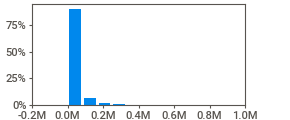
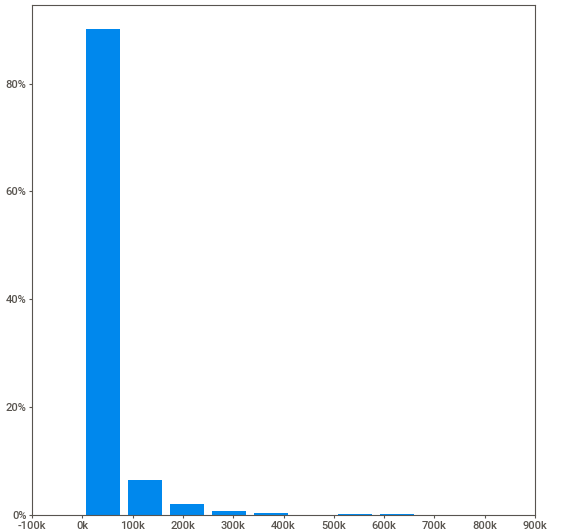
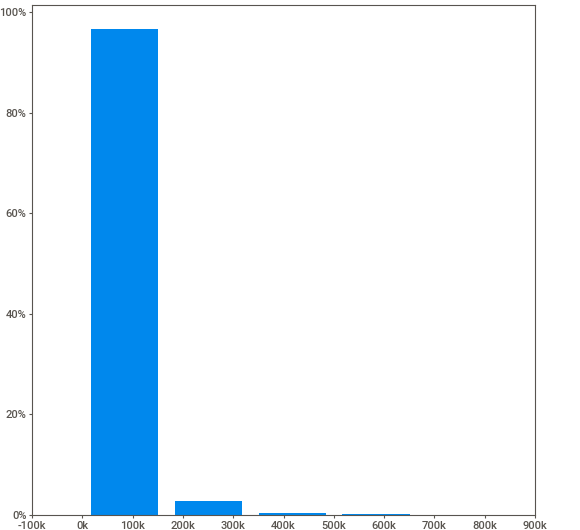
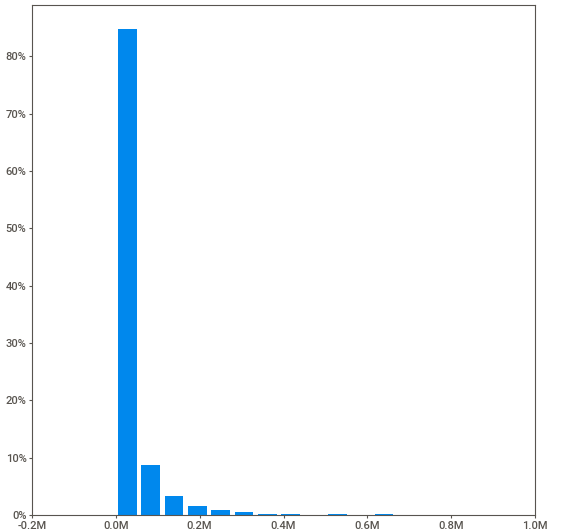
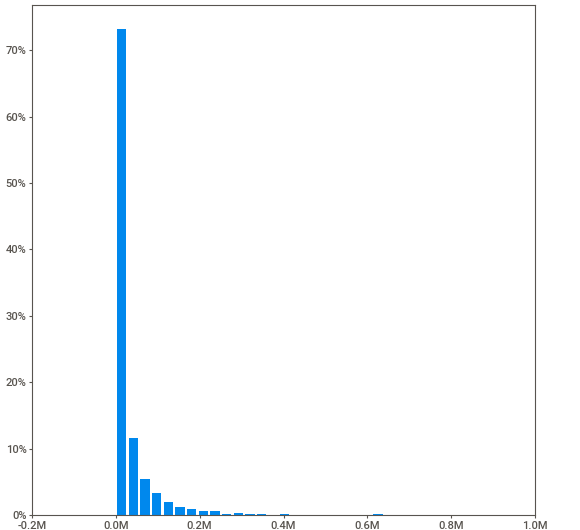
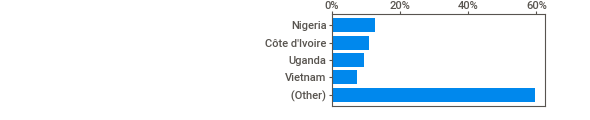
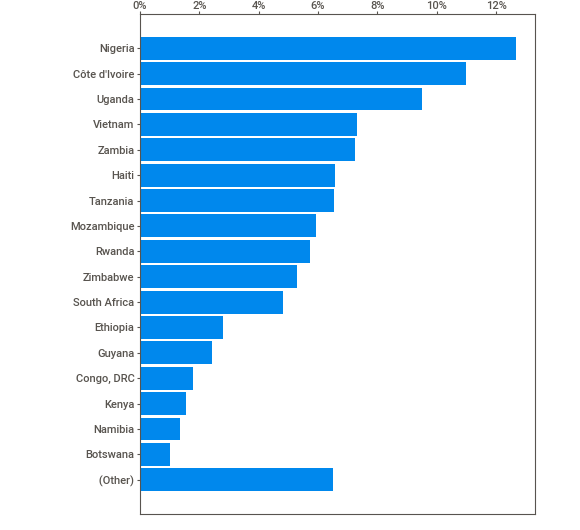
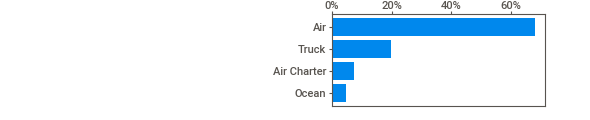
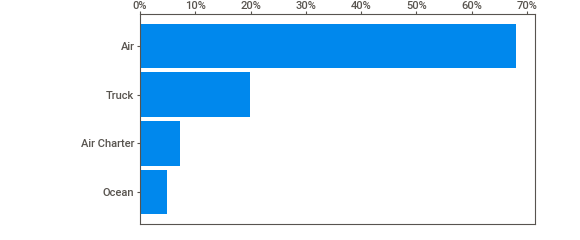
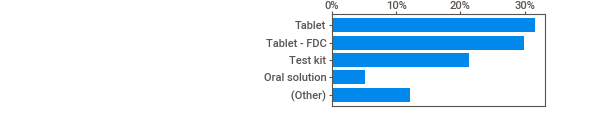
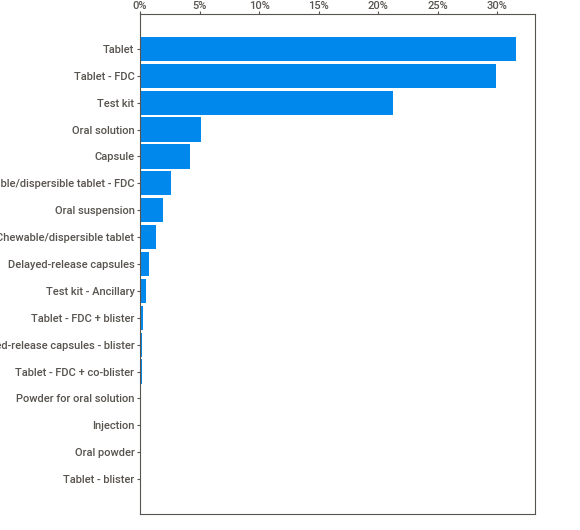
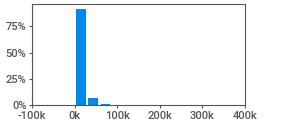
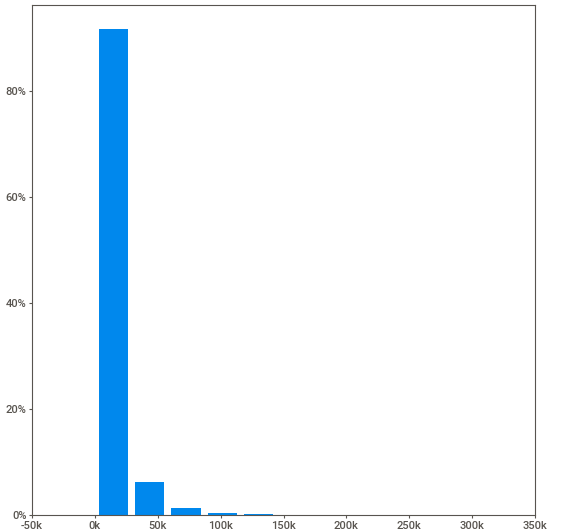
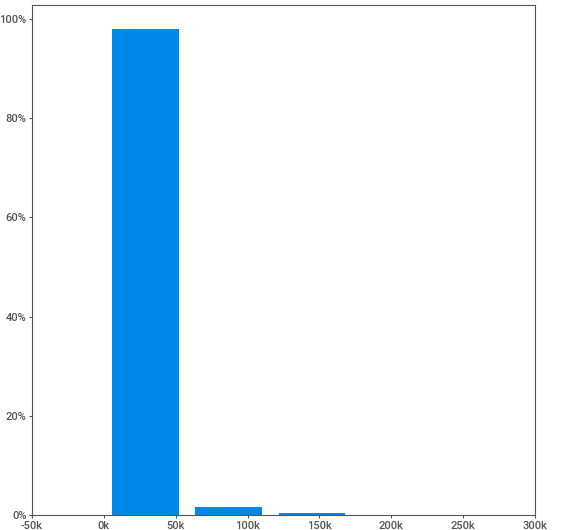
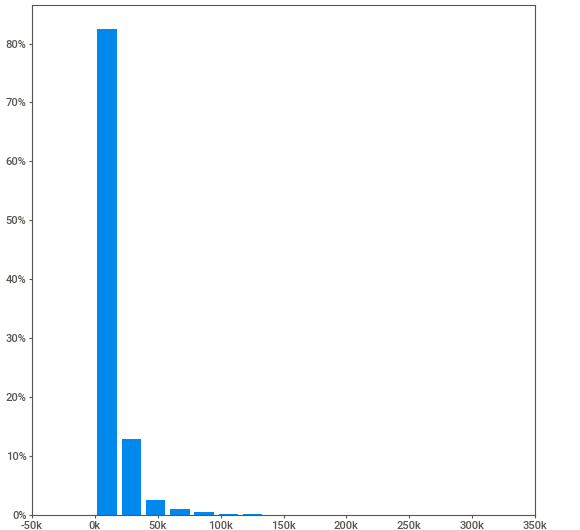
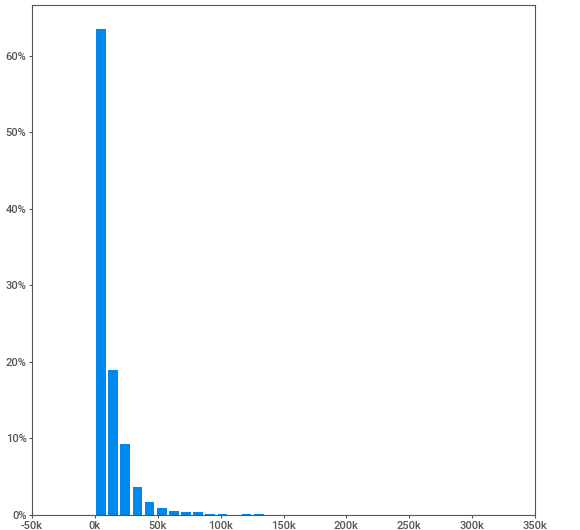
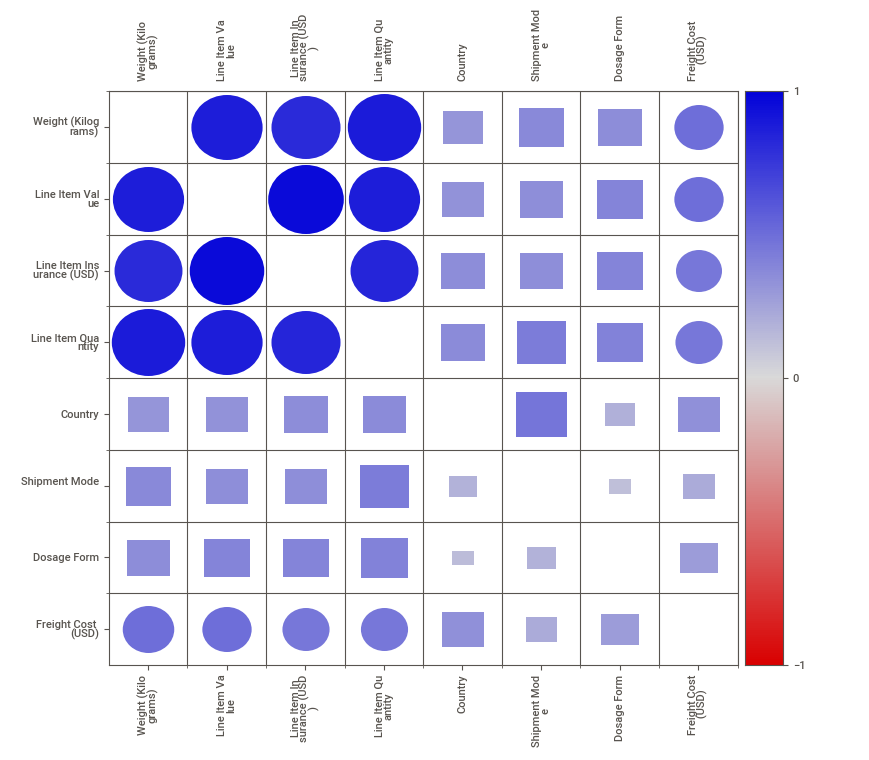
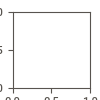

In [8]:
### 4
### df_4_drop0

# We will run another SweetViz on our cleaned dataset
cleaned_data_report = sv.analyze(df_4_drop0)
cleaned_data_report.show_notebook()

                                             |    | [  0%]   00:00 -> (? left)


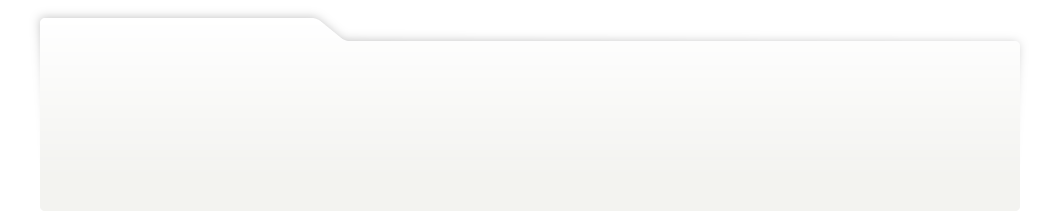
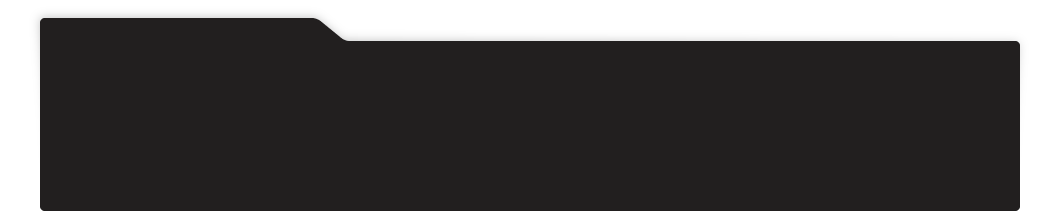
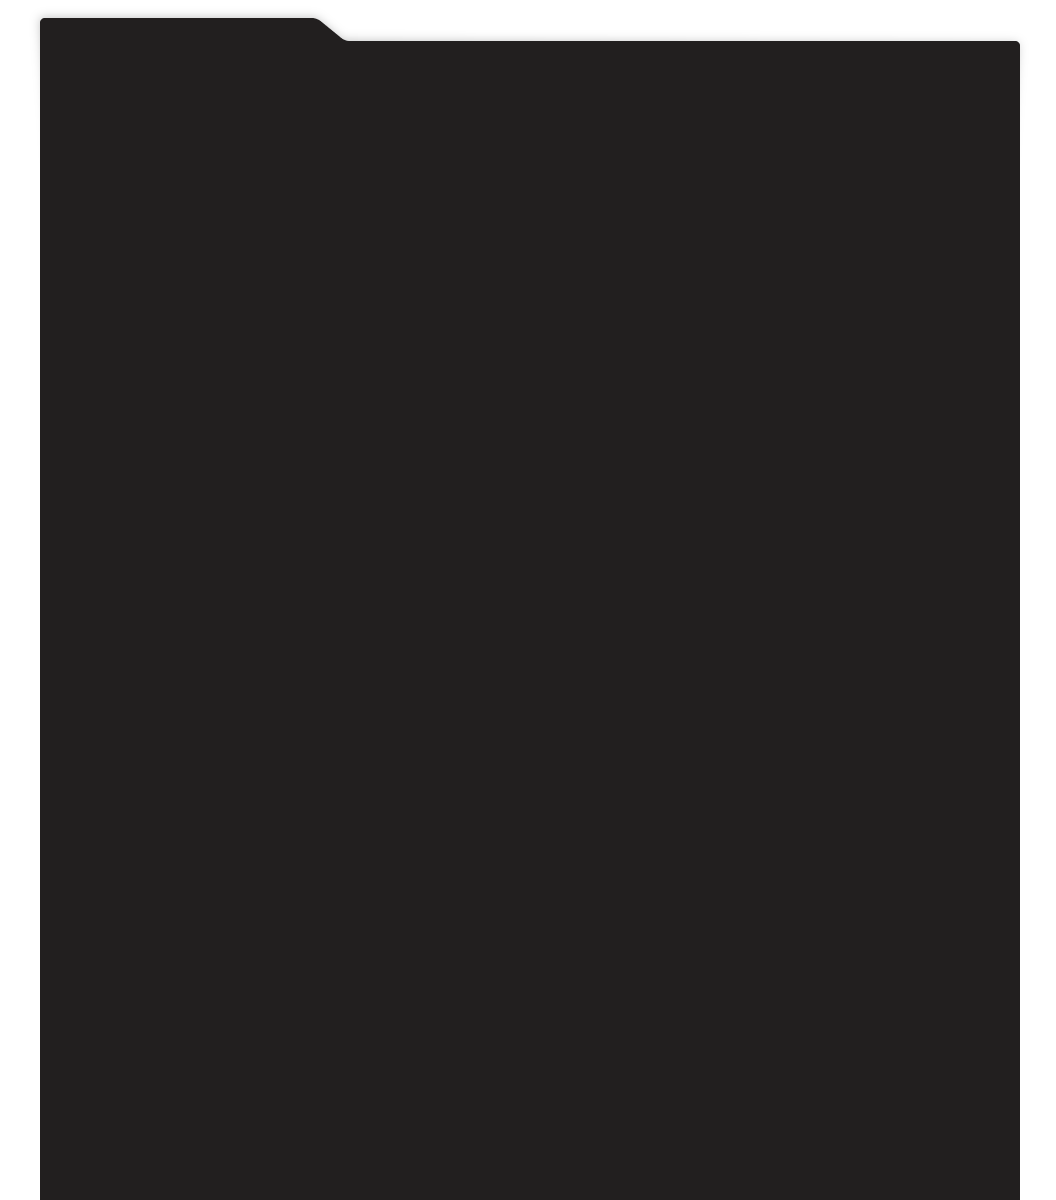
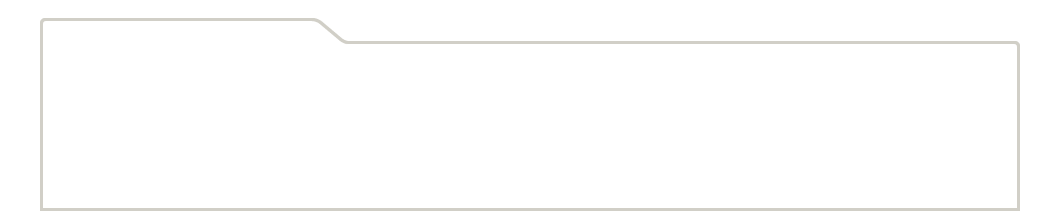
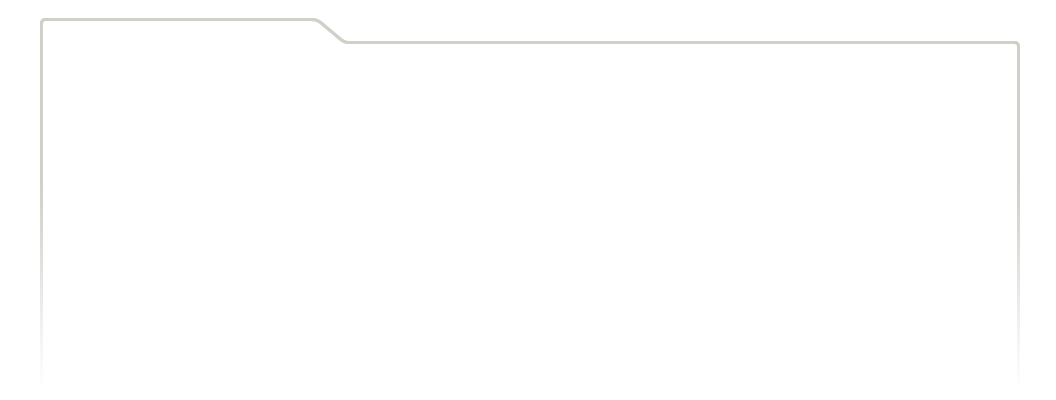
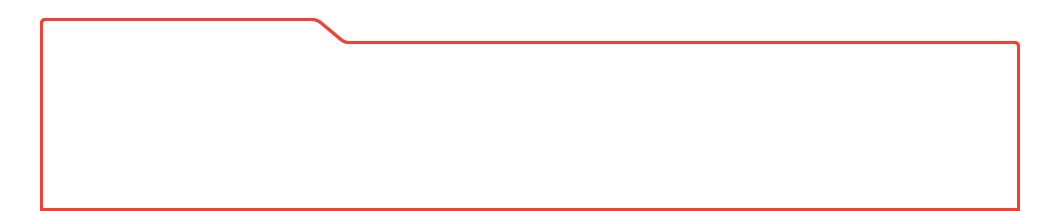
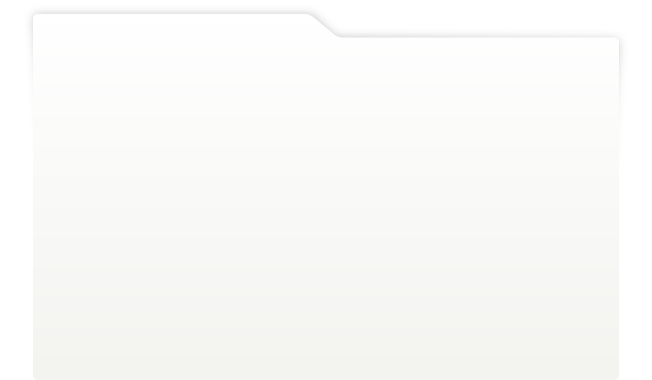
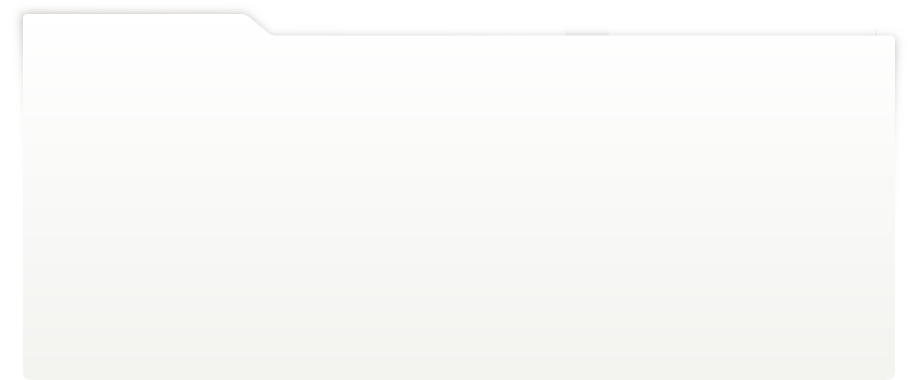
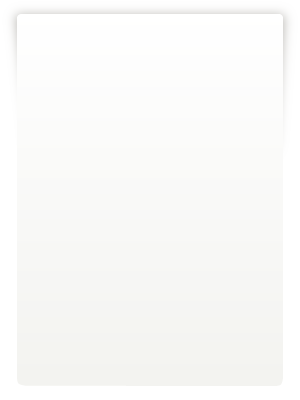
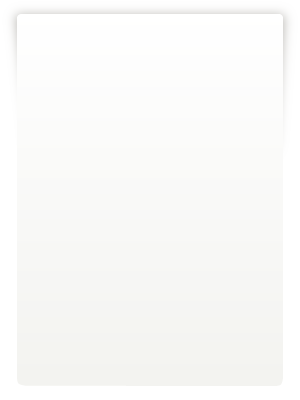
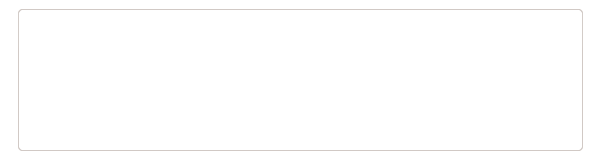
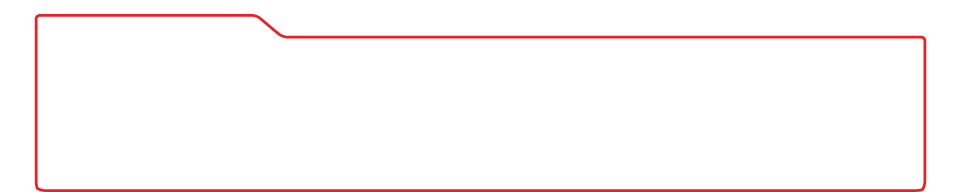
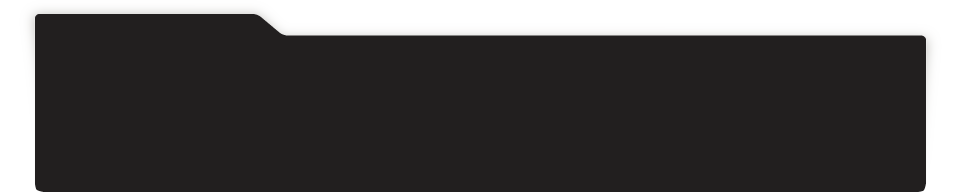
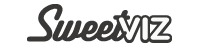
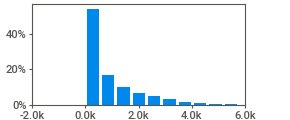
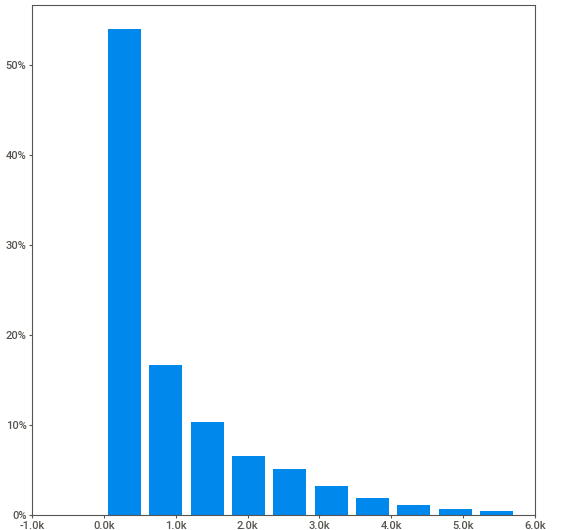
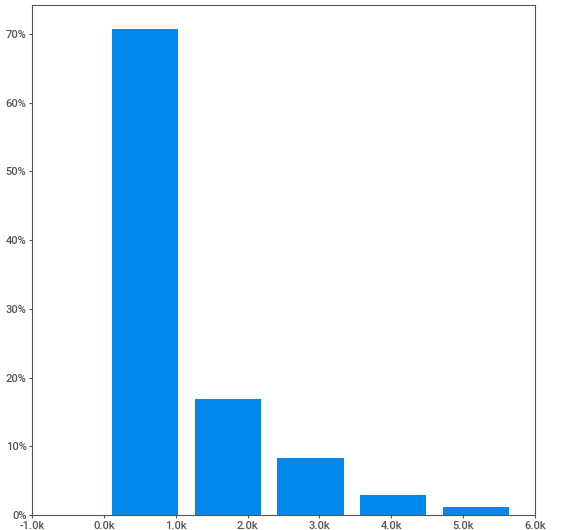
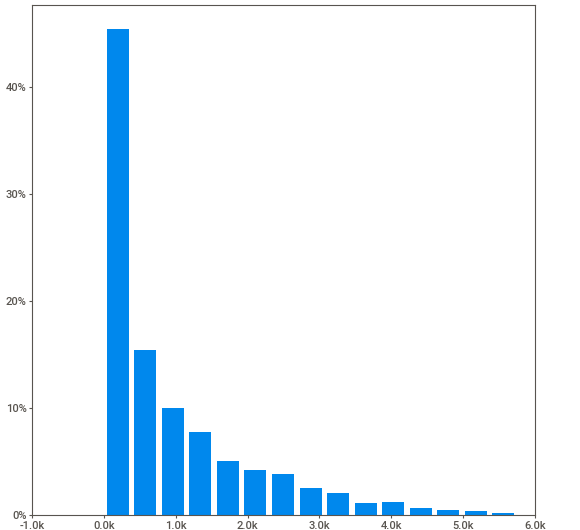
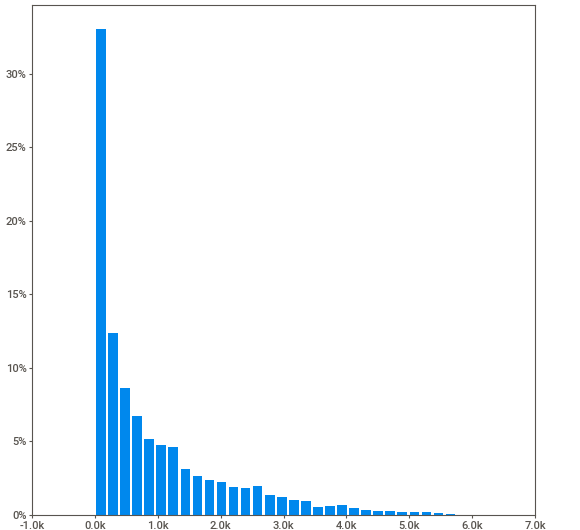
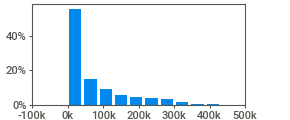
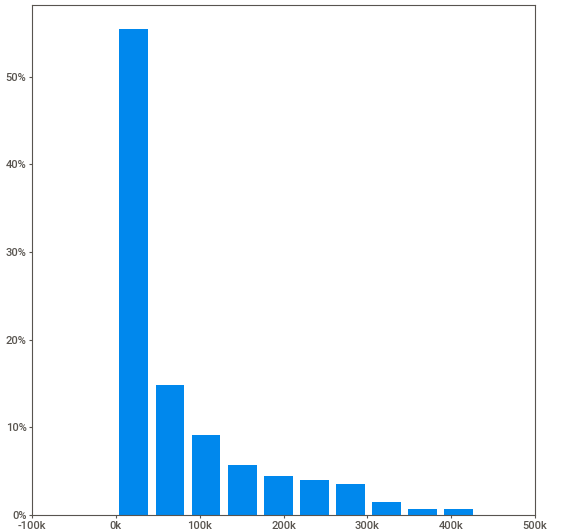
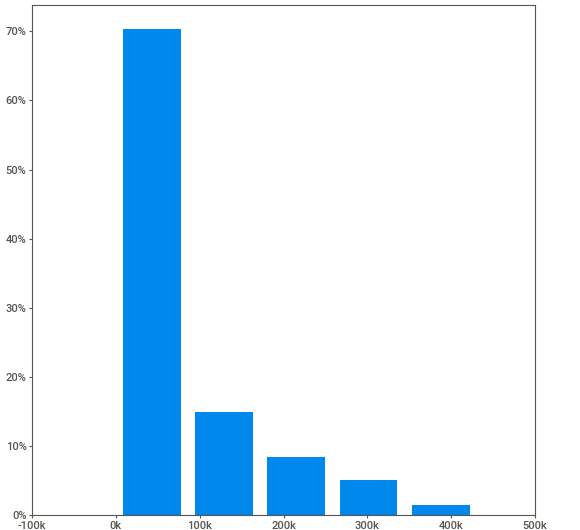
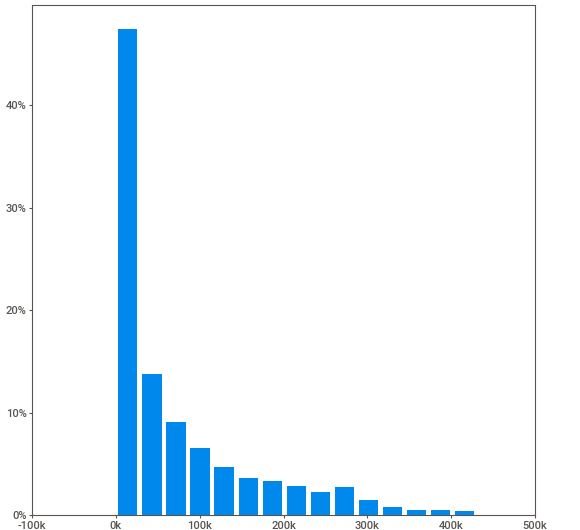
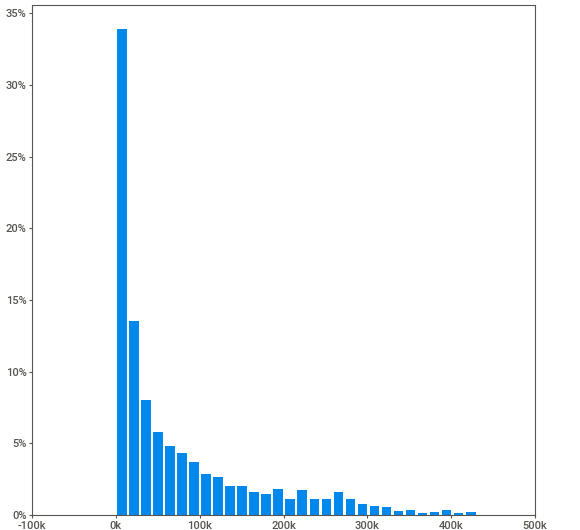
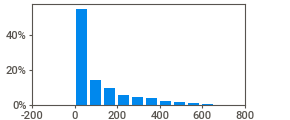
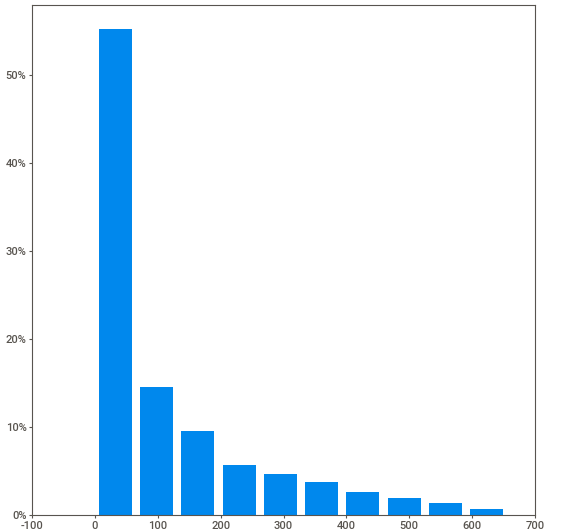
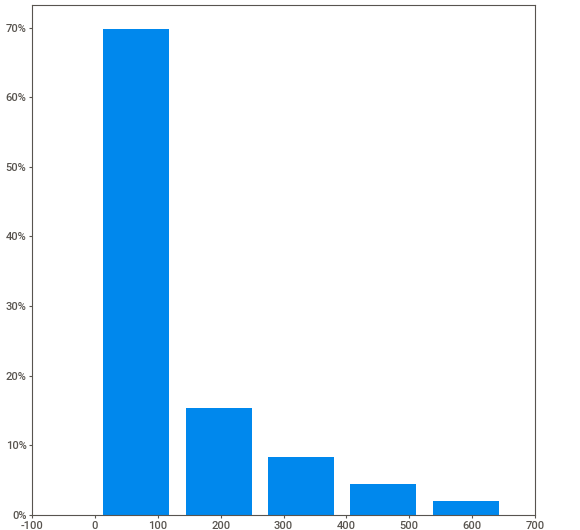
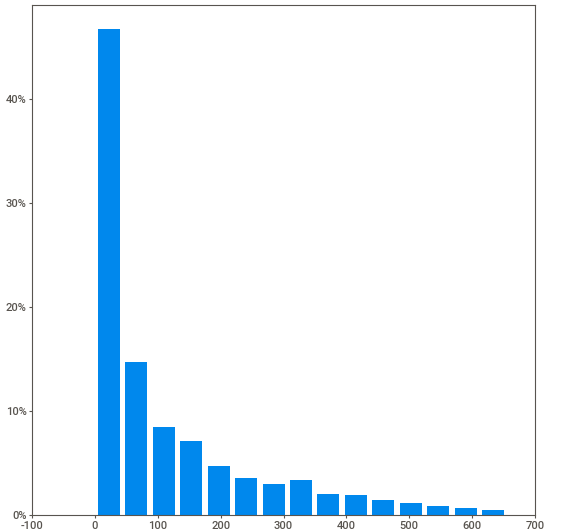
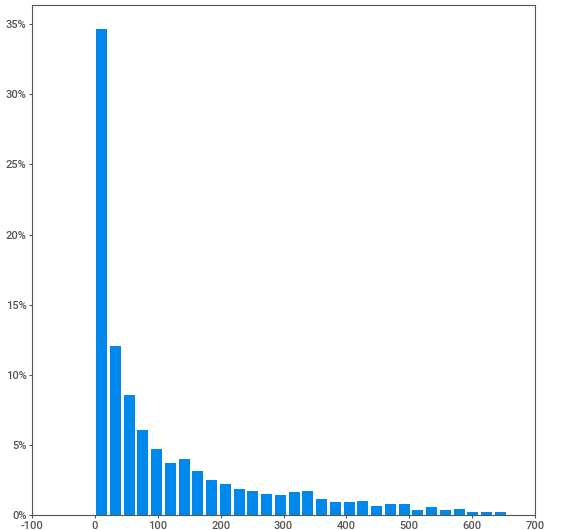
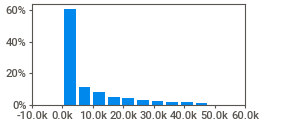
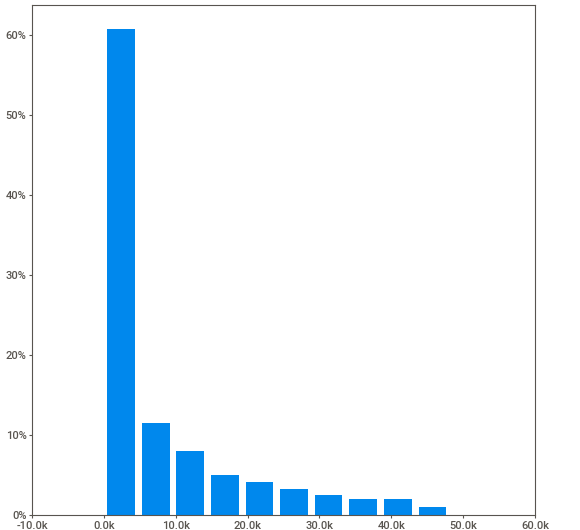
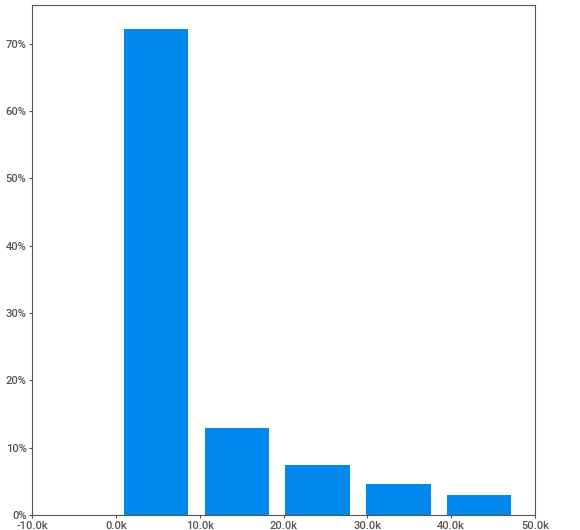
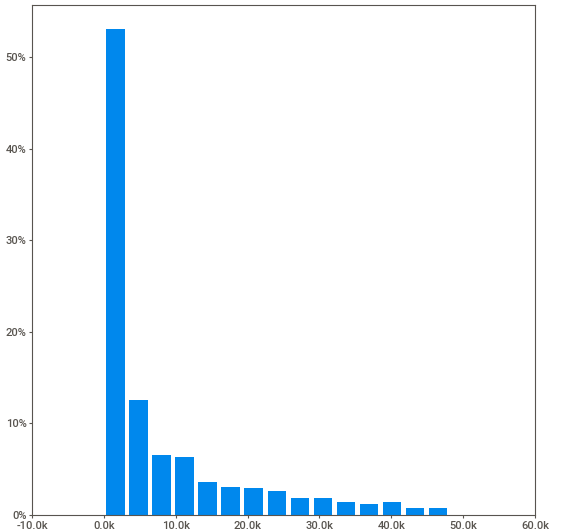
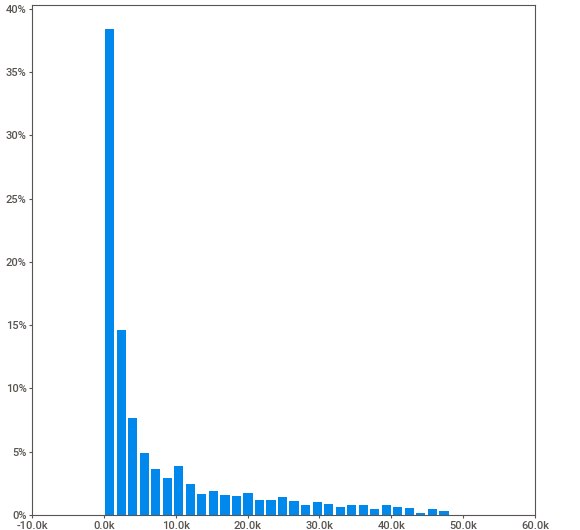
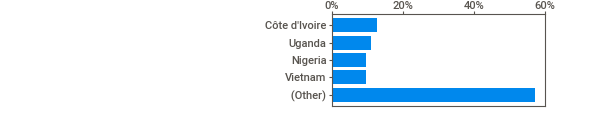
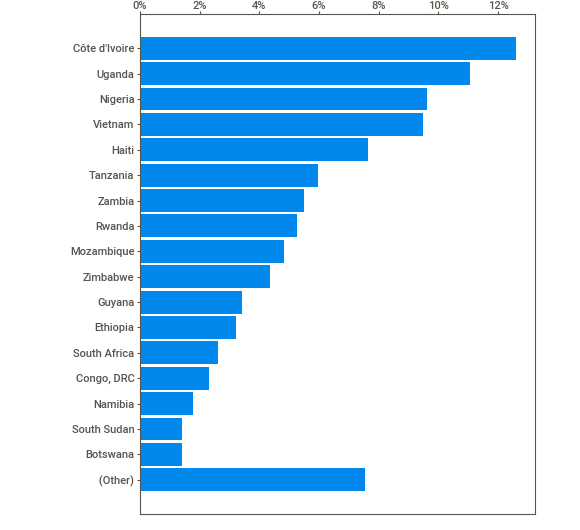
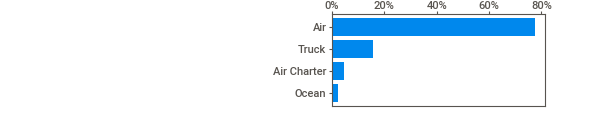
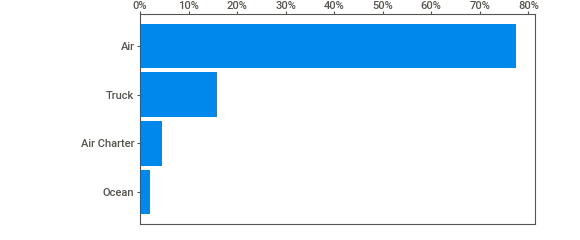
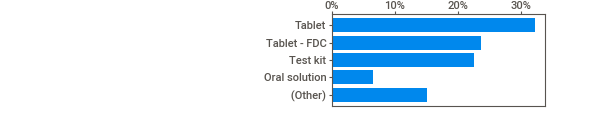
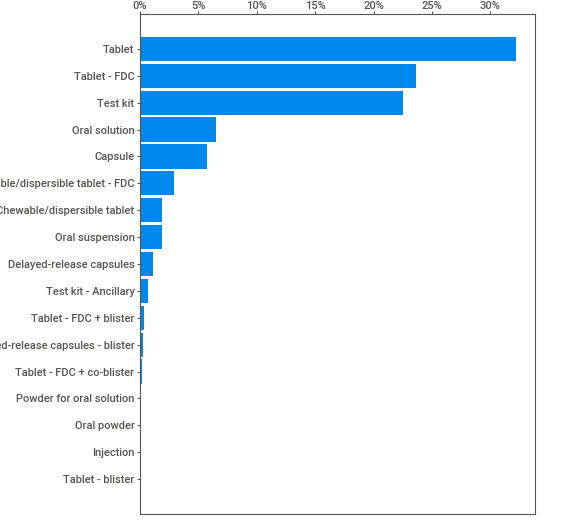
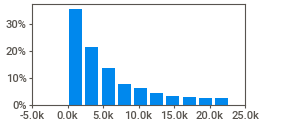
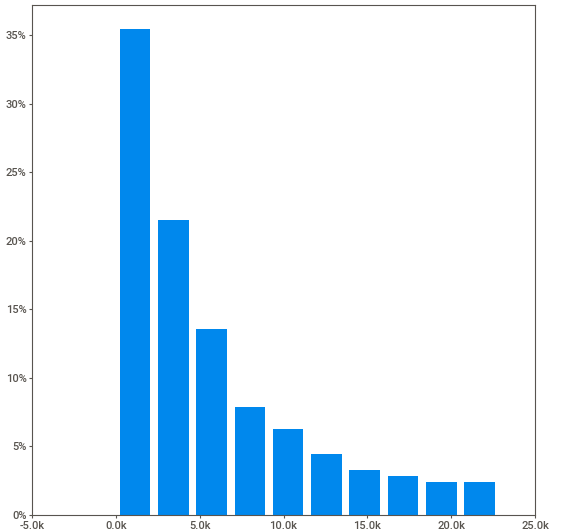
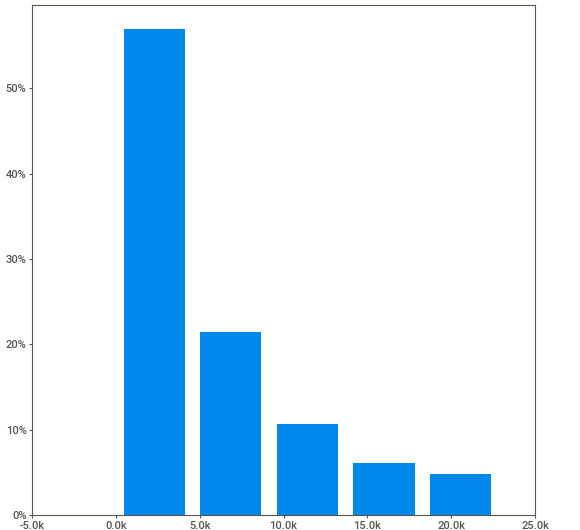
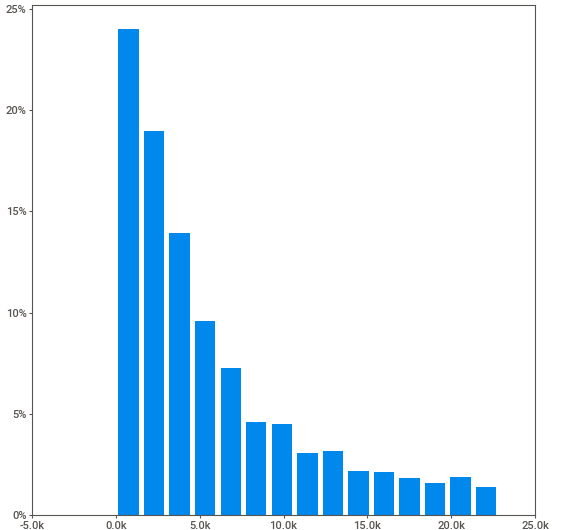
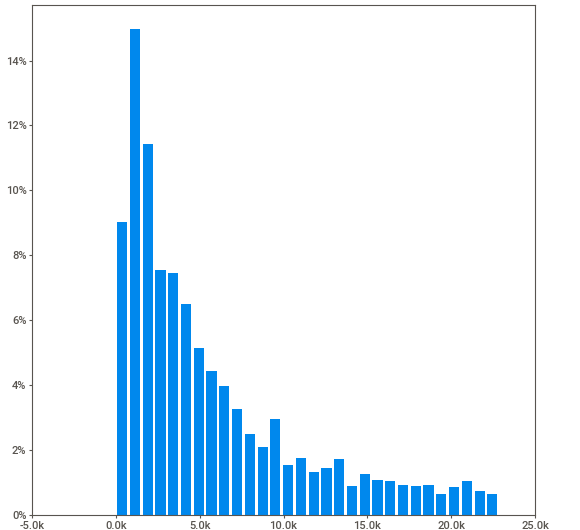
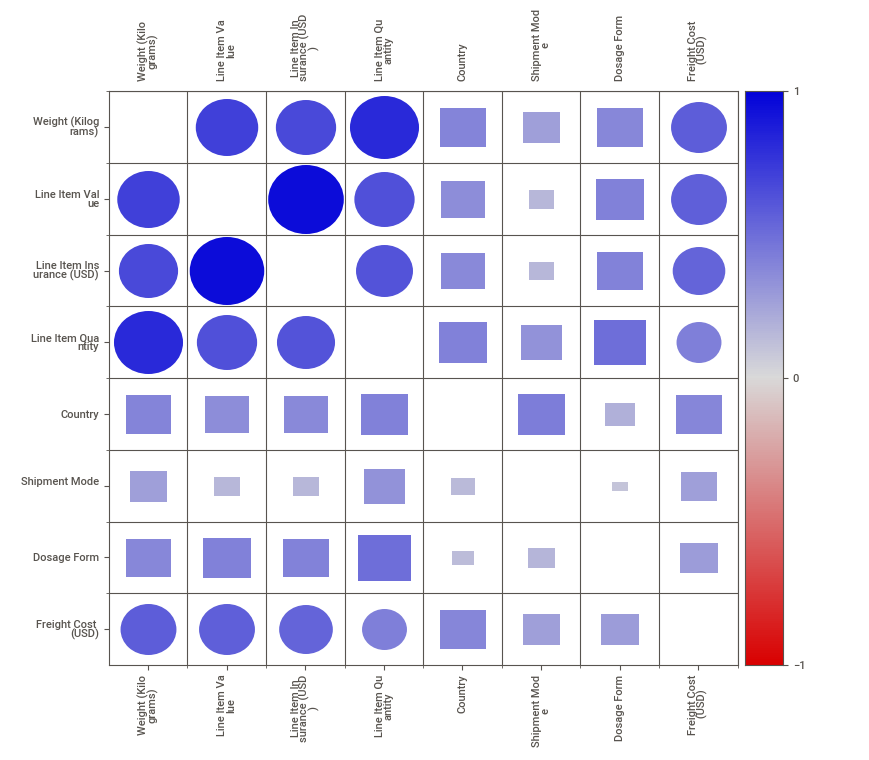
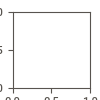

In [9]:
### 4 -> 5
### Turns df_4_drop0 to df_5_outliers

# Our newly grouped numerical data has some rather extreme outliers with very large values
    # There are very high values that might skew our data significantly
    # I will remove high values using 1.5 * IQR + median, using median since the large values inflate the mean
        # The IQR values are manually taken from SweetViz below, I could clean up the code in the future
    # We can explore logscaling or other feature transformations in the future to see if they improve model performance
    
df_5_outliers = df_4_drop0.copy()
df_5_outliers = df_5_outliers[df_5_outliers["Weight (Kilograms)"] < 
                                  (np.median(df_5_outliers["Weight (Kilograms)"])+
                                  (3200 * 1.5))]
df_5_outliers = df_5_outliers[df_5_outliers["Line Item Value"] < 
                                  (np.median(df_5_outliers["Line Item Value"])+
                                  (253000 * 1.5))]
df_5_outliers = df_5_outliers[df_5_outliers["Line Item Insurance (USD)"] < 
                                  (np.median(df_5_outliers["Line Item Insurance (USD)"])+
                                  (393 * 1.5))]
df_5_outliers = df_5_outliers[df_5_outliers["Line Item Quantity"] < 
                                  (np.median(df_5_outliers["Line Item Quantity"])+
                                  (29882 * 1.5))]
df_5_outliers = df_5_outliers[df_5_outliers["Freight Cost (USD)"] < 
                                  (np.median(df_5_outliers["Freight Cost (USD)"])+
                                  (12397 * 1.5))]

# We will run another SweetViz on our outlier cleaned
outlier_removed_data_report = sv.analyze(df_5_outliers)
outlier_removed_data_report.show_notebook()

In [10]:
### 5 -> 6
### Turns df_5_outliers into df_6_encoded

# We will now one-hot encode the categorical variables
categorical_features = [
                        "Country",
                        "Shipment Mode",
                        "Dosage Form"
]

dummy_encoded_values = pd.get_dummies(df_5_outliers[categorical_features])

# Merging them back to the original dataframe as a new dataframe
df_6_encoded = df_5_outliers.join(dummy_encoded_values)
df_6_encoded = df_6_encoded.drop(columns = categorical_features)
df_6_encoded

Weight (Kilograms)  Line Item Value  Line Item Insurance (USD)  \
ASN/DN #                                                                    
ASN-10006                94.0          1900.00                       3.14   
ASN-10007                43.0          3970.00                       6.55   
ASN-10062               453.0        195360.00                     322.34   
ASN-10063                 8.0          3223.44                       5.32   
ASN-10064               205.0         41800.00                      68.97   
...                       ...              ...                        ...   
DN-994                  393.0         40000.00                      78.40   
DN-995                   26.0          1450.00                       2.84   
DN-996                  501.0         50274.95                      98.54   
DN-998                  585.0         64690.60                     126.79   
DN-999                  671.0          3780.00                       7.41   

           Line Item Quantity  Freight Cost (USD)  Country_Afghanistan  \
ASN/DN #                                                                 
ASN-10006                 200              757.42                    0   
ASN-10007                 460             1082.89                    0   
ASN-10062                2000             7030.94                    0   
ASN-10063                  33             1011.60                    0   
ASN-10064                 418             6455.37                    0   
...                       ...                 ...                  ...   
DN-994                   1250              157.50                    0   
DN-995                    500             1096.71                    0   
DN-996                   5377             3266.38                    0   
DN-998                   7670             5698.01                    0   
DN-999                   1800             5110.76                    0   

           Country_Angola  Country_Belize  Country_Benin  Country_Botswana  \
ASN/DN #                                                                     
ASN-10006               0               0              0                 0   
ASN-10007               0               0              0                 0   
ASN-10062               0               0              0                 0   
ASN-10063               0               0              0                 0   
ASN-10064               0               0              0                 0   
...                   ...             ...            ...               ...   
DN-994                  0               0              0                 0   
DN-995                  0               0              0                 0   
DN-996                  0               0              0                 0   
DN-998                  0               0              0                 0   
DN-999                  0               0              0                 0   

           ...  Dosage Form_Oral solution  Dosage Form_Oral suspension  \
ASN/DN #   ...                                                           
ASN-10006  ...                          0                            0   
ASN-10007  ...                          0                            0   
ASN-10062  ...                          0                            0   
ASN-10063  ...                          0                            0   
ASN-10064  ...                          0                            0   
...        ...                        ...                          ...   
DN-994     ...                          0                            0   
DN-995     ...                          0                            0   
DN-996     ...                          0                            0   
DN-998     ...                          0                            0   
DN-999     ...                          1                            0   

           Dosage Form_Powder for oral solution  Dosage Form_Tablet 

In [11]:
### 6
### Uses df_6_encoded

# Create training and testing data sets. Starting with 70/30 split for initial review
    # Will cross-validate later to check for overfitting
    
input_values = df_6_encoded.drop(columns = "Freight Cost (USD)").values
output_values = df_6_encoded["Freight Cost (USD)"].values

X_train, X_test, y_train, y_test = train_test_split(input_values, output_values, test_size = 0.30)

In [12]:
### Model Building

# Read in training data into a random forest regressor
    # Hyper parameters found from a cross-validated random search below
rf_regressor = RandomForestRegressor(
    n_estimators = 500, 
    min_samples_split = 5,
    min_samples_leaf = 1,
    max_features = "sqrt",
    max_depth = 70,
    bootstrap = "true"
)

# # Read in training data into a random forest regressor
    # Hyper parameters found from a cross-validated random search below

gb_regressor = GradientBoostingRegressor(
    n_estimators = 500,
    min_samples_split = 10,
    min_samples_leaf = 4,
    max_features = "sqrt",
    max_depth = 90,
    learning_rate = 0.02
)

# Fit training data into the model
rf_regressor.fit(X_train, y_train)
gb_regressor.fit(X_train, y_train)

# Load in test data to build predictions
y_pred_rf = rf_regressor.predict(X_test)
y_pred_gb = gb_regressor.predict(X_test)

In [13]:
# Look at MAE and MAPE for Random Forest Regressor
rf_errors = abs(y_pred_rf - y_test)
rf_mape = 100 * (rf_errors / y_test)
rf_percent_error = np.mean(rf_mape)
print ('MAE: %.3f, MAE std: (%.3f), MAPE: %.3f%%' % (np.mean(rf_errors), np.std(rf_errors), rf_percent_error))

MAE: 2113.876, MAE std: (2385.133), MAPE: 121.088%


In [14]:
# Look at MAE and MAPE for Gradient Boosting Regressor
gb_errors = abs(y_pred_gb - y_test)
gb_mape = 100 * (gb_errors / y_test)
gb_percent_error = np.mean(gb_mape)
print ('MAE: %.3f, MAE std: (%.3f), MAPE: %.3f%%' % (np.mean(gb_errors), np.std(gb_errors), gb_percent_error))

MAE: 2056.932, MAE std: (2484.264), MAPE: 116.217%


                                             |    | [  0%]   00:00 -> (? left)


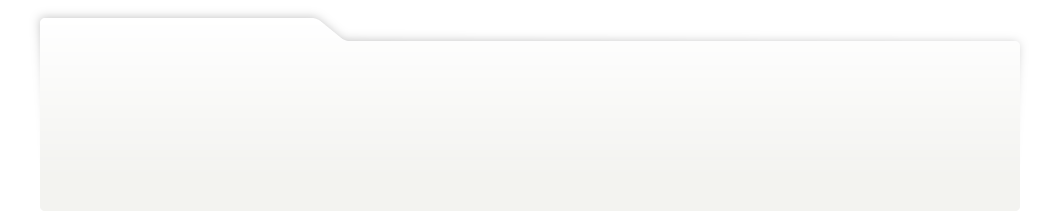
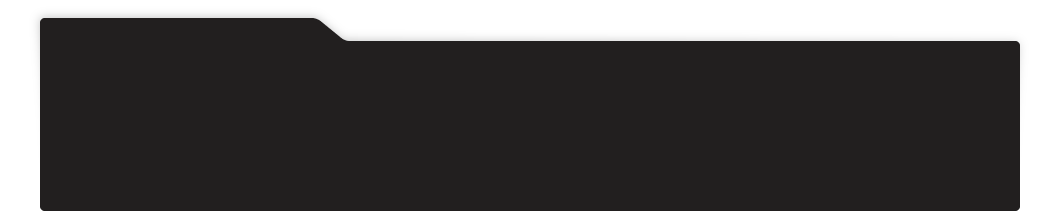
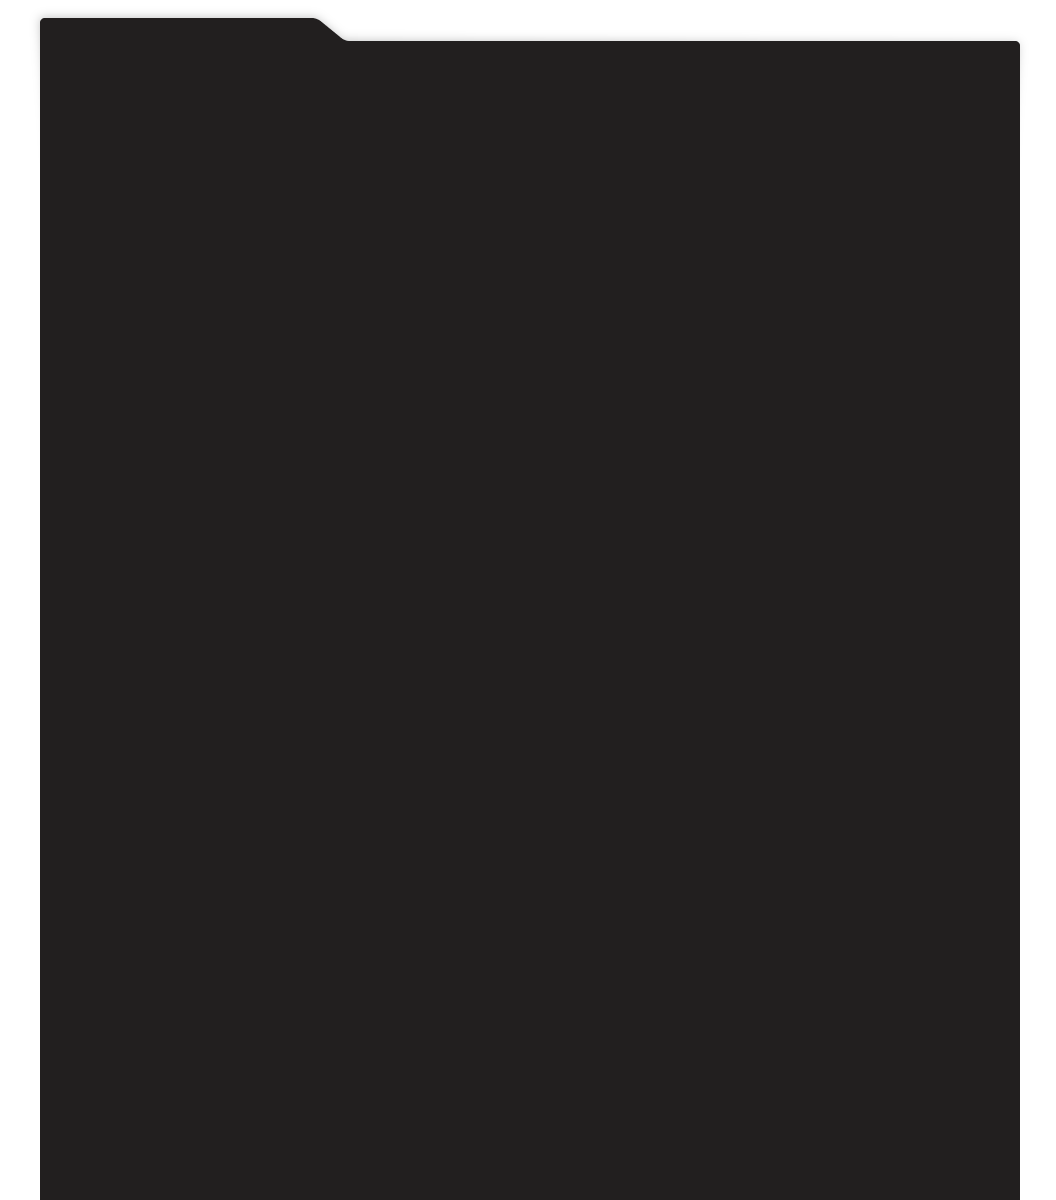
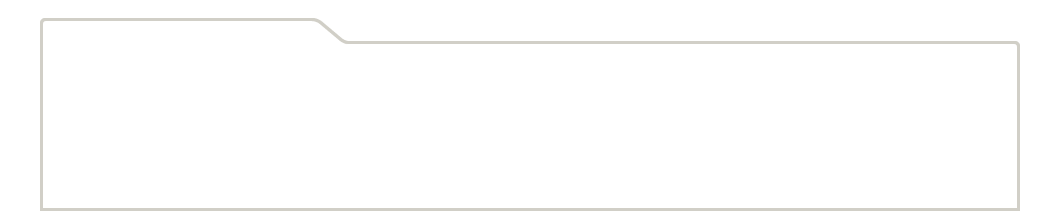
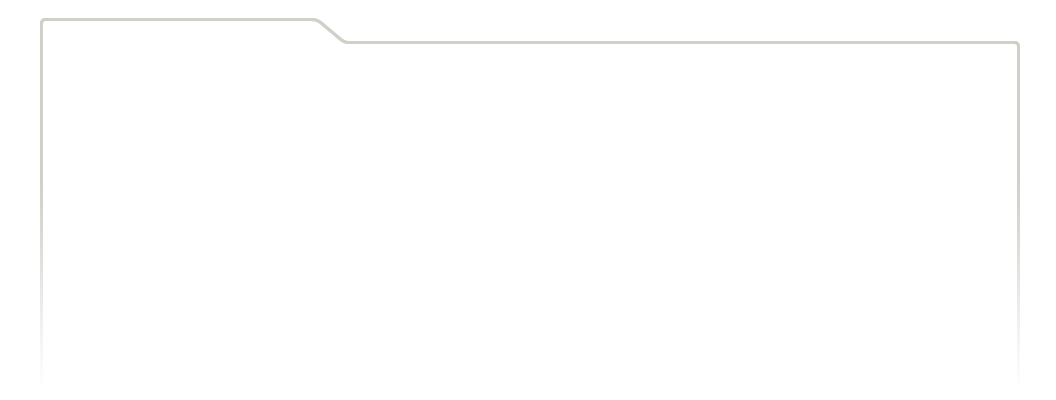
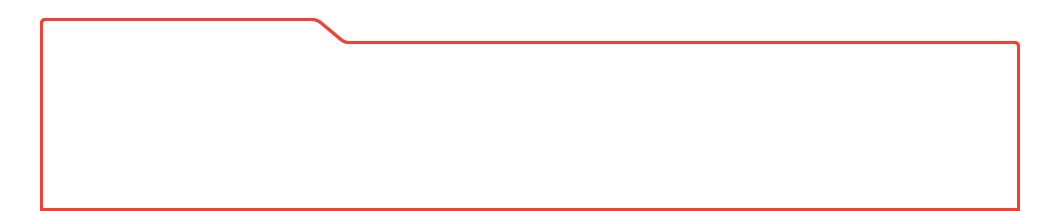
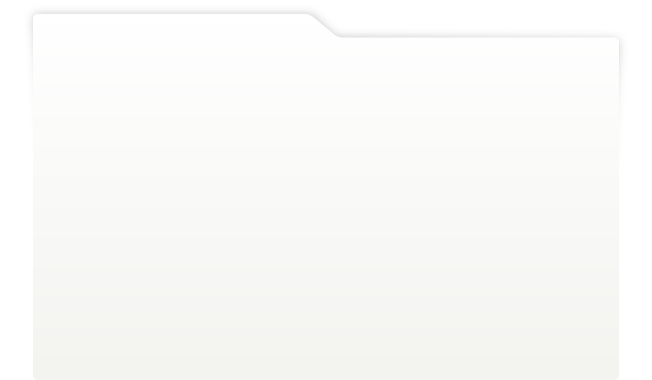
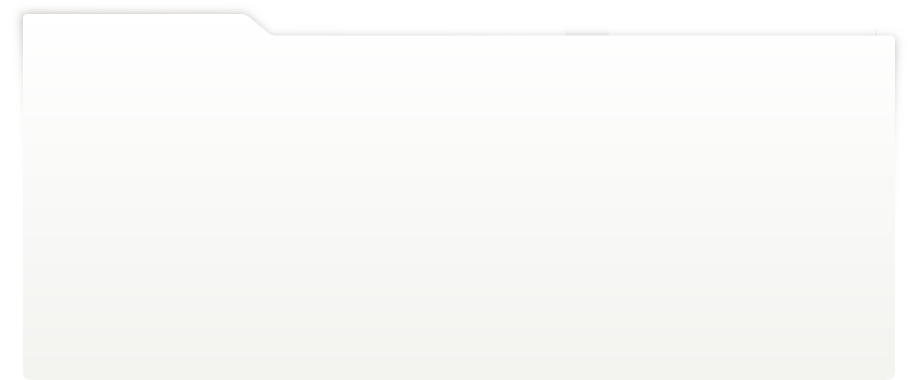
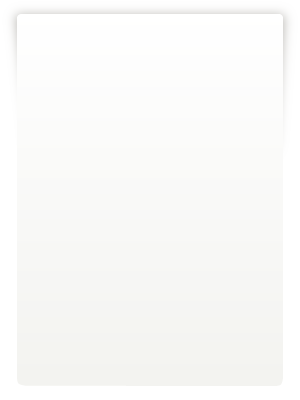
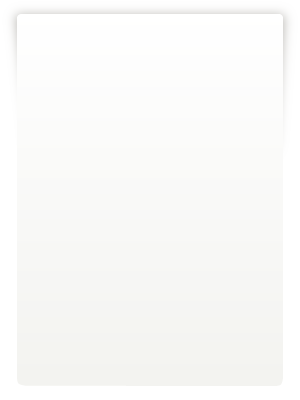
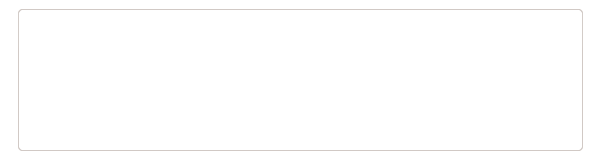
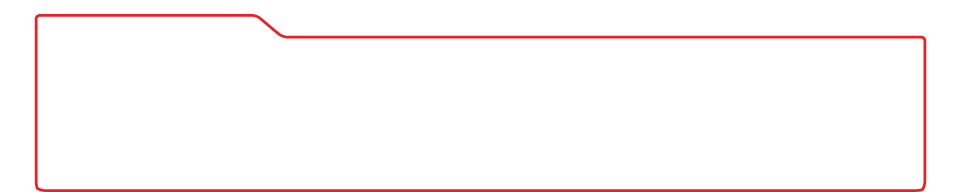
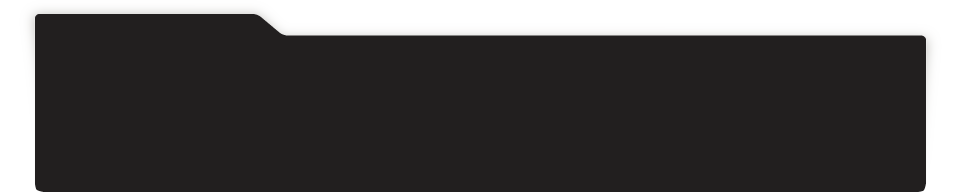
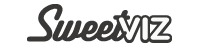
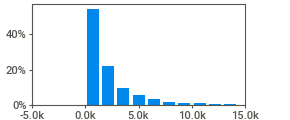
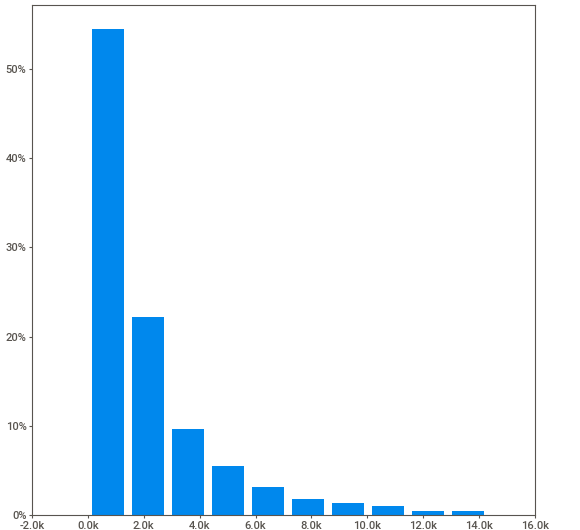
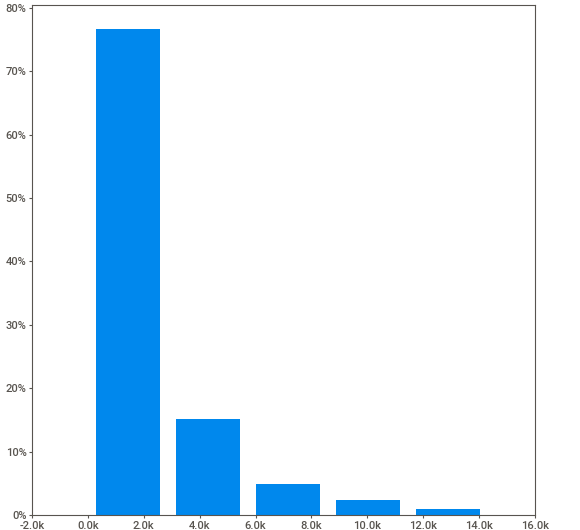
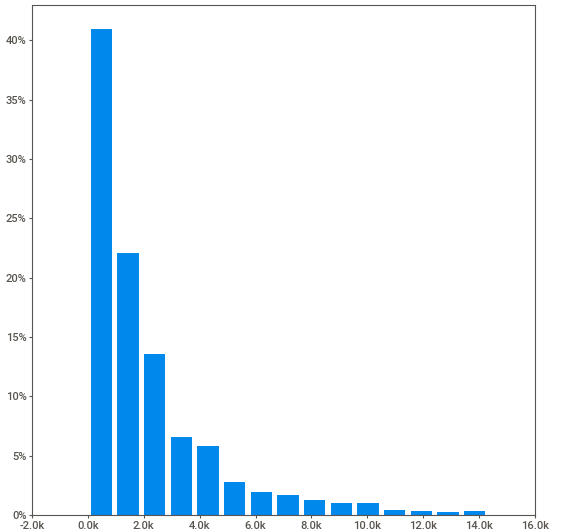
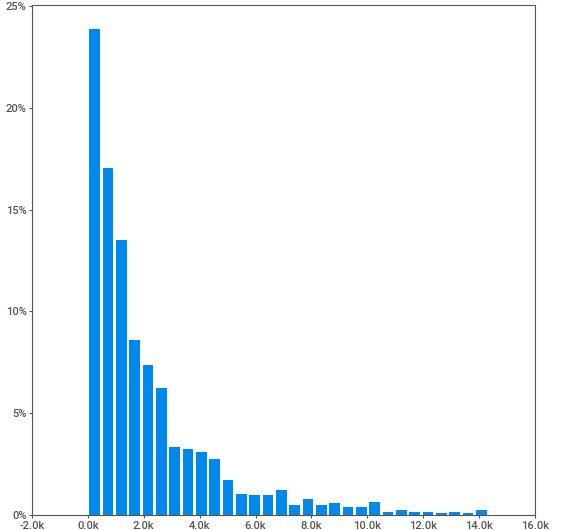
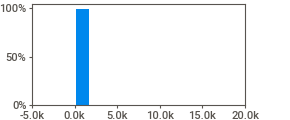
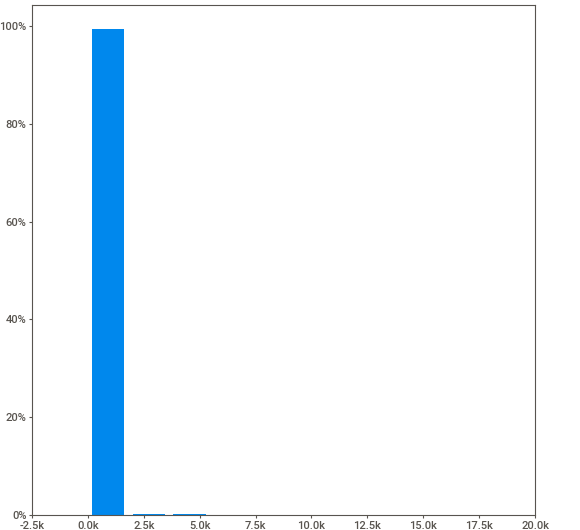
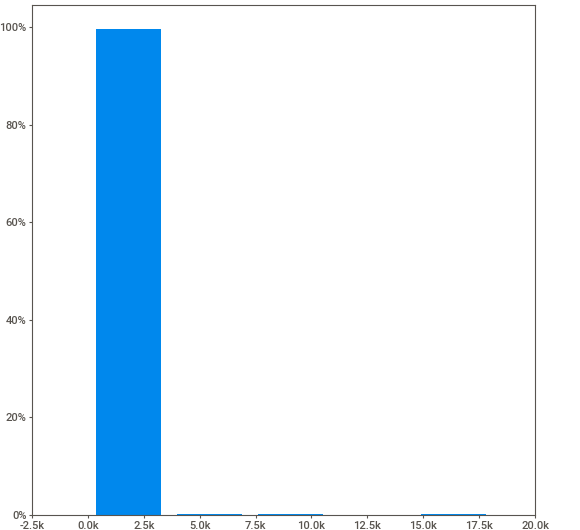
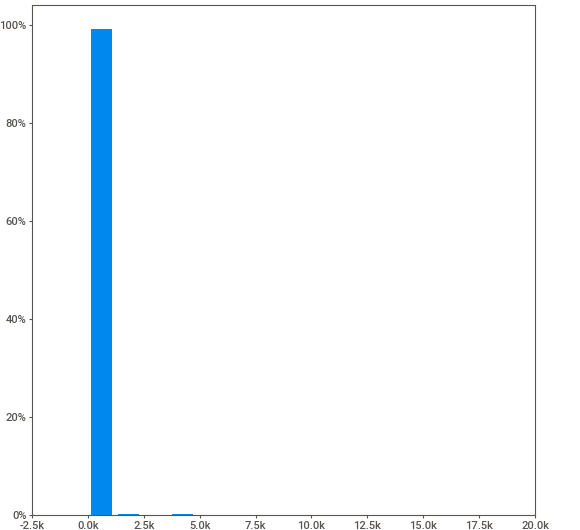
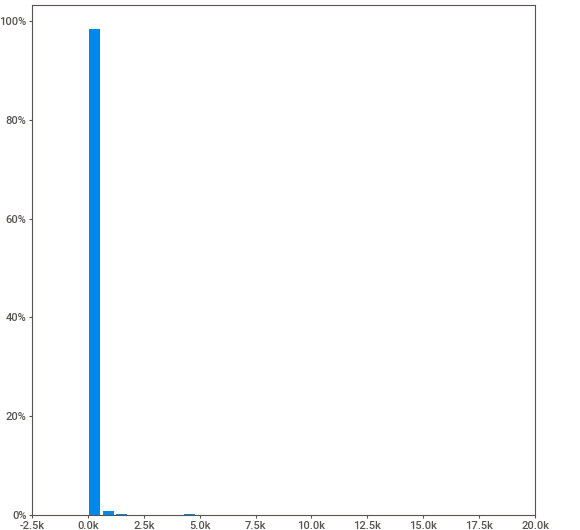
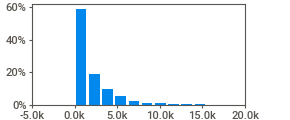
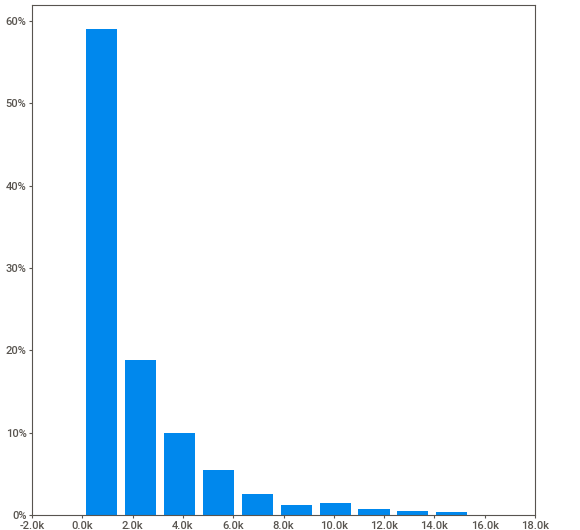
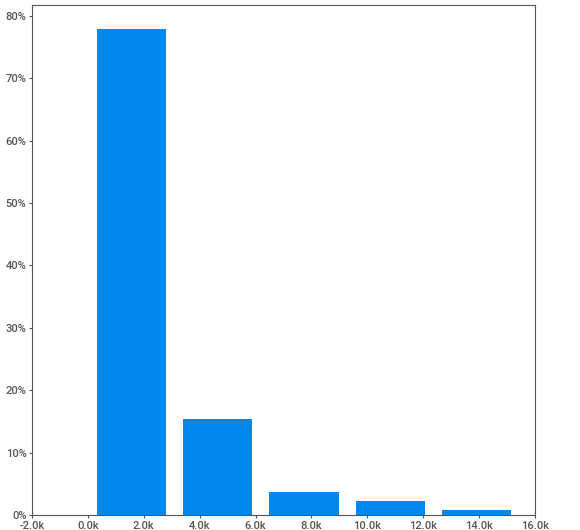
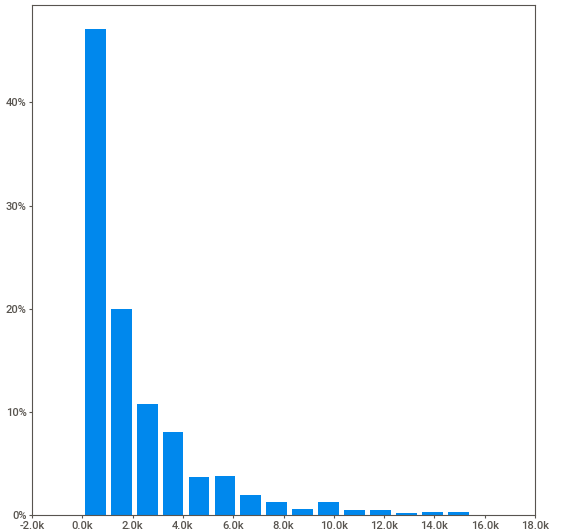
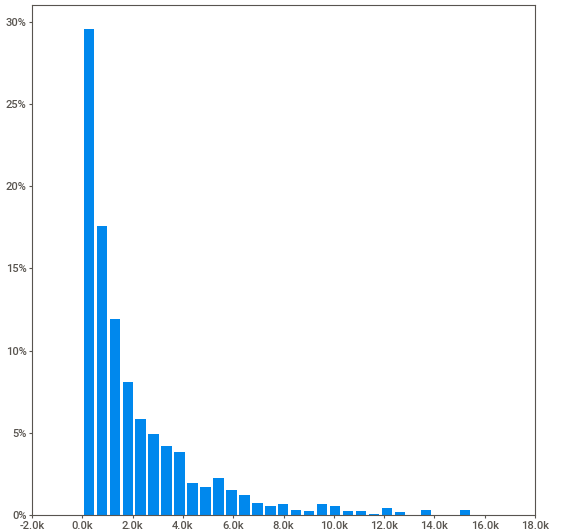
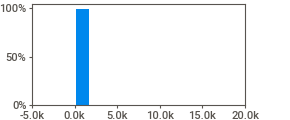
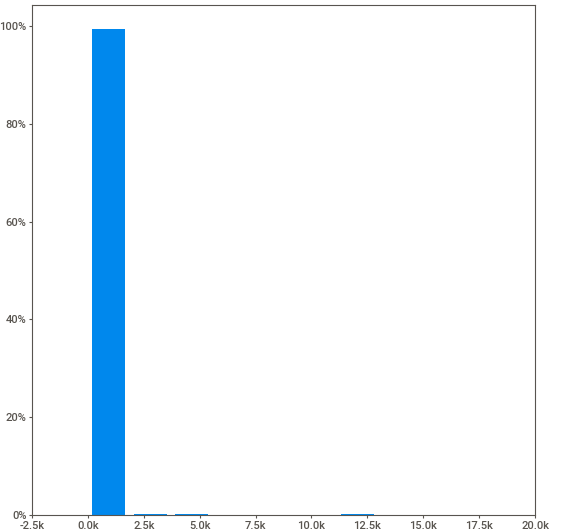
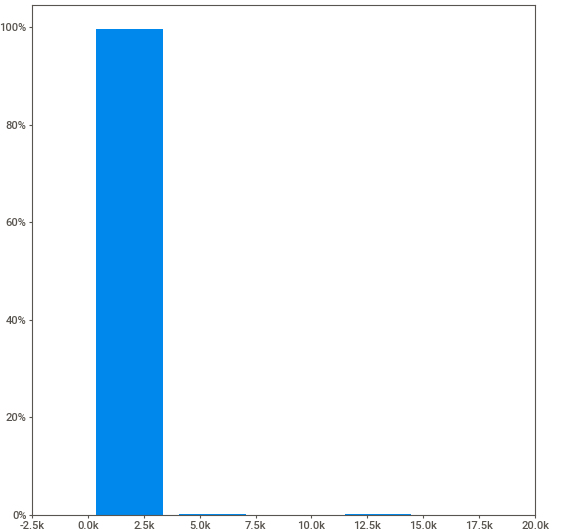
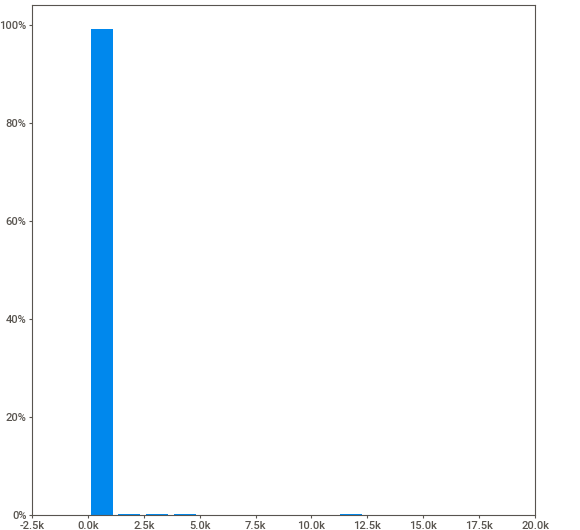
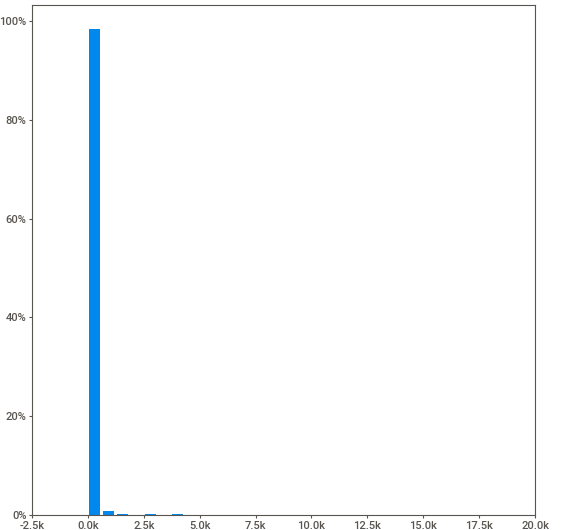
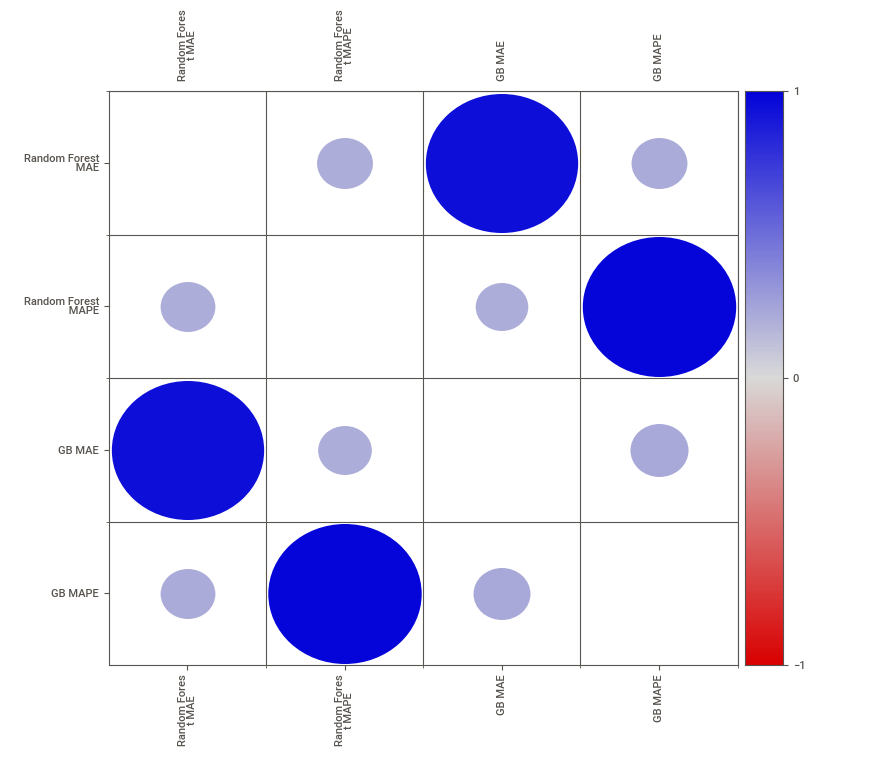
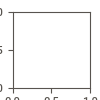

In [15]:
# Use SweetViz to get a look at the errors
error_frame = pd.DataFrame({
    "Random Forest MAE": rf_errors,
    "Random Forest MAPE": rf_mape,
    "GB MAE": gb_errors,
    "GB MAPE": gb_mape     
})
error_report = sv.analyze(error_frame)
error_report.show_notebook()

### We can see that while the MAE and MAPE are quite high-ish, the median values are much lower
    ### The median absolute error is nearly half the average
    ### The median absolute percentage is error ~30% vs 100%

C:\Users\jsohn4\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\jsohn4\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


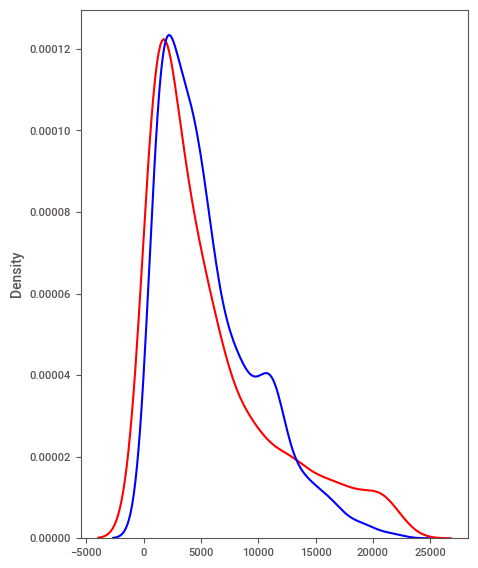

In [16]:
# Plot actuals vs prediction for the random forest
plt.figure(figsize = (5,7))

ax = sb.distplot(y_test, hist = False, color = "r", label = "Actual Value")
sb.distplot(y_pred_rf, hist = False, color = "b", label = "Fitted Values", ax = ax)

plt.show()

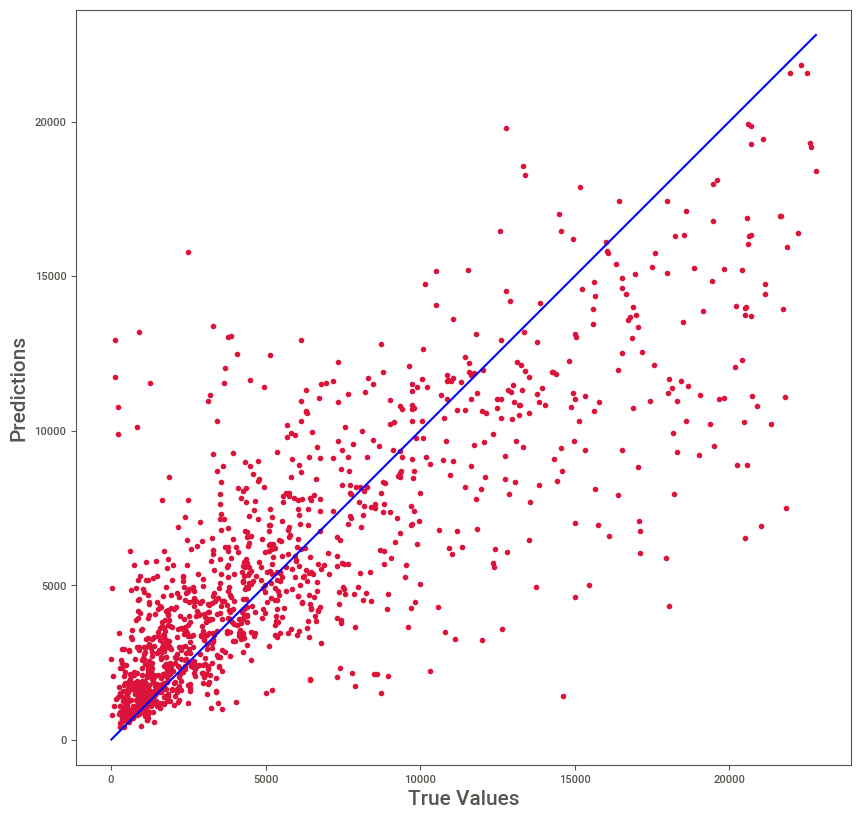

In [17]:
# Plot actuals vs predictions for random forest

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred_rf, c='crimson')
plt.yscale('linear')
plt.xscale('linear')

p1 = max(max(y_pred_rf), max(y_test))
p2 = min(min(y_pred_rf), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

(array([414., 465., 357.]),
 array([  0,  20,  60, 100]),
 <BarContainer object of 3 artists>)

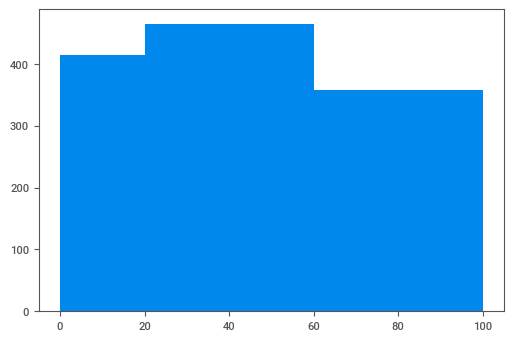

In [18]:
# Plot histogram of percent error for the random forest
bins = [0, 20, 60, 100]
plt.hist(np.clip(rf_mape, bins[0], bins[-1]), bins = bins)

### We see that 1036 out of 1236 possible values (83%) fall within <100% error, despite MAPE being ~100%
### ~73% of values fell within <60% error

In [25]:
# Look at the cross-validated score of the model to make sure we are not overfitting
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf_regressor_cv = RandomForestRegressor(    
    n_estimators = 500, 
    min_samples_split = 5,
    min_samples_leaf = 1,
    max_features = "sqrt",
    max_depth = 70,
    bootstrap = "true")

gb_regressor_cv = GradientBoostingRegressor(
    n_estimators = 500,
    min_samples_split = 10,
    min_samples_leaf = 4,
    max_features = "sqrt",
    max_depth = 90,
    learning_rate = 0.02
)

rf_scores = cross_val_score(rf_regressor_cv, input_values, output_values, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1, error_score='raise')
gb_scores = cross_val_score(gb_regressor_cv, input_values, output_values, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1, error_score='raise')

print('RF MAE: %.3f (%.3f)' % (np.mean(rf_scores), np.std(rf_scores)))
print('GB MAE: %.3f (%.3f)' % (np.mean(gb_scores), np.std(gb_scores)))

RF MAE: -2030.960 (104.101)
GB MAE: -2012.884 (113.281)


In [1110]:
# Random Search Cross Validation for Random Forest Regressor

# Tune n_estimators
n_estimators = [
    int(x) for x in np.linspace(
        start = 200, stop = 2000, num = 10
    )
]

# Tune max_features to all features or sqrt
max_features = ["auto", "sqrt"]

# Tune max_depth
max_depth = [
    int(x) for x in np.linspace(
        10, 110, num = 11
    )
]

# Tune min_samples_split
min_samples_split = [2, 5, 10]

# Tune min_samples_leaf
min_samples_leaf = [1, 2, 4]

# Tune bootstrap
bootstrap = [True, False]

# Random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

rf_searched = RandomForestRegressor()

rf_random = RandomizedSearchCV(
    estimator = rf_searched,
    param_distributions = random_grid,
    n_iter = 100,
    cv = 3,
    verbose = 2,
    random_state = 42,
    n_jobs = -1
)

rf_random.fit(input_values, output_values)
rf_random.best_params_

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': True}

In [1426]:
# Random Search Cross Validation for Gradient Boosted Regressor

# Tune n_estimators
n_estimators = [
    int(x) for x in np.linspace(
        start = 200, stop = 2000, num = 10
    )
]

# Tune max_features to all features or sqrt
max_features = ["auto", "sqrt"]

# Tune max_depth
max_depth = [
    int(x) for x in np.linspace(
        10, 110, num = 11
    )
]

# Tune min_samples_split
min_samples_split = [2, 5, 10]

# Tune min_samples_leaf
min_samples_leaf = [1, 2, 4]

# Tune learning_rate
learning_rate = [0.02, 0.05]

# Random grid
random_grid_gb = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate}

print(random_grid)

gb_searched = GradientBoostingRegressor()

gb_random = RandomizedSearchCV(
    estimator = gb_searched,
    param_distributions = random_grid_gb,
    n_iter = 100,
    cv = 3,
    verbose = 2,
    random_state = 42,
    n_jobs = -1
)

gb_random.fit(input_values, output_values)
gb_random.best_params_

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 90,
 'learning_rate': 0.02}